

# Pattern Mining Phase - PAA & SAX

* We have done Exploratory Data Analysis, Data Selection, Data Preprocessing, Data Transformation and now we have the **Pattern Mining phase**.
* We will be using two distinct algorithmic approaches to uncover hidden structures within the seismic data: **Symbolic Aggregate approXimation (SAX)** and **Matrix Profile (STAMP/STOMP)**.

These two methods provide a piecewise comparison by attacking the problem from different granularities—SAX offers a high-level, global view of signal topology, while Matrix Profile provides an exact, local view of subsequence similarity.

---

### **1. Piecewise Aggregate Approximation (PAA)**

**Approach:** Dimensionality Reduction via Segmentation

PAA is the foundational step before SAX. It reduces each 1000-sample earthquake signal into a smaller number of segments by averaging within fixed windows.

* **Mechanism:**

  * The original signal of length (N = 1000) is divided into (w) equal-sized frames.
  * Each frame’s mean value becomes one element of the PAA representation.
  * Mathematically:
    [
    \text{PAA}*i = \frac{1}{\Delta} \sum*{j=(i-1)\Delta+1}^{i\Delta} x_j, \quad \Delta = N/w
    ]
  * This converts the signal from length 1000 → (w) (e.g., 100 segments).
* **Purpose:**

  * Drastically reduces noise, small fluctuations, and sampling artifacts.
  * Captures the **global shape** while compressing the data.
* **Why it matters:**

  * PAA enables SAX to work on a simplified, smooth version of the signal.
  * Without PAA, SAX would be too sensitive to raw peaks and jitter.

---

### **2. Symbolic Aggregate approXimation (SAX)**

**Approach:** Approximate & Symbolic

SAX discretizes the (PAA-compressed) continuous signal into a symbolic string. This enables text-mining and sequence-matching techniques on seismic waveforms.

* **Mechanism:**

  1. **Z-normalization**: Each signal is normalized to zero mean and unit variance.
  2. **PAA (Piecewise Aggregate Approximation)** reduces the 1000-length signal to (w) segments.
  3. **Symbolization:**

     * The PAA values are mapped to an alphabet of size (a)
     * Using Gaussian breakpoints that divide the normal distribution into equal-probability regions.
     * E.g., with alphabet size (a = 5), breakpoints might be:
       [
       [-0.84,\ -0.25,\ 0.25,\ 0.84]
       ]
  4. The result is a symbolic representation such as:
     `"bbaccddac…"`.
* **Goal:**
  Cluster or classify the **global topology** of earthquake signals.
  SAX answers: *“Which earthquakes produce similar overall waveforms?”*
* **Computational Complexity:**
  Linear, (O(n)), extremely efficient for all 30,000 signals.

---

### **3. Matrix Profile (STAMP/STOMP)**

**Approach:** Exact & Continuous

The Matrix Profile computes the nearest-neighbor distance for every subsequence of a signal, enabling exact motif and anomaly discovery.

* **Mechanism:**

  * Using STOMP (via `stumpy`), compute the sliding-window Euclidean distance across every 50–200 sample window.
  * Produces a vector where low values correspond to repeated patterns (motifs), and high values correspond to anomalies (discords).
* **Goal:**
  Detect whether a **local vibration pattern** repeats across multiple earthquake events.
  Answers: *“Does a specific 50ms precursor pattern occur before the main shock?”*
* **Computational Complexity:**
  Conceptually (O(n^2)), but STOMP optimizes it to a near-linear update with GPU/parallel acceleration.

---

### **Summary of Comparison**

| Feature         | SAX                                     | Matrix Profile                        |
| :-------------- | :-------------------------------------- | :------------------------------------ |
| **Granularity** | **Global:** Entire signal shape         | **Local:** Subsequence-level          |
| **Precision**   | **Approximate:** PAA + symbolization    | **Exact:** Real Euclidean distances   |
| **Output**      | Symbolic strings ("aacbb…")             | Distance vector                       |
| **Use Case**    | Clustering full signals into categories | Finding motifs, precursors, anomalies |
| **Strength**    | Fast, compressive, interpretable        | Precise, mathematically rigorous      |
| **Focus**       | Whole-signal similarity                 | Subsequence similarity                |




## PAA & SAX transformation

In [42]:
import numpy as np
from pyts.approximation import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

def transform_and_serialize(data, n_segments=50, n_bins=5, strategy='normal', separator="|"):
    """
    Applies PAA and SAX independently to each channel, then safely serializes them
    for pattern mining.
    
    Parameters:
    -----------
    data : np.ndarray
        Shape (n_samples, n_channels, n_timesteps).
    n_segments : int
        Number of PAA segments.
    n_bins : int
        Alphabet size.
    separator : str
        A unique character to insert between channels during serialization.
        
    Returns:
    --------
    X_sax_3d : np.ndarray
        The 3D array of characters (n_samples, n_channels, n_segments).
        Useful if you want to analyze channels separately later.
    serialized_strings : list of str
        A list of length n_samples. Each item is the safely joined string 
        of that earthquake's channels.
    """
    n_samples, n_channels, n_timesteps = data.shape
    
    # 1. INDEPENDENT PROCESSING
    # By reshaping to (N*C, T), 'pyts' will calculate Mean/Std and normalize
    # EVERY single channel trace independently. This is exactly what you want.
    data_flat = data.reshape(n_samples * n_channels, n_timesteps)
    
    # Calculate window size
    window_size = n_timesteps // n_segments
    
    # 2. PAA Transformation
    paa = PiecewiseAggregateApproximation(window_size=window_size)
    X_paa_flat = paa.fit_transform(data_flat)
    
    # 3. SAX Transformation
    sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy=strategy)
    X_sax_flat = sax.fit_transform(X_paa_flat)
    
    # Reshape back to 3D to identify which string belongs to which channel
    # Shape: (Samples, Channels, Segments)
    X_sax_3d = X_sax_flat.reshape(n_samples, n_channels, n_segments)
    
    # 4. SAFE SERIALIZATION
    # We join the 3 channels into one string, separated by the 'separator'
    serialized_strings = []
    
    for i in range(n_samples):
        # Extract the 3 strings for this specific earthquake
        # e.g., chan_strs might look like ["abcde...", "bbcca...", "cdeea..."]
        chan_strs = ["".join(X_sax_3d[i, c]) for c in range(n_channels)]
        
        # Join them with the separator
        # Result: "abcde...|bbcca...|cdeea..."
        full_string = separator.join(chan_strs)
        serialized_strings.append(full_string)
        
    return X_sax_3d, serialized_strings



In [43]:
import matplotlib.pyplot as plt
import numpy as np
from pyts.approximation import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

def visualize_quantile_bins(data, n_segments=50, n_bins=5, save="sax/quantiles", channel="E"):
    """
    Fits SAX using 'quantile' strategy and visualizes the learned bins
    over the histogram of the actual data.
    """
    # 1. Prepare Data (Flatten channels)
    n_samples, n_channels, n_timesteps = data.shape
    data_flat = data.reshape(-1, n_timesteps)
    
    # 2. Run PAA first (Since SAX runs on PAA values)
    window_size = n_timesteps // n_segments
    paa = PiecewiseAggregateApproximation(window_size=window_size)
    X_paa_flat = paa.fit_transform(data_flat)
    
    # 3. Fit SAX with 'quantile'
    # We must flatten PAA output to 1D to see the global distribution of values
    X_paa_all_values = X_paa_flat.flatten().reshape(-1, 1)
    
    sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='quantile')
    sax.fit(X_paa_flat) # Fit on the dataset to learn the edges
    
    # 4. Retrieve Learned Edges
    # bin_edges_ usually comes as shape (1, n_bins+1) or (n_features, n_bins+1)
    # For global quantization, we look at the first row or unique values.
    # In pyts, it often computes edges per feature. 
    # To treat all segments as one distribution (Global SAX), we check the first segment's bins
    # or ideally, fit SAX on a single column of all data. 
    
    # SIMPLIFICATION FOR VISUALIZATION:
    # We calculate the percentiles manually to match what 'quantile' does globally
    learned_edges = np.percentile(X_paa_all_values, np.linspace(0, 100, n_bins + 1))
    
    print("--- Learned Quantile Thresholds ---")
    alphabet = [chr(ord('a') + i) for i in range(n_bins)]
    for i in range(n_bins):
        print(f"Char '{alphabet[i]}': {learned_edges[i]:.4f} to {learned_edges[i+1]:.4f}")

    # 5. Plot Histogram
    plt.figure(figsize=(20, 12))
    
    # Plot the histogram of YOUR data values
    plt.hist(X_paa_all_values, bins=100, density=True, color='lightgray', label='Data Distribution (PAA)')
    
    # Plot the bin edges
    colors = plt.cm.viridis(np.linspace(0, 1, n_bins))
    
    for i in range(n_bins):
        # Fill regions
        plt.axvspan(learned_edges[i], learned_edges[i+1], color=colors[i], alpha=0.3)
        
        # Label letters
        mid_point = (learned_edges[i] + learned_edges[i+1]) / 2
        
        # Note: If edges are infinite/extreme, clip them for text placement
        if i == 0: mid_point = learned_edges[i+1] - 0.5 
        if i == n_bins - 1: mid_point = learned_edges[i] + 0.5
            
        plt.text(mid_point, plt.gca().get_ylim()[1]*0.5, alphabet[i], 
                 fontsize=15, fontweight='bold', ha='center', color='black')
        
        # Draw lines
        plt.axvline(learned_edges[i], color='k', linestyle='--', alpha=0.5)

    plt.title(f"SAX 'Quantile' Strategy (n_bins={n_bins})")
    plt.xlabel("Amplitude Value (Normalized)")
    plt.ylabel("Frequency")
    plt.xlim(np.percentile(X_paa_all_values, 1), np.percentile(X_paa_all_values, 99)) # Zoom in to main data
    plt.savefig(f"{save}/segment{n_segments}_bin{n_bins}_channel-{channel}", dpi=300)
    plt.show()

In [44]:
import pandas as pd

signals = np.load("signal_data/processed_seismic_data.npy")

print("signals.shape: ", signals.shape)

signals.shape:  (29871, 3, 1000)


In [45]:
sax_signals3d, safe_strings = transform_and_serialize(signals, n_segments=200, n_bins=26, strategy='quantile')
#visualize_quantile_bins(signals, 200, 5)

print(f"Original Shape: {signals.shape}")
print(f"3D SAX Shape:   {sax_signals3d.shape}")

print("\n--- Pattern Mining Input Check ---")
print(f"Earthquake 0 String: {safe_strings[0]}")
# You should see something like: "acbd...|abcc...|ddba..."

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 200)

--- Pattern Mining Input Check ---
Earthquake 0 String: cydhnwevdwjmudsitogweptdtdtnjhxcoiqnuewjqnffxhpcvzatayyaazbywbizvezapbzaozbygczjbxxkarybxgazxcfgvuwcjrwgkhkybvrbyfgsdxqcuwhmduvepfvipnpeptrduitqhimqkoloorheusnfkvfhsmsqgitkllsjpmjlmrmlkknqoqelrmlnsgjs|tjrqcviubyelnnuolgqvgpekwmpguhwmkgsmuhvfhnqlukyeafczaazagzcfwxxdtaxprdbznbyxaybyiocgzaazevhybczidbxtkthdkyfhsvbxjnixdbzcweufrksrwcstfmqvdweepydmqohoorvdlrmspisigwremunjpjqtklnhpqqjmntiwfjpkosjsjvgllot|yagwohpesrmcylhwedybvgiwmiufrphitmndxdnsdmxdmelzaayzaywyaysbzawwbzdhbzbrzaxbzjecczjcjychcwvxafvxnpbswmfpjqudpxbxkigsqucvtfjrgtvenivkntggmukqnfurlejvpglslfujtnekqvdstohkjpqrihqkrokmithloqokngoplqtfeuso


In [46]:
import logomaker
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_sax_logo(
        X_sax_3d,
        channel=0,
        n_bins=5,
        title="Earthquake_Signal",
        color_scheme="bright",
        unit_type="information" # Options: 'counts', 'probability', 'information' (Best for patterns)
    ):
    """
    Creates a Sequence Logo for a specific channel of SAX-transformed signals.
    
    Parameters
    ----------
    X_sax_3d : np.ndarray
        Shape (n_samples, n_channels, n_segments)
    channel : int
        Which channel to visualize (0, 1, or 2)
    n_bins : int
        Used to generate the alphabet ['a', 'b', ...]
    unit_type : str
        'information': Tall letters = strong patterns (Low Entropy).
        'probability': Shows distribution (All stacks have equal height).
    """

    # 1. Extract sequences for the specific channel
    # Shape: (N_samples, n_segments)
    seqs = X_sax_3d[:, channel, :]
    n_samples, seq_len = seqs.shape

    # 2. Generate Alphabet dynamically based on n_bins
    alphabet = [chr(ord('a') + i) for i in range(n_bins)]
    
    # 3. Create Count Matrix
    # We count how many times 'a', 'b', 'c'... appear at each segment position
    counts_dict = {ch: [] for ch in alphabet}
    
    for pos in range(seq_len):
        col_data = seqs[:, pos] # All samples at this specific time segment
        for ch in alphabet:
            # Count occurrences of this character at this position
            counts_dict[ch].append(np.sum(col_data == ch))
            
    df_counts = pd.DataFrame(counts_dict)
    
    # 4. Transform Matrix (Crucial for Pattern Mining)
    # 'counts' -> Raw frequency
    # 'probability' -> Normalized (Stack height = 1.0)
    # 'information' -> Stack height = Bits (Max = log2(n_bins))
    
    if unit_type == 'counts':
        df = df_counts
        ylabel = "Count"
    else:
        # logomaker has a helper to convert counts to bits/prob
        df = logomaker.transform_matrix(df_counts, from_type='counts', to_type=unit_type)
        ylabel = "Information (Bits)" if unit_type == 'information' else "Probability"

    # 5. Define Colors
    if color_scheme == "bright":
        palette = ["#FF4C4C", "#FFA800", "#FFD93D", "#4CAF50", "#29B6F6", "#3F51B5", "#9C27B0"]
    elif color_scheme == "pastel":
        palette = ["#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF", "#C9BBFF"]
    else: # Rainbow
        palette = ["#FF0000", "#FF7F00", "#FFFF00", "#00FF00", "#0000FF", "#4B0082"]

    # Map colors to alphabet safely (cycling if alphabet > palette)
    color_map = {sym: palette[i % len(palette)] for i, sym in enumerate(alphabet)}

    # 6. Plotting
    # We create the figure and axes FIRST, then pass ax to logomaker
    fig, ax = plt.subplots(figsize=(15, 4)) 
    
    logo = logomaker.Logo(
        df,
        ax=ax,                  # <--- Bind to our axes
        color_scheme=color_map, 
        shade_below=0.5,
        fade_below=0.5
    )

    # Styling
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    
    ax.set_xlabel("SAX Segment Index (Time)", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(f"SAX Motif Logo: Channel {channel} ({unit_type})", fontsize=14)
    
    # Optional: Highlight the middle 'c' (noise) or extreme 'a'/'e' (spikes)
    # This draws a dashed line at the max possible entropy (theoretical max bits)
    if unit_type == 'information':
        max_bits = np.log2(n_bins)
        ax.set_ylim([0, max_bits])

    plt.tight_layout()
    plt.savefig(f"sax/plots/{title}_channel_{channel}.png", dpi=300) # Uncomment to save
    plt.show()

# ==========================================
# Example Usage in your Notebook
# ==========================================
# Assuming 'X_sax_3d' is your transformed data from the previous step:
# plot_sax_logo(X_sax_3d, channel=2, n_bins=5, unit_type='information')

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 20)

--- Pattern Mining Input Check ---
Earthquake 0 String: dfahhabhcbgafefdcegc|hdafagdhaefbfbhccecg|fcgdahhafbhabfcdeecg


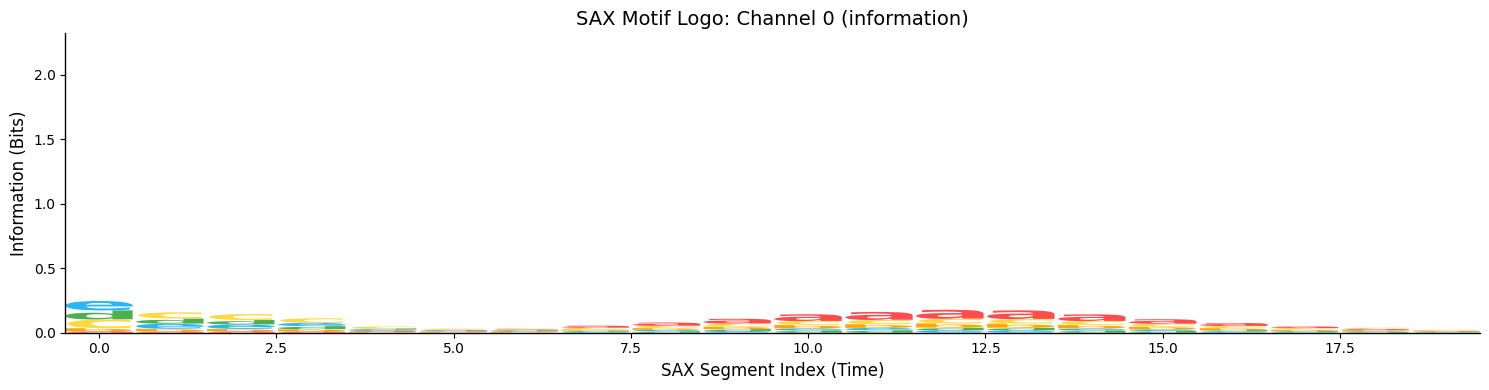

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.0506
Char 'b': -0.0506 to -0.0220
Char 'c': -0.0220 to -0.0086
Char 'd': -0.0086 to 0.0000
Char 'e': 0.0000 to 0.0086
Char 'f': 0.0086 to 0.0219
Char 'g': 0.0219 to 0.0506
Char 'h': 0.0506 to 2.2800


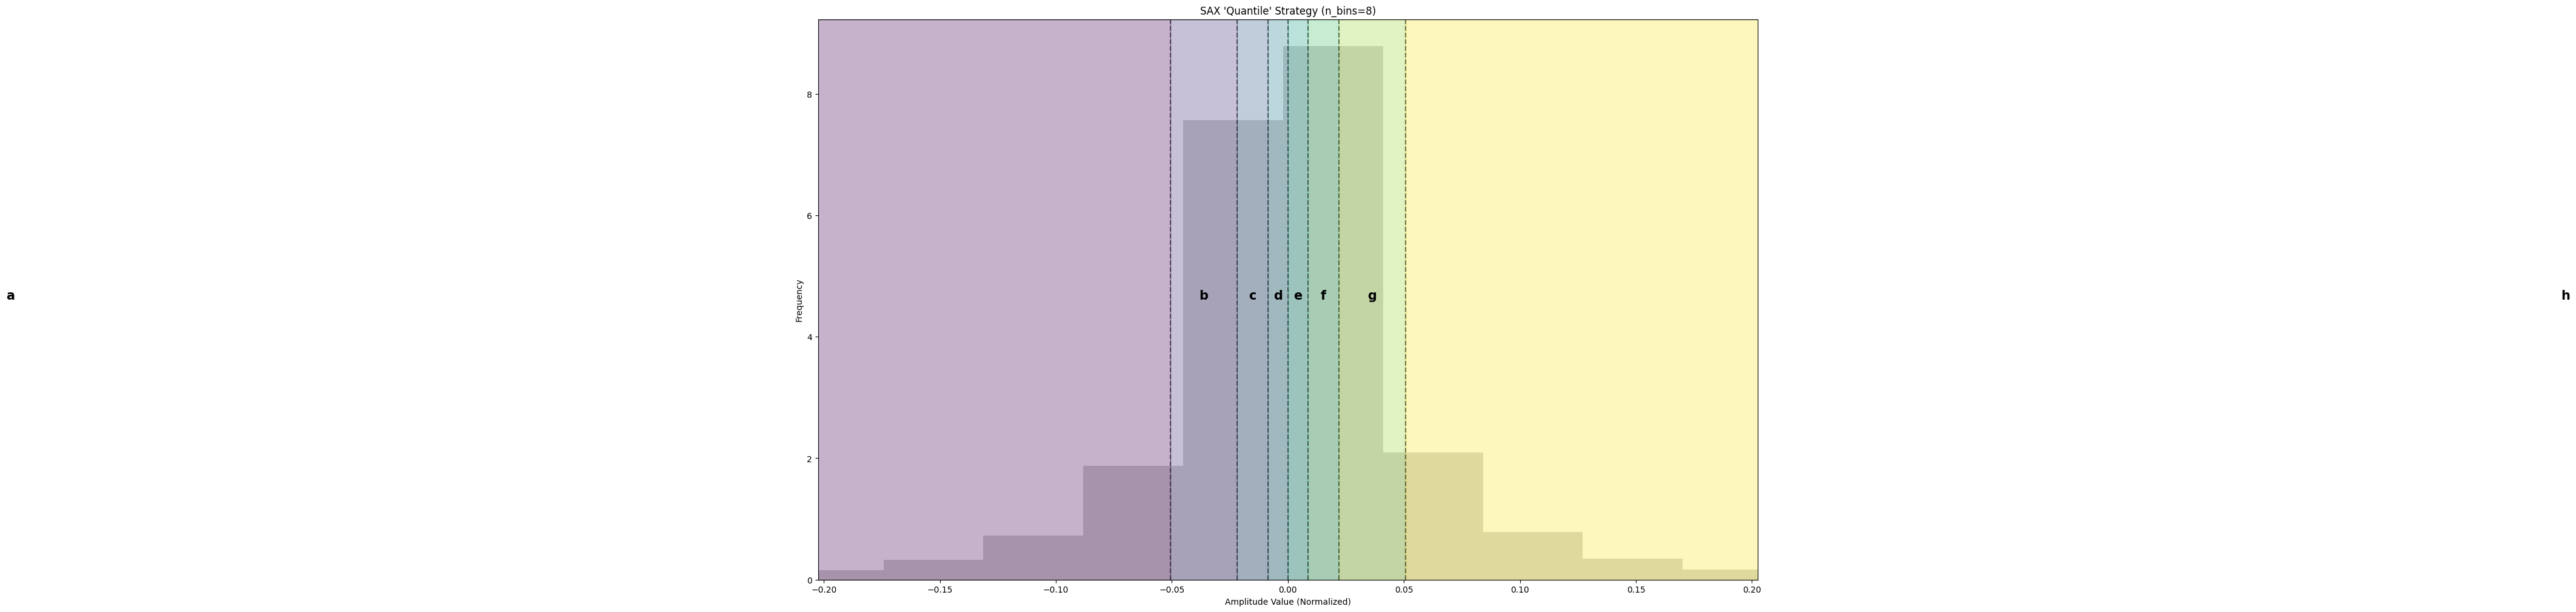

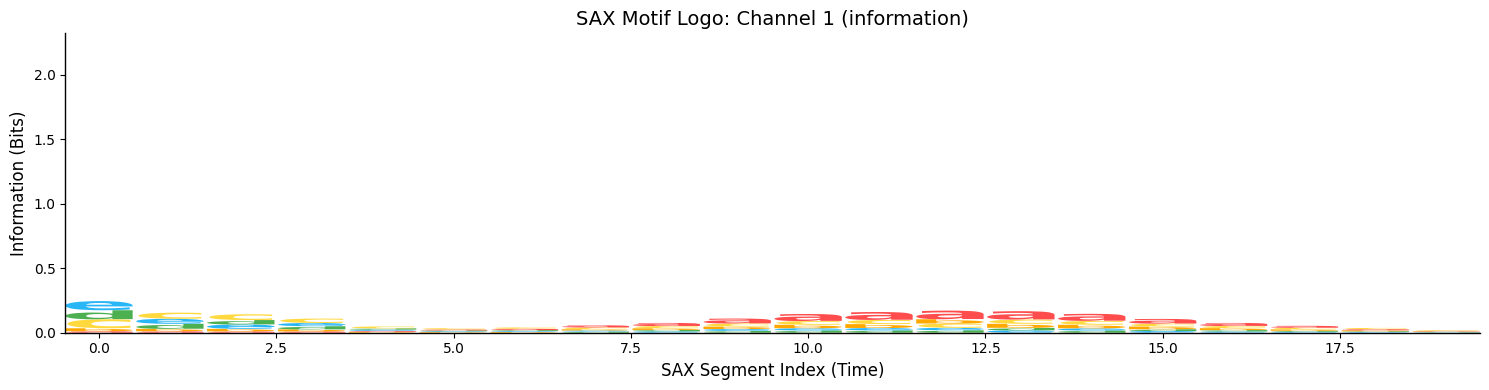

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.0506
Char 'b': -0.0506 to -0.0220
Char 'c': -0.0220 to -0.0086
Char 'd': -0.0086 to 0.0000
Char 'e': 0.0000 to 0.0086
Char 'f': 0.0086 to 0.0219
Char 'g': 0.0219 to 0.0506
Char 'h': 0.0506 to 2.2800


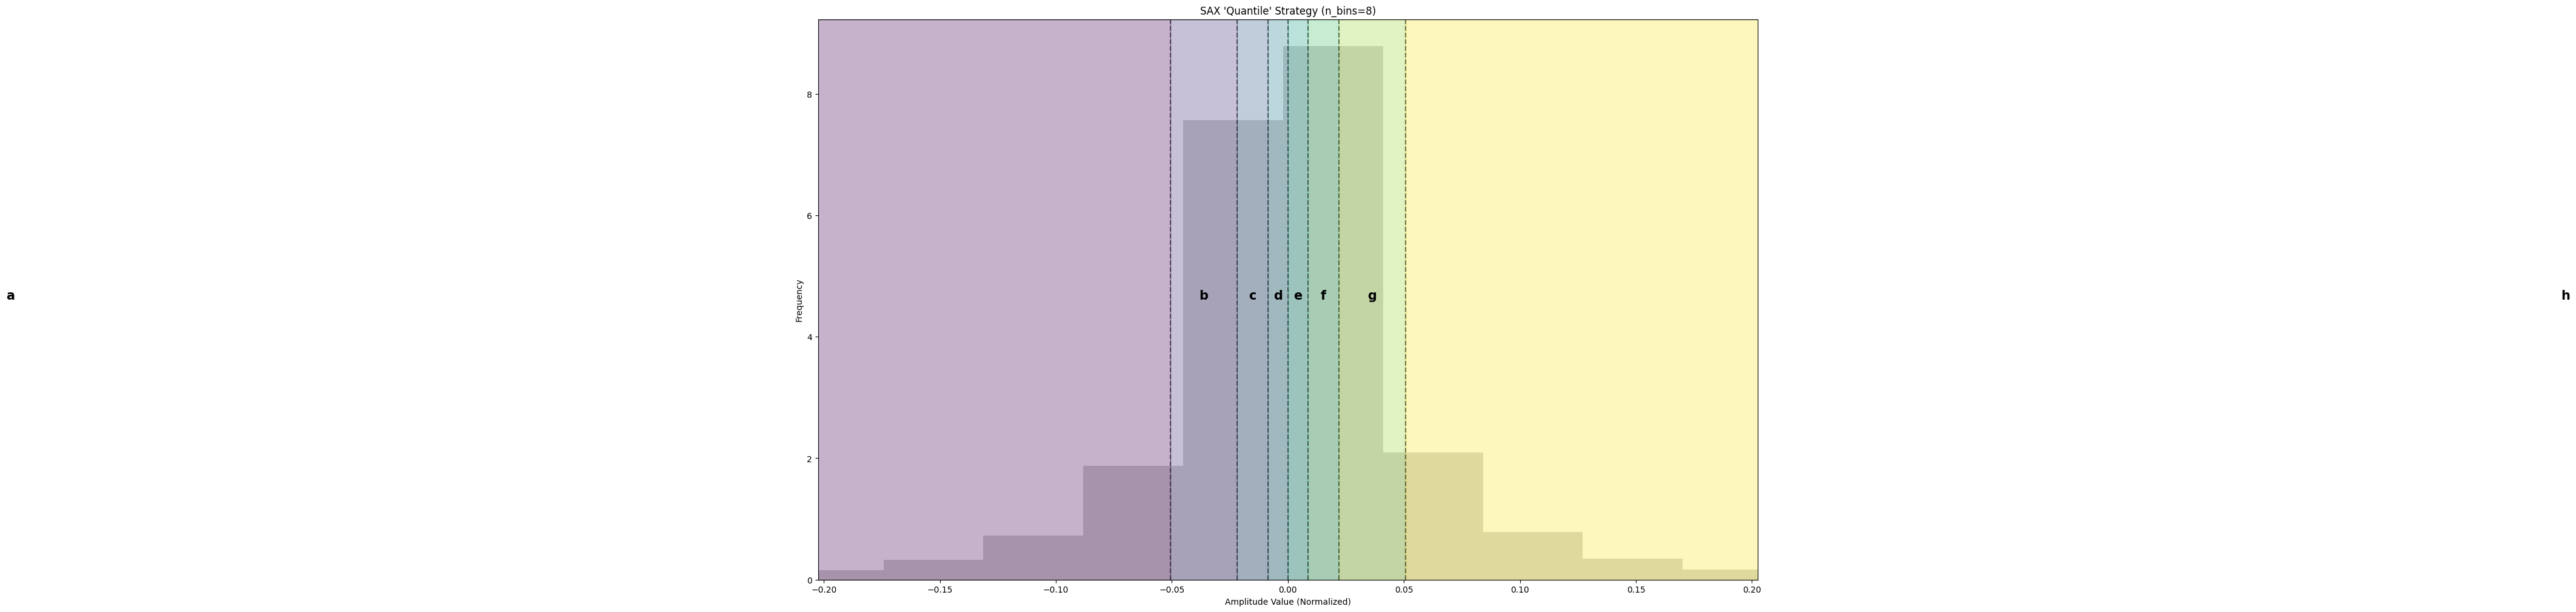

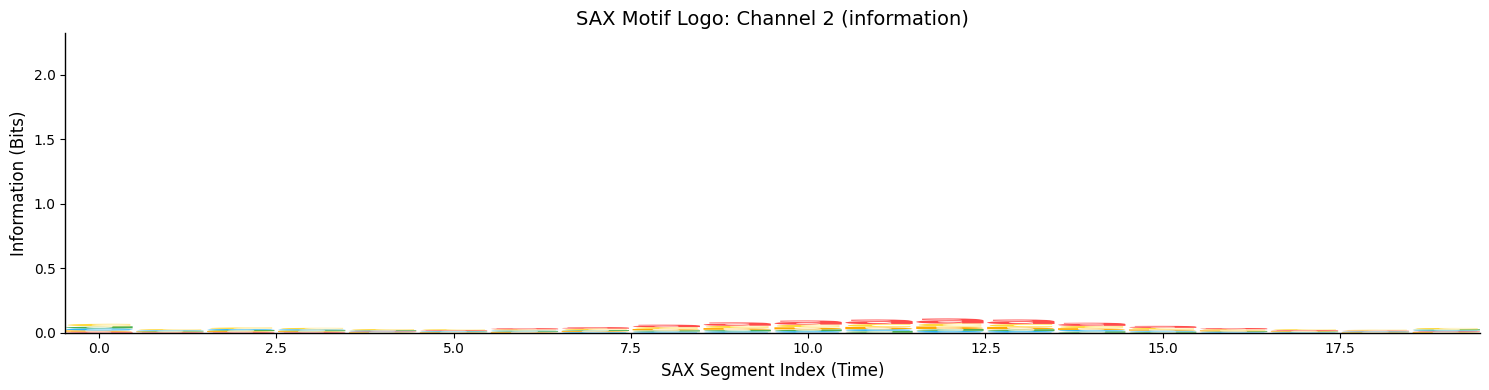

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.0506
Char 'b': -0.0506 to -0.0220
Char 'c': -0.0220 to -0.0086
Char 'd': -0.0086 to 0.0000
Char 'e': 0.0000 to 0.0086
Char 'f': 0.0086 to 0.0219
Char 'g': 0.0219 to 0.0506
Char 'h': 0.0506 to 2.2800


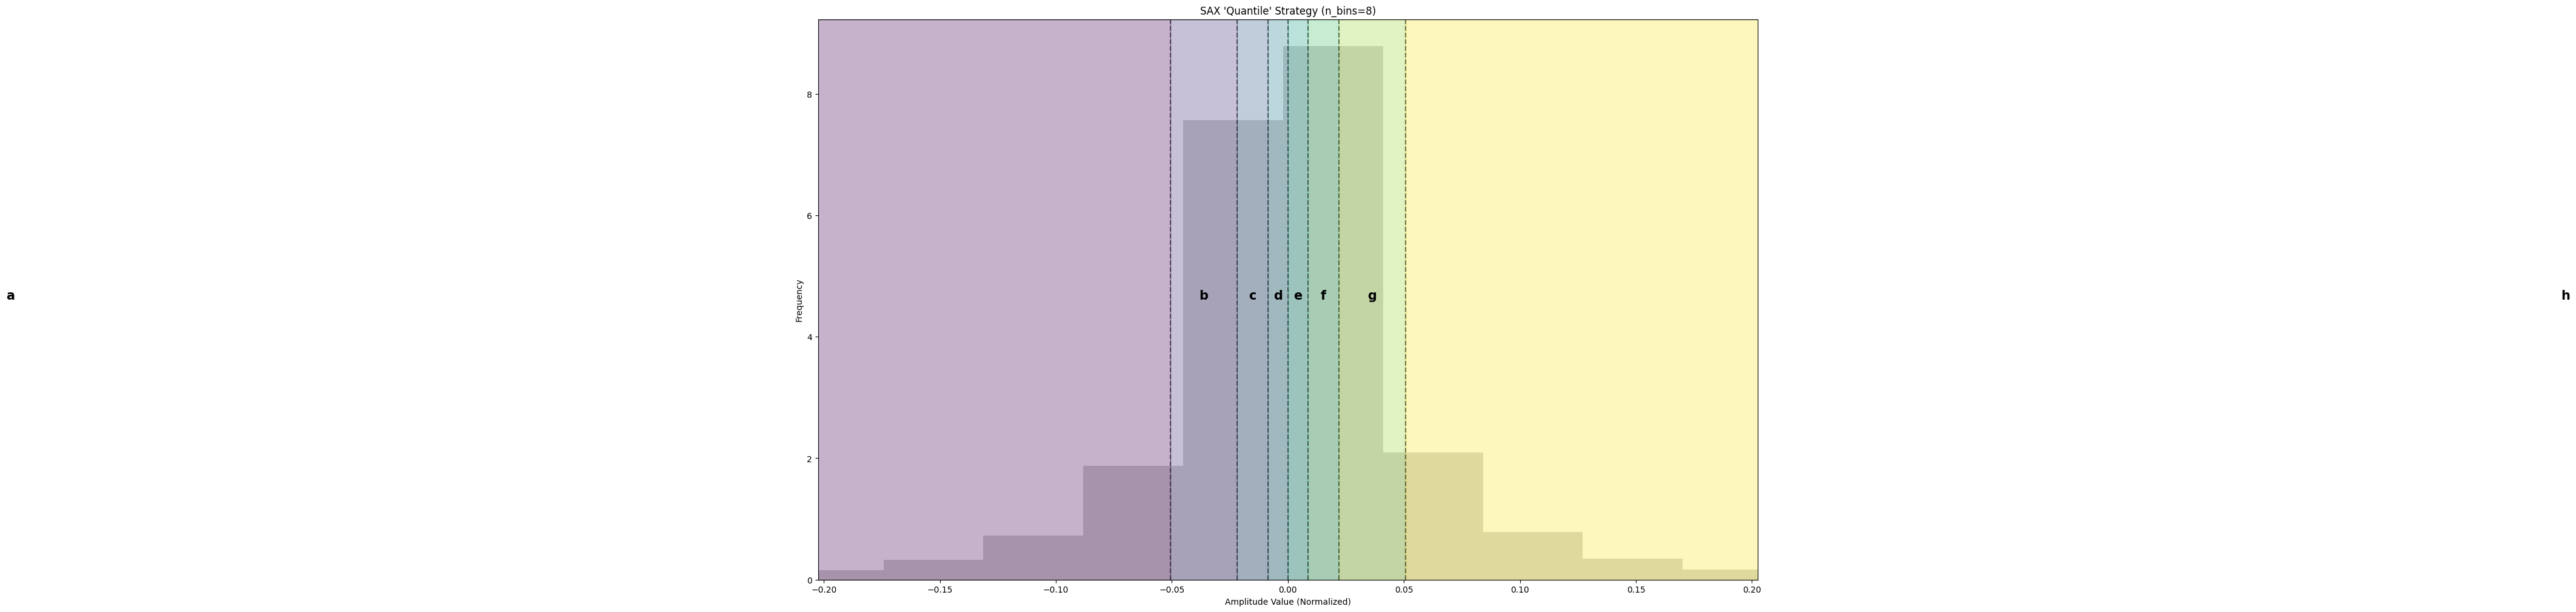

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 20)

--- Pattern Mining Input Check ---
Earthquake 0 String: hlaopacpfdmbkikgfjne|ogbkanhpailckdpefjfm|kfngappakcobdlfhijem


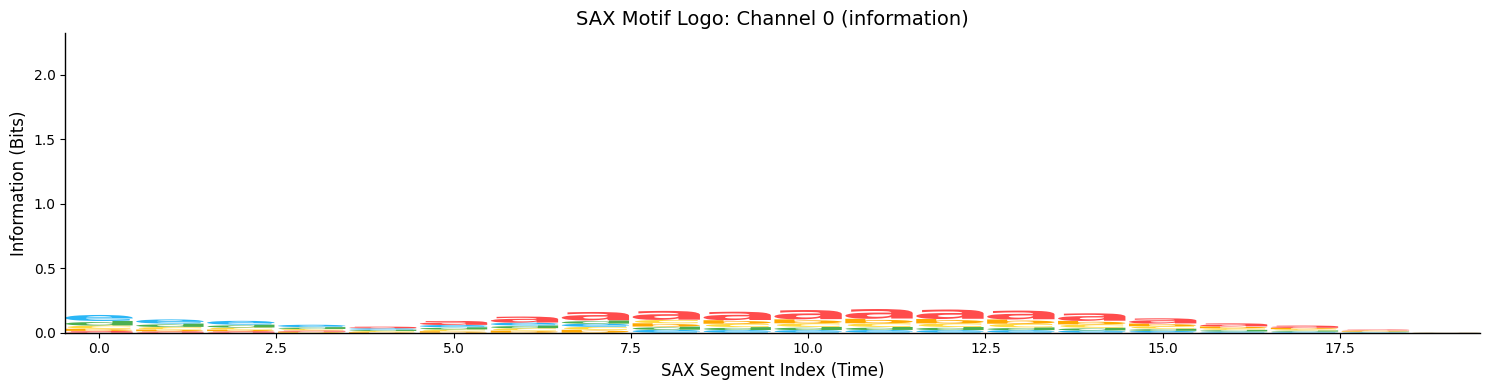

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.0859
Char 'b': -0.0859 to -0.0506
Char 'c': -0.0506 to -0.0330
Char 'd': -0.0330 to -0.0220
Char 'e': -0.0220 to -0.0143
Char 'f': -0.0143 to -0.0086
Char 'g': -0.0086 to -0.0040
Char 'h': -0.0040 to 0.0000
Char 'i': 0.0000 to 0.0040
Char 'j': 0.0040 to 0.0086
Char 'k': 0.0086 to 0.0143
Char 'l': 0.0143 to 0.0219
Char 'm': 0.0219 to 0.0329
Char 'n': 0.0329 to 0.0506
Char 'o': 0.0506 to 0.0858
Char 'p': 0.0858 to 2.2800


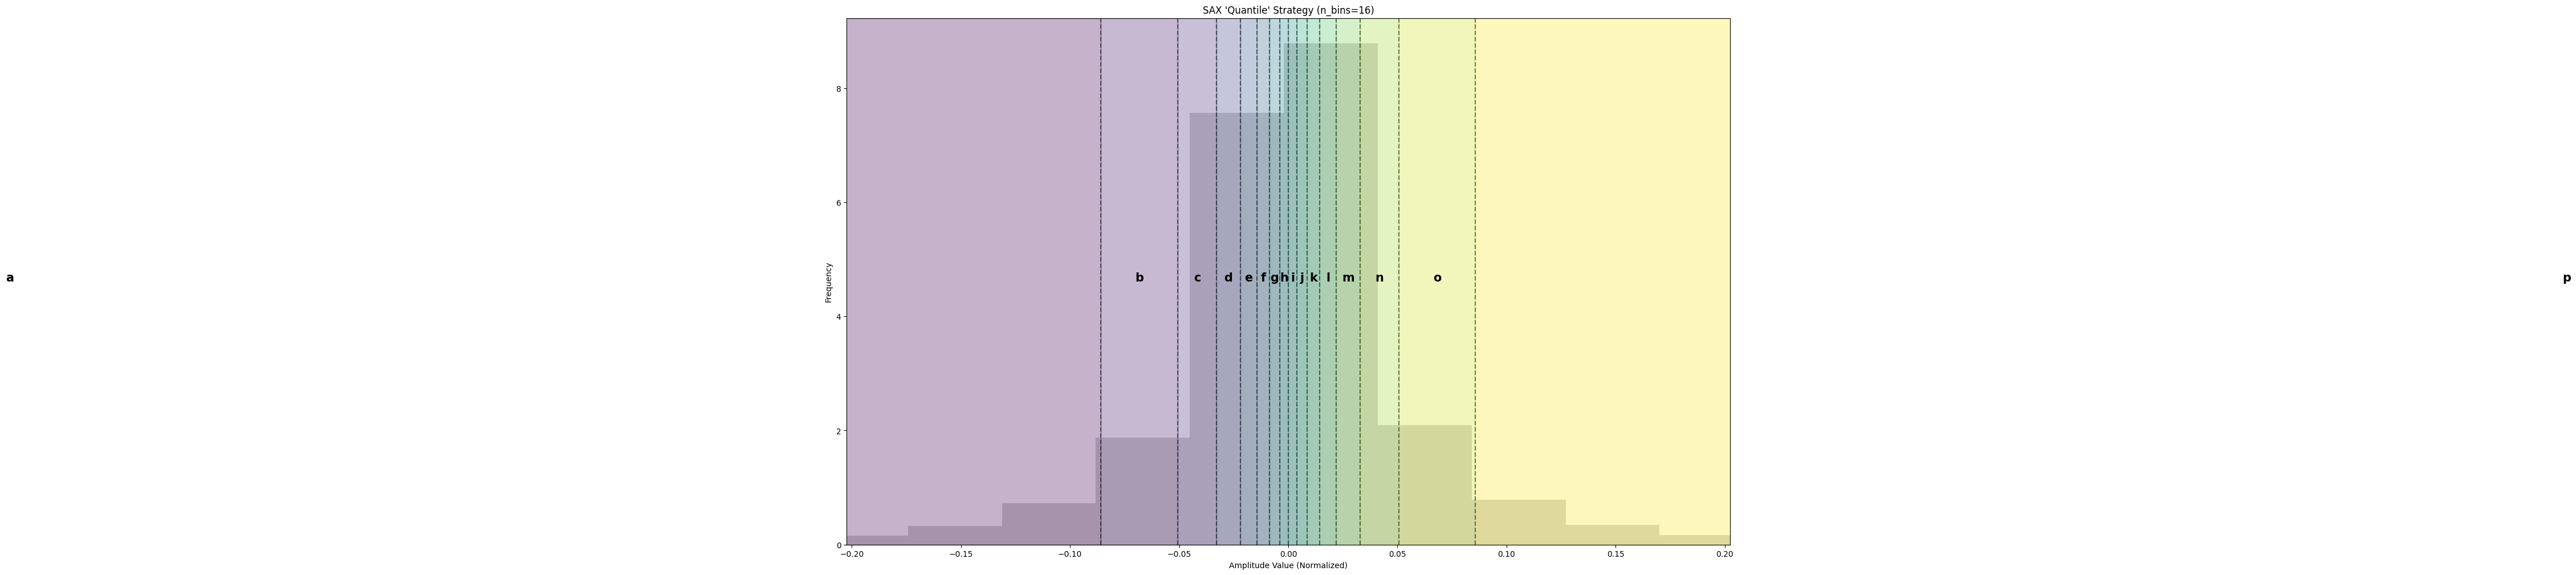

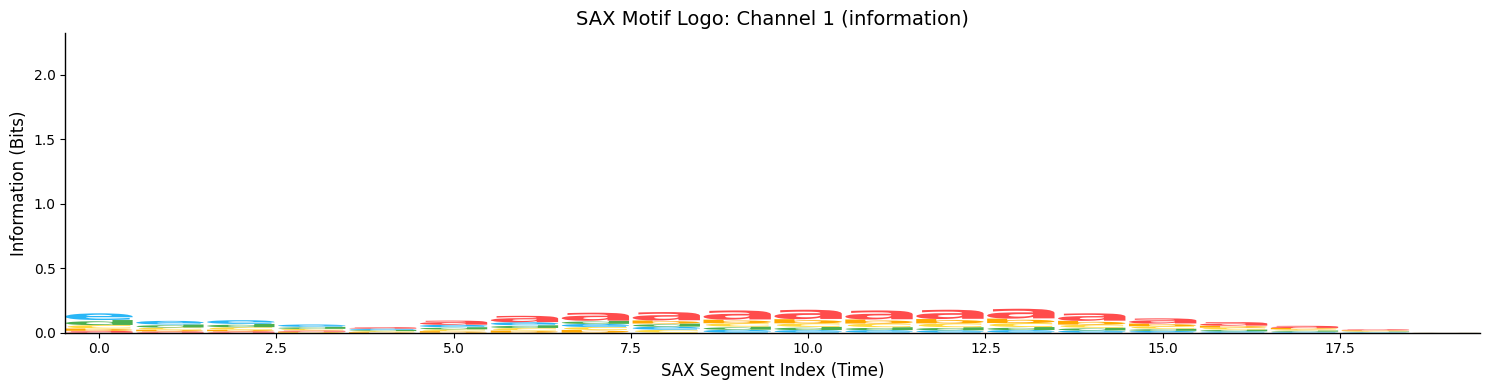

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.0859
Char 'b': -0.0859 to -0.0506
Char 'c': -0.0506 to -0.0330
Char 'd': -0.0330 to -0.0220
Char 'e': -0.0220 to -0.0143
Char 'f': -0.0143 to -0.0086
Char 'g': -0.0086 to -0.0040
Char 'h': -0.0040 to 0.0000
Char 'i': 0.0000 to 0.0040
Char 'j': 0.0040 to 0.0086
Char 'k': 0.0086 to 0.0143
Char 'l': 0.0143 to 0.0219
Char 'm': 0.0219 to 0.0329
Char 'n': 0.0329 to 0.0506
Char 'o': 0.0506 to 0.0858
Char 'p': 0.0858 to 2.2800


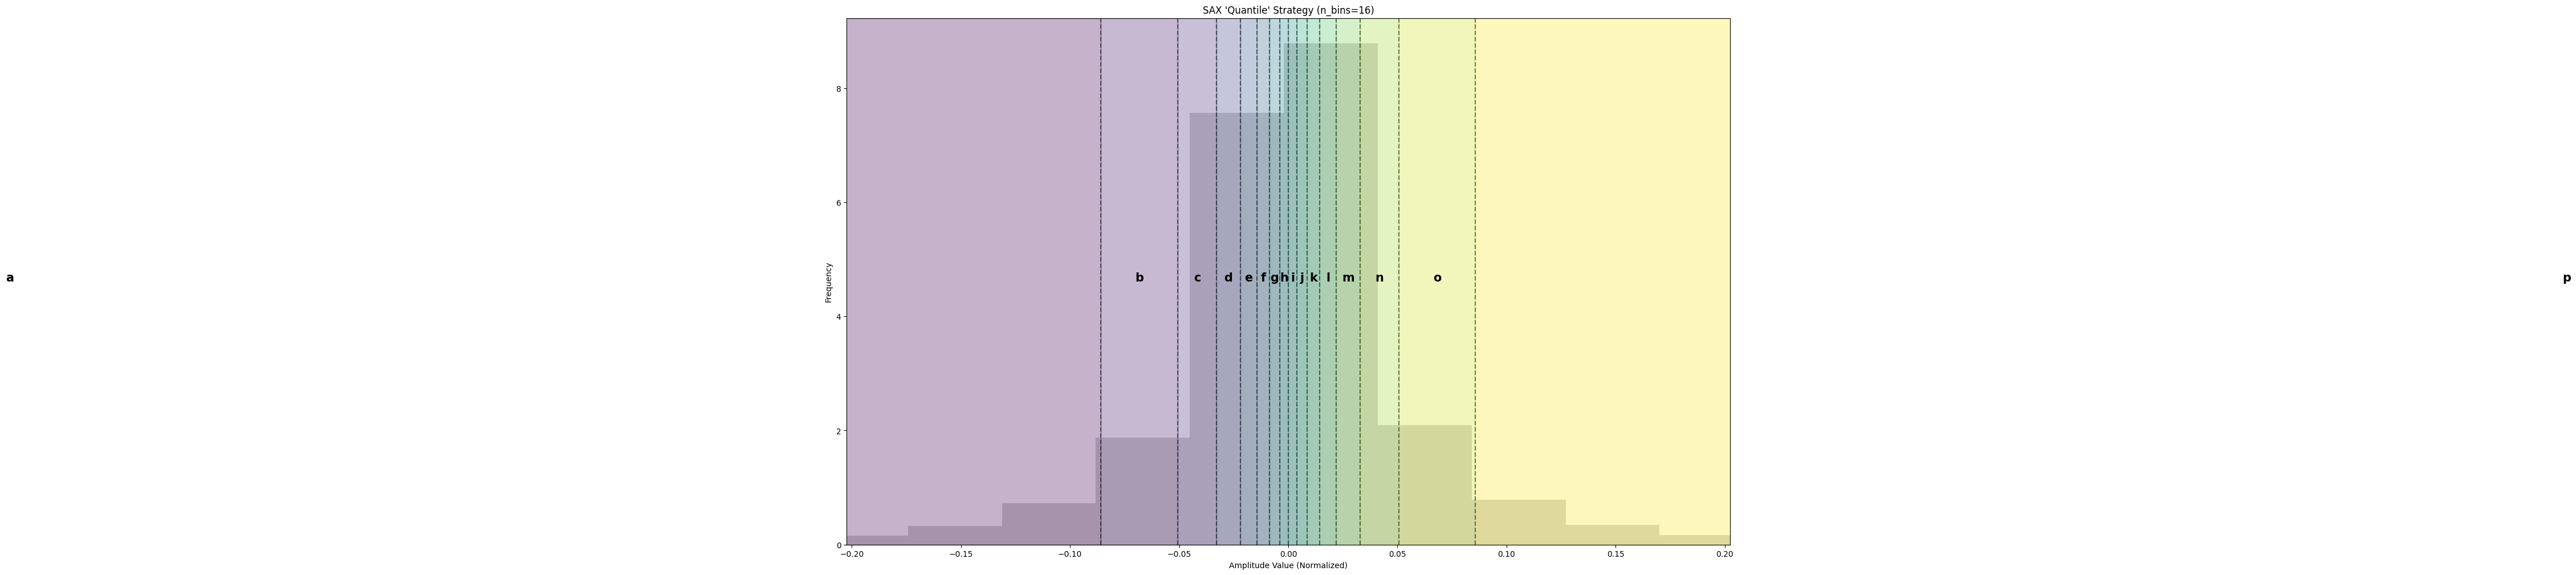

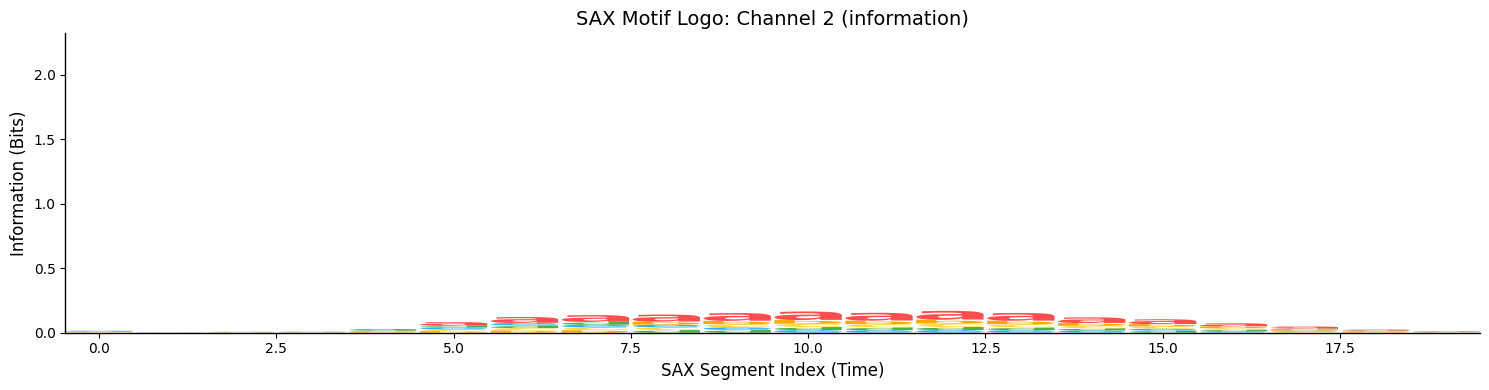

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.0859
Char 'b': -0.0859 to -0.0506
Char 'c': -0.0506 to -0.0330
Char 'd': -0.0330 to -0.0220
Char 'e': -0.0220 to -0.0143
Char 'f': -0.0143 to -0.0086
Char 'g': -0.0086 to -0.0040
Char 'h': -0.0040 to 0.0000
Char 'i': 0.0000 to 0.0040
Char 'j': 0.0040 to 0.0086
Char 'k': 0.0086 to 0.0143
Char 'l': 0.0143 to 0.0219
Char 'm': 0.0219 to 0.0329
Char 'n': 0.0329 to 0.0506
Char 'o': 0.0506 to 0.0858
Char 'p': 0.0858 to 2.2800


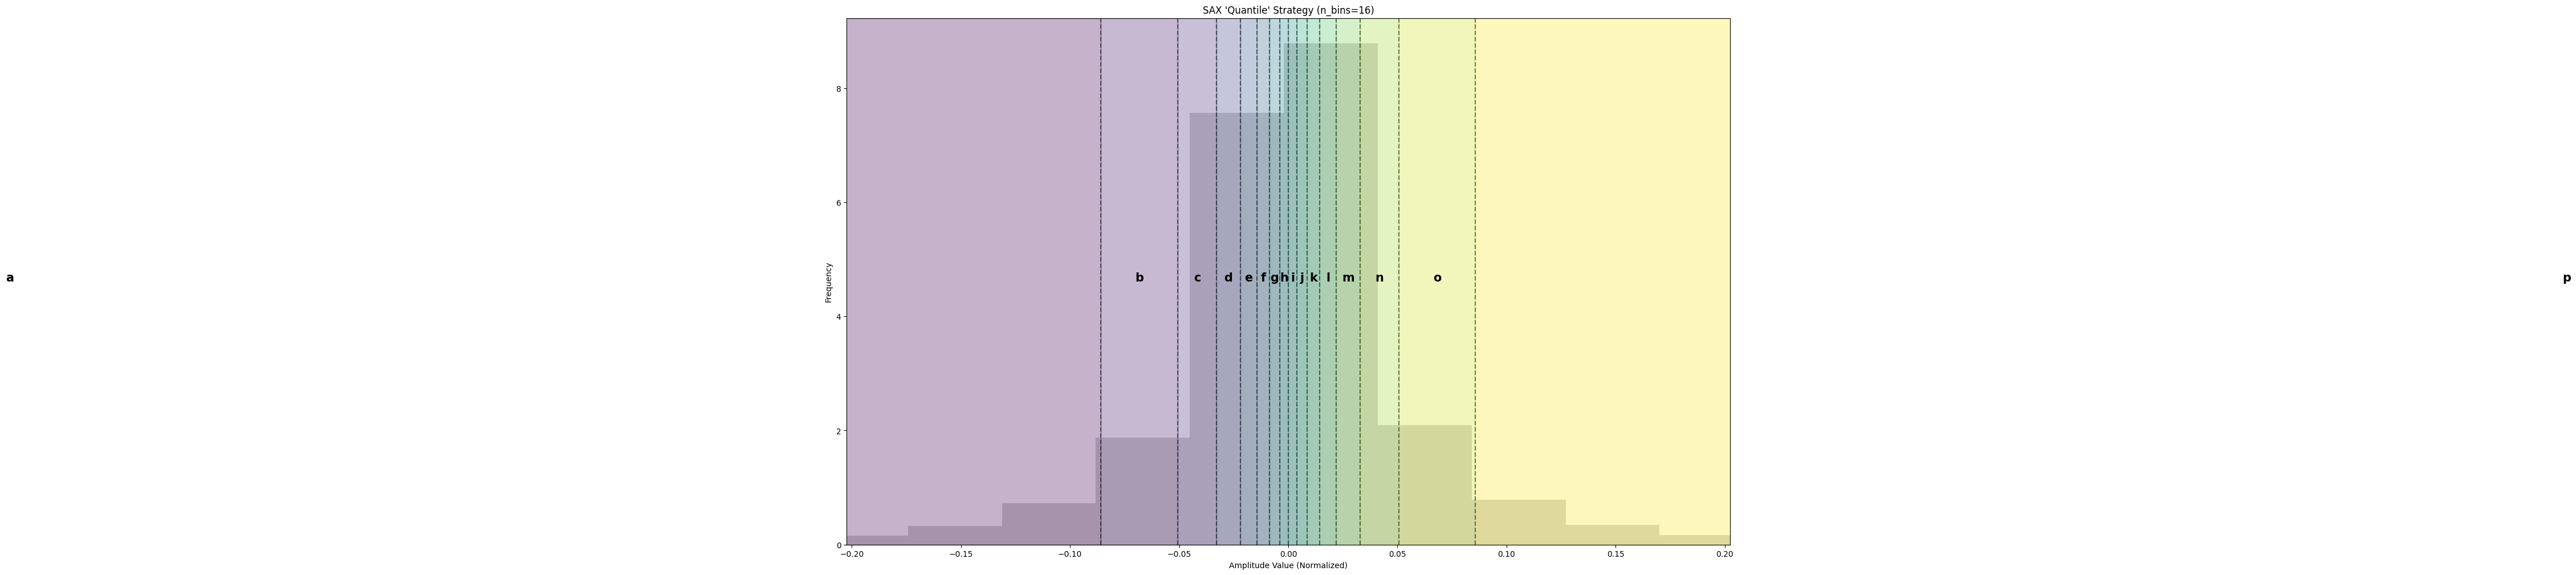

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [ 5250 40231 47814 47815 54384 54385 54387 54388 54390 54427 62740]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 20)

--- Pattern Mining Input Check ---
Earthquake 0 String: lrbvxadwifscqmpkhnug|vkcqaulxbmrdpfwghnis|piukawxbqdvcfrhlmngs


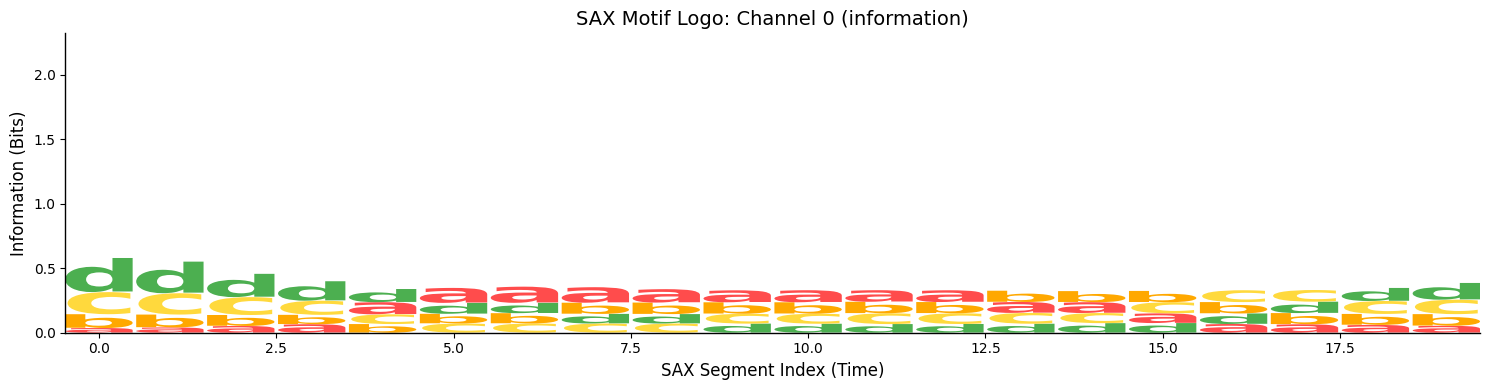

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.1089
Char 'b': -0.1089 to -0.0705
Char 'c': -0.0705 to -0.0506
Char 'd': -0.0506 to -0.0379
Char 'e': -0.0379 to -0.0288
Char 'f': -0.0288 to -0.0220
Char 'g': -0.0220 to -0.0166
Char 'h': -0.0166 to -0.0122
Char 'i': -0.0122 to -0.0086
Char 'j': -0.0086 to -0.0054
Char 'k': -0.0054 to -0.0026
Char 'l': -0.0026 to 0.0000
Char 'm': 0.0000 to 0.0026
Char 'n': 0.0026 to 0.0054
Char 'o': 0.0054 to 0.0086
Char 'p': 0.0086 to 0.0122
Char 'q': 0.0122 to 0.0166
Char 'r': 0.0166 to 0.0219
Char 's': 0.0219 to 0.0287
Char 't': 0.0287 to 0.0378
Char 'u': 0.0378 to 0.0506
Char 'v': 0.0506 to 0.0705
Char 'w': 0.0705 to 0.1088
Char 'x': 0.1088 to 2.2800


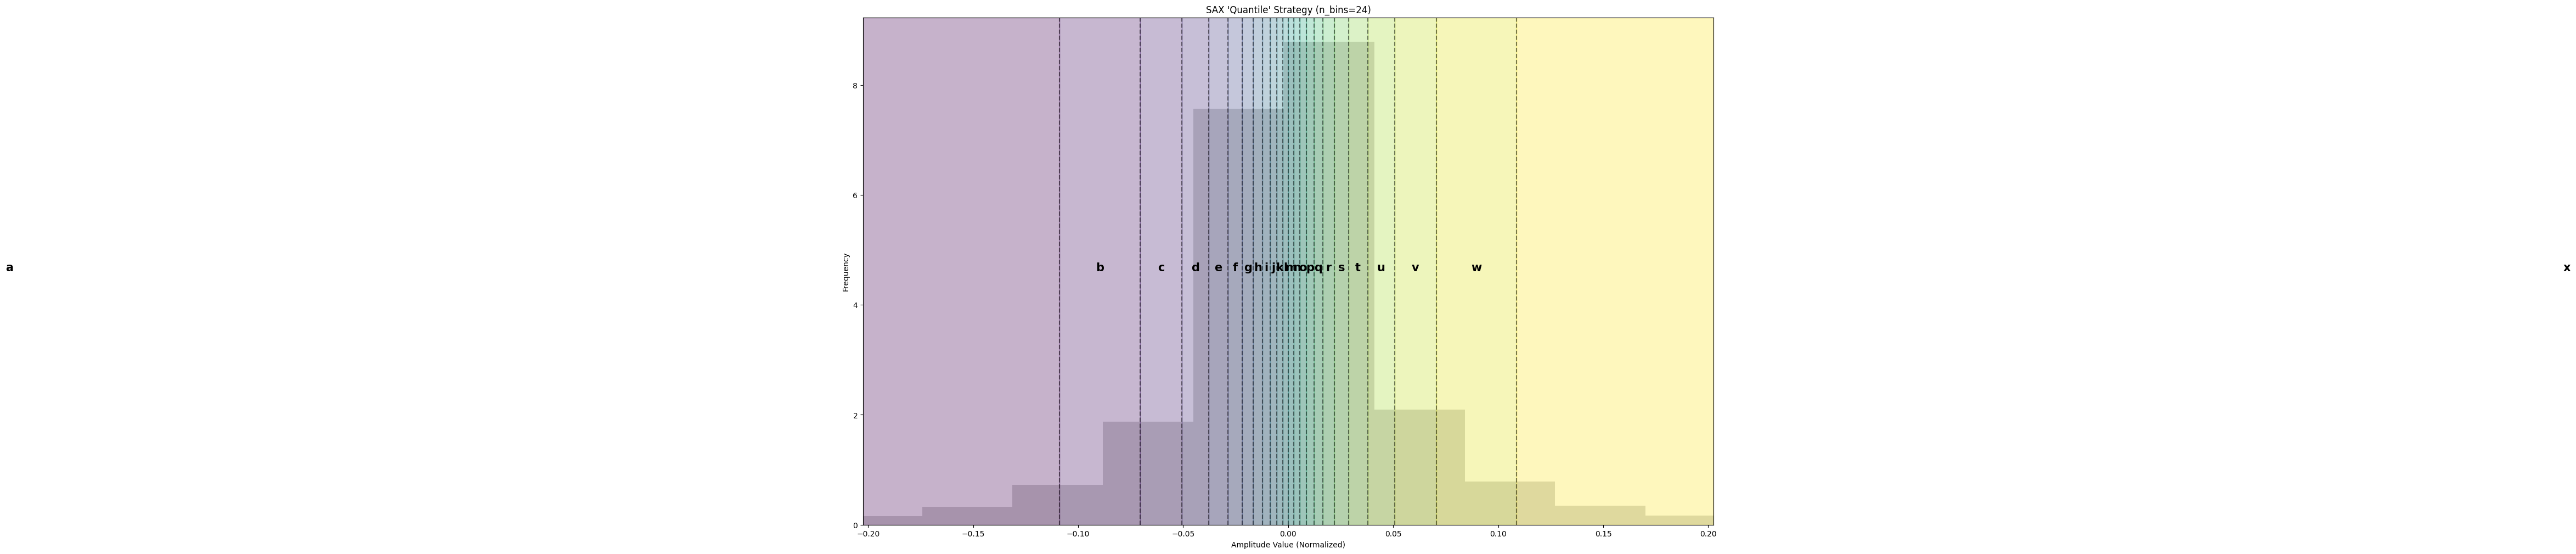

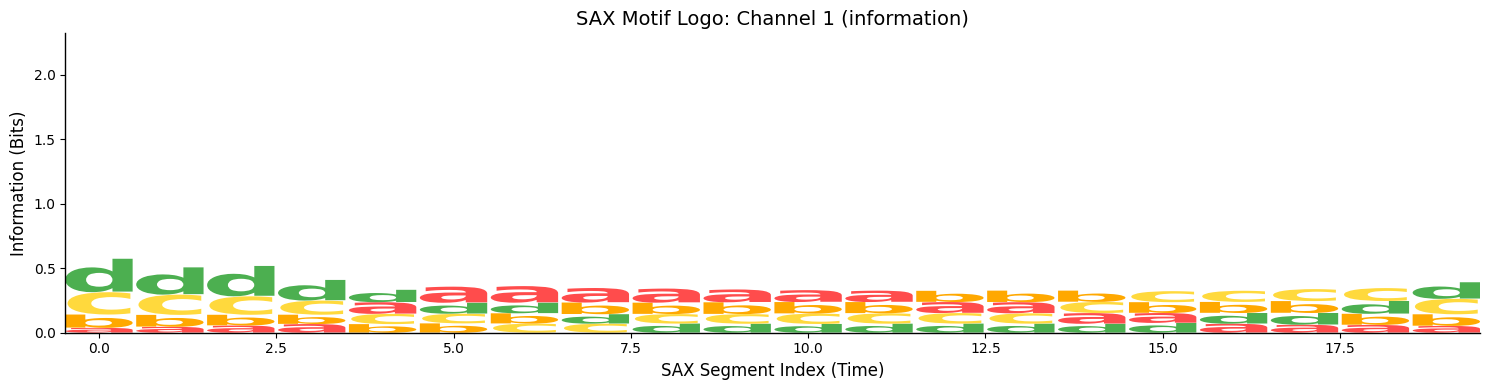

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.1089
Char 'b': -0.1089 to -0.0705
Char 'c': -0.0705 to -0.0506
Char 'd': -0.0506 to -0.0379
Char 'e': -0.0379 to -0.0288
Char 'f': -0.0288 to -0.0220
Char 'g': -0.0220 to -0.0166
Char 'h': -0.0166 to -0.0122
Char 'i': -0.0122 to -0.0086
Char 'j': -0.0086 to -0.0054
Char 'k': -0.0054 to -0.0026
Char 'l': -0.0026 to 0.0000
Char 'm': 0.0000 to 0.0026
Char 'n': 0.0026 to 0.0054
Char 'o': 0.0054 to 0.0086
Char 'p': 0.0086 to 0.0122
Char 'q': 0.0122 to 0.0166
Char 'r': 0.0166 to 0.0219
Char 's': 0.0219 to 0.0287
Char 't': 0.0287 to 0.0378
Char 'u': 0.0378 to 0.0506
Char 'v': 0.0506 to 0.0705
Char 'w': 0.0705 to 0.1088
Char 'x': 0.1088 to 2.2800


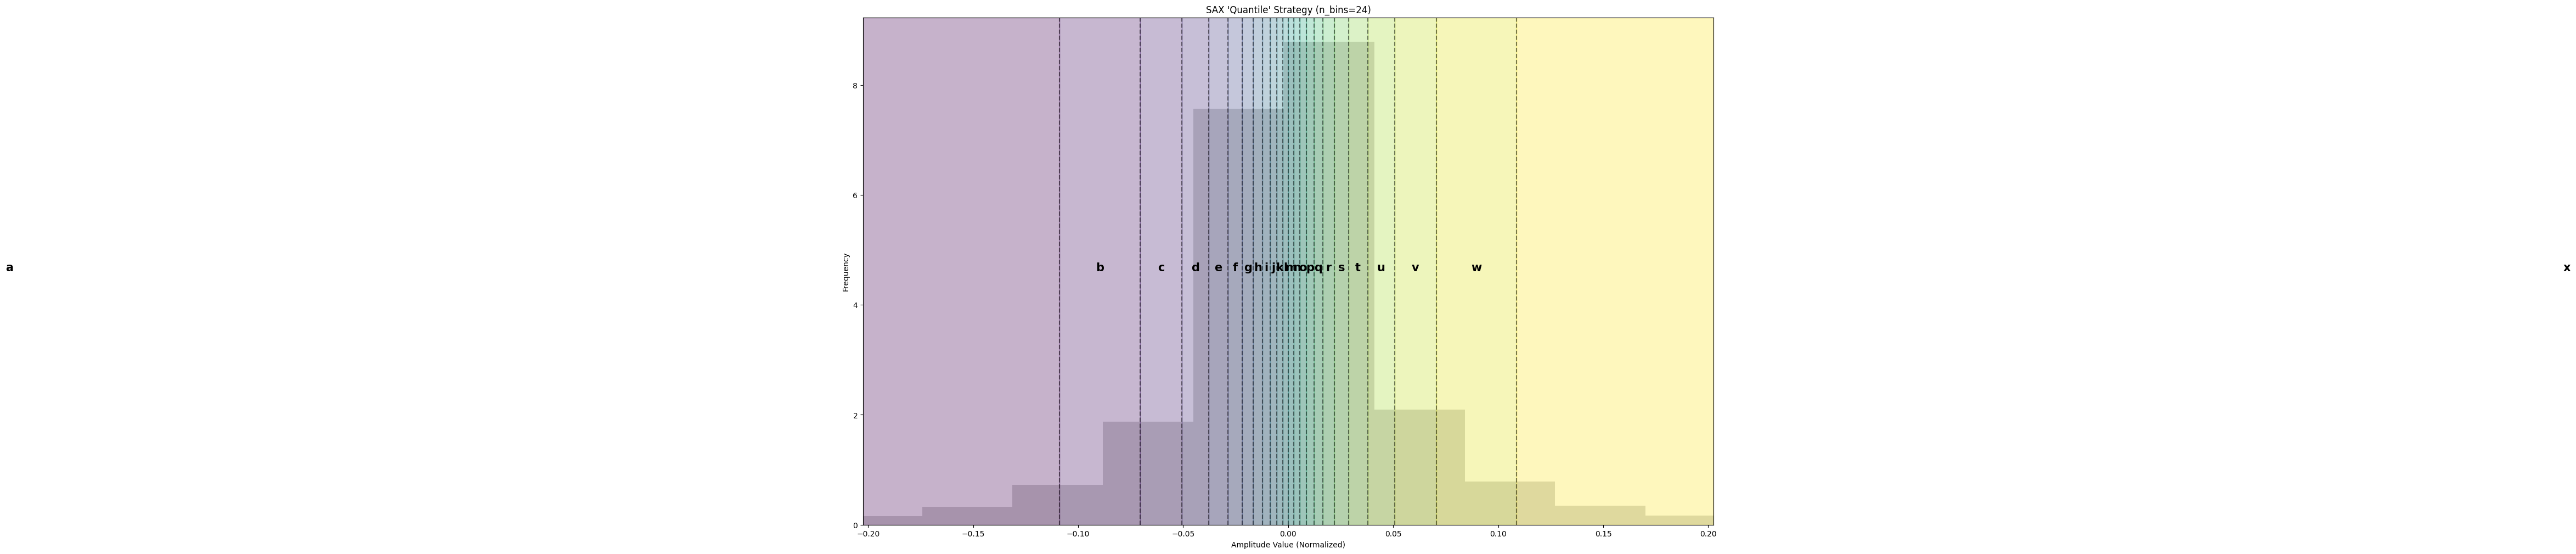

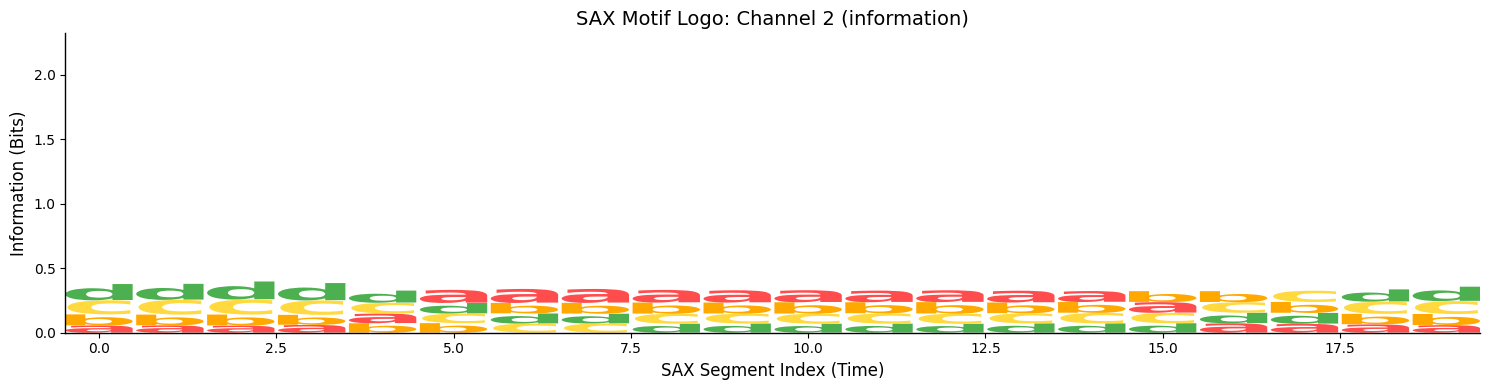

--- Learned Quantile Thresholds ---
Char 'a': -2.0258 to -0.1089
Char 'b': -0.1089 to -0.0705
Char 'c': -0.0705 to -0.0506
Char 'd': -0.0506 to -0.0379
Char 'e': -0.0379 to -0.0288
Char 'f': -0.0288 to -0.0220
Char 'g': -0.0220 to -0.0166
Char 'h': -0.0166 to -0.0122
Char 'i': -0.0122 to -0.0086
Char 'j': -0.0086 to -0.0054
Char 'k': -0.0054 to -0.0026
Char 'l': -0.0026 to 0.0000
Char 'm': 0.0000 to 0.0026
Char 'n': 0.0026 to 0.0054
Char 'o': 0.0054 to 0.0086
Char 'p': 0.0086 to 0.0122
Char 'q': 0.0122 to 0.0166
Char 'r': 0.0166 to 0.0219
Char 's': 0.0219 to 0.0287
Char 't': 0.0287 to 0.0378
Char 'u': 0.0378 to 0.0506
Char 'v': 0.0506 to 0.0705
Char 'w': 0.0705 to 0.1088
Char 'x': 0.1088 to 2.2800


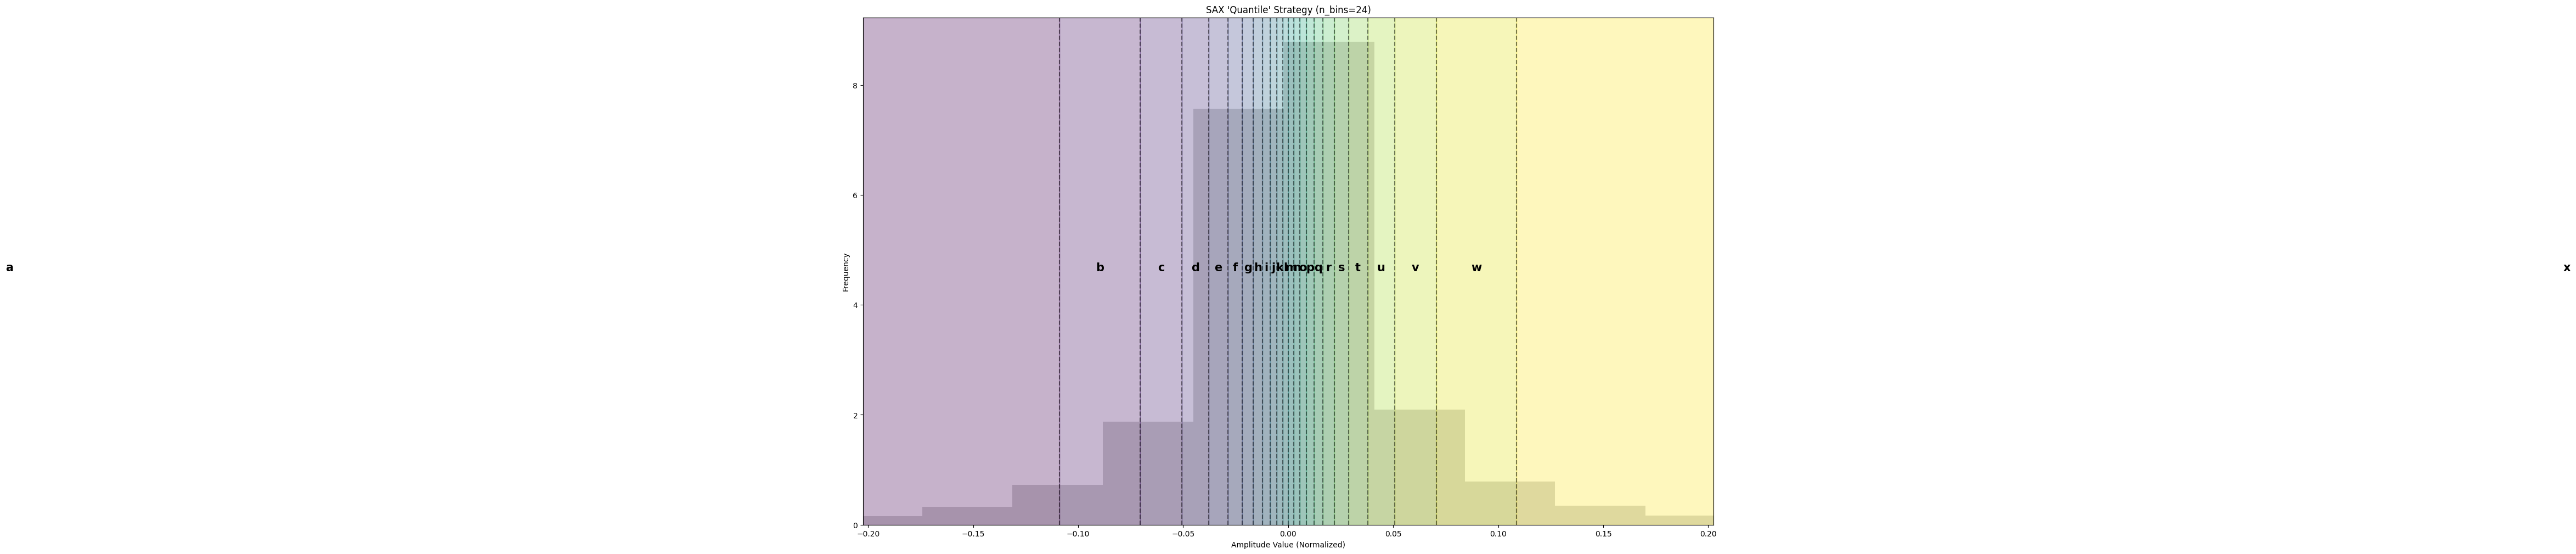

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 50)

--- Pattern Mining Input Check ---
Earthquake 0 String: bgccgbfdefachadgcahehahagfgahahddcfgbebfchbededbfe|gbbgeaegbdbhhahhachfaghdabffhadgfeagccfccefbecddde|gabhagcdcgdhhaahdbahefhaagchbeddfbgfcecceegbfbfdef


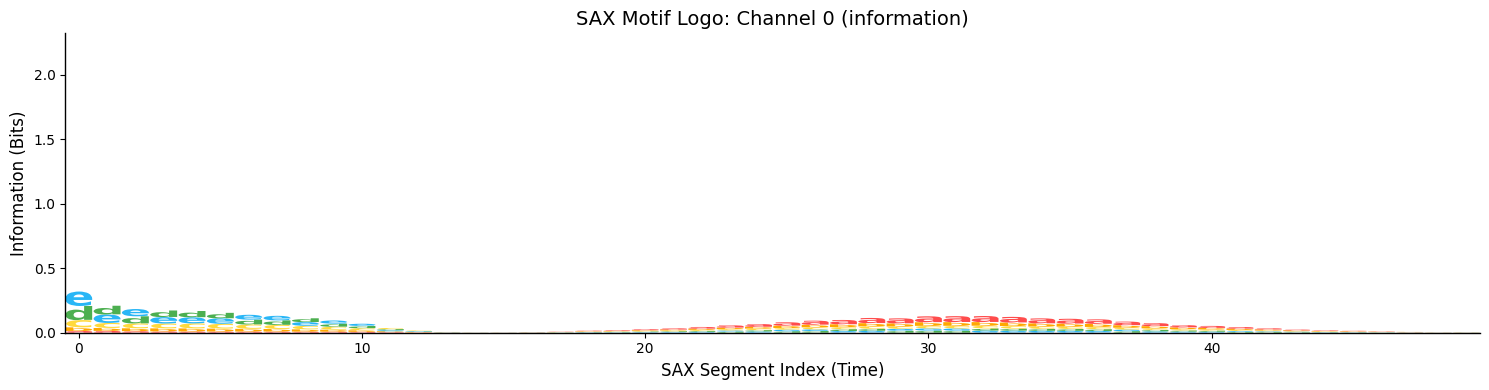

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.1273
Char 'b': -0.1273 to -0.0546
Char 'c': -0.0546 to -0.0211
Char 'd': -0.0211 to -0.0000
Char 'e': -0.0000 to 0.0211
Char 'f': 0.0211 to 0.0547
Char 'g': 0.0547 to 0.1273
Char 'h': 0.1273 to 5.4734


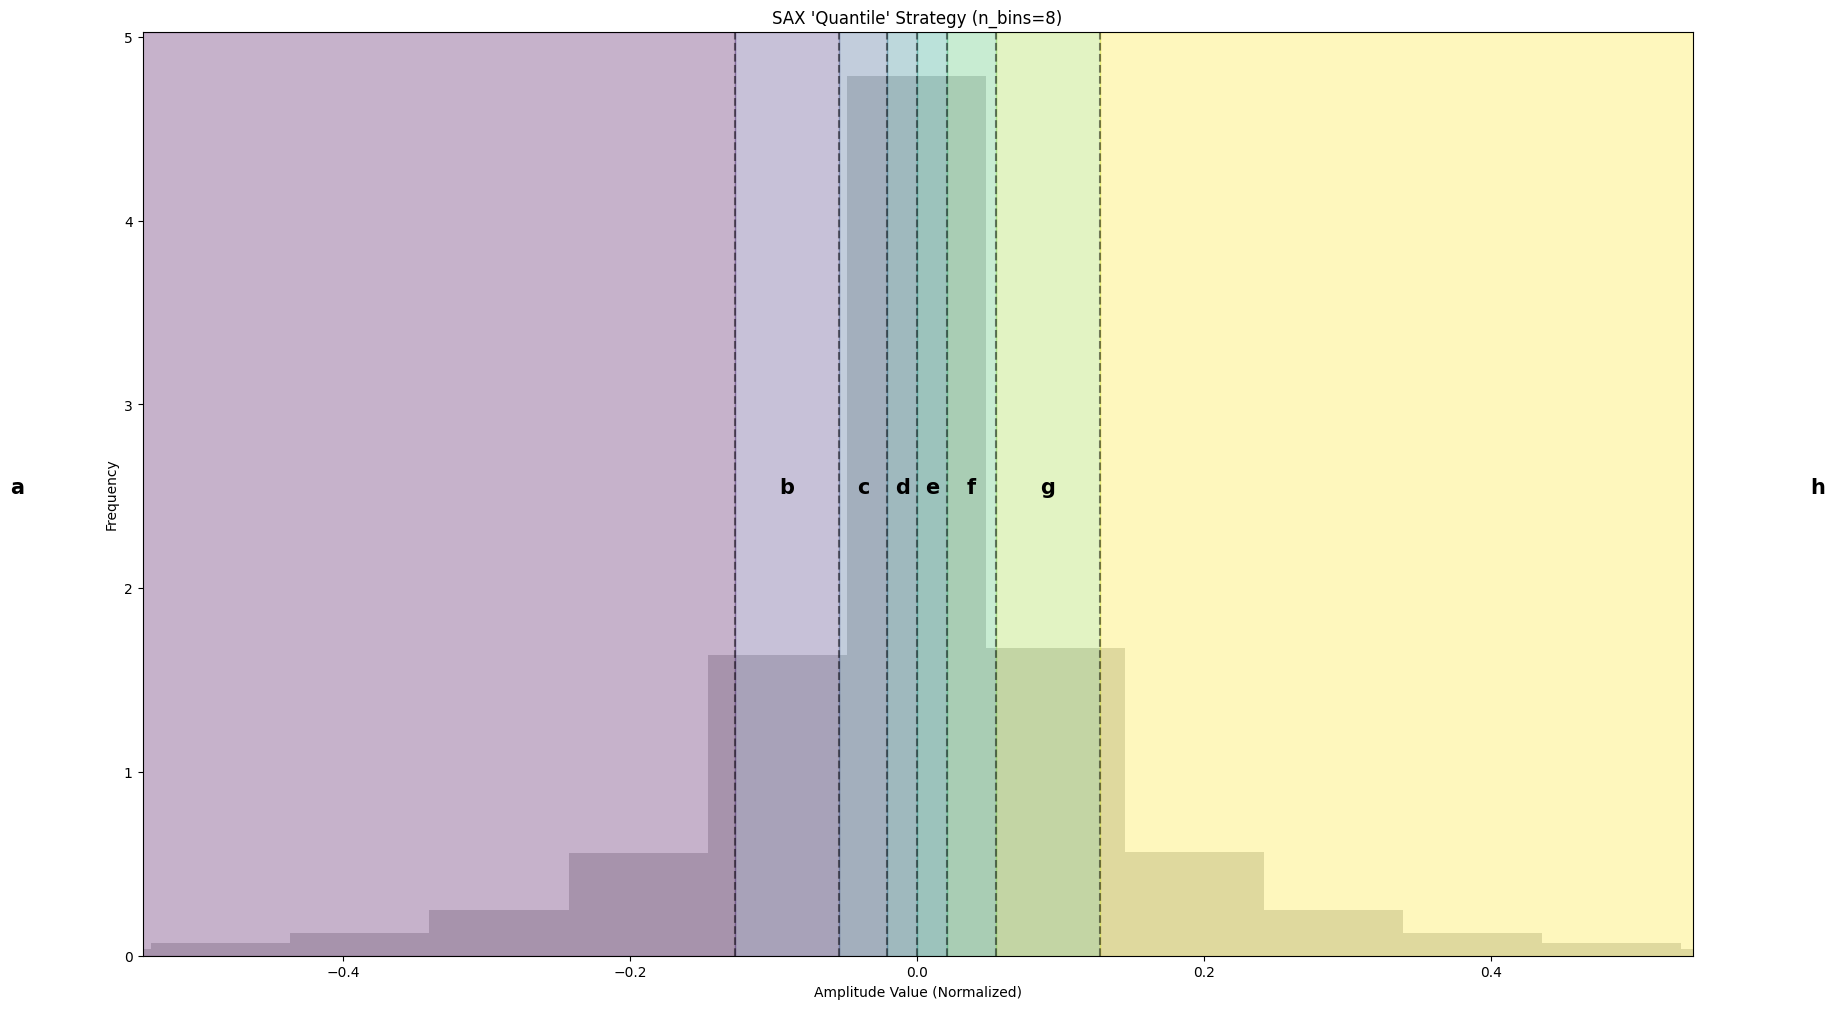

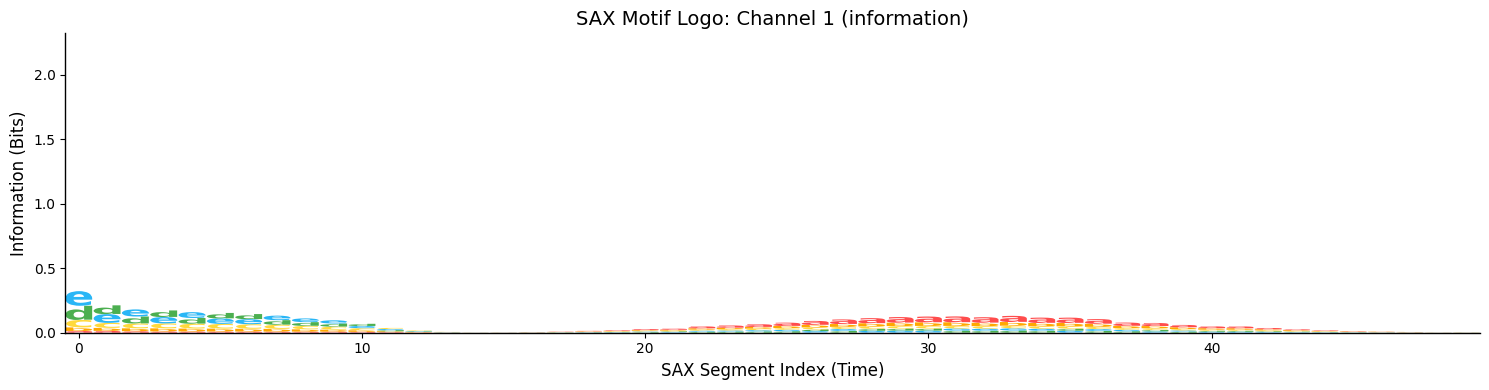

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.1273
Char 'b': -0.1273 to -0.0546
Char 'c': -0.0546 to -0.0211
Char 'd': -0.0211 to -0.0000
Char 'e': -0.0000 to 0.0211
Char 'f': 0.0211 to 0.0547
Char 'g': 0.0547 to 0.1273
Char 'h': 0.1273 to 5.4734


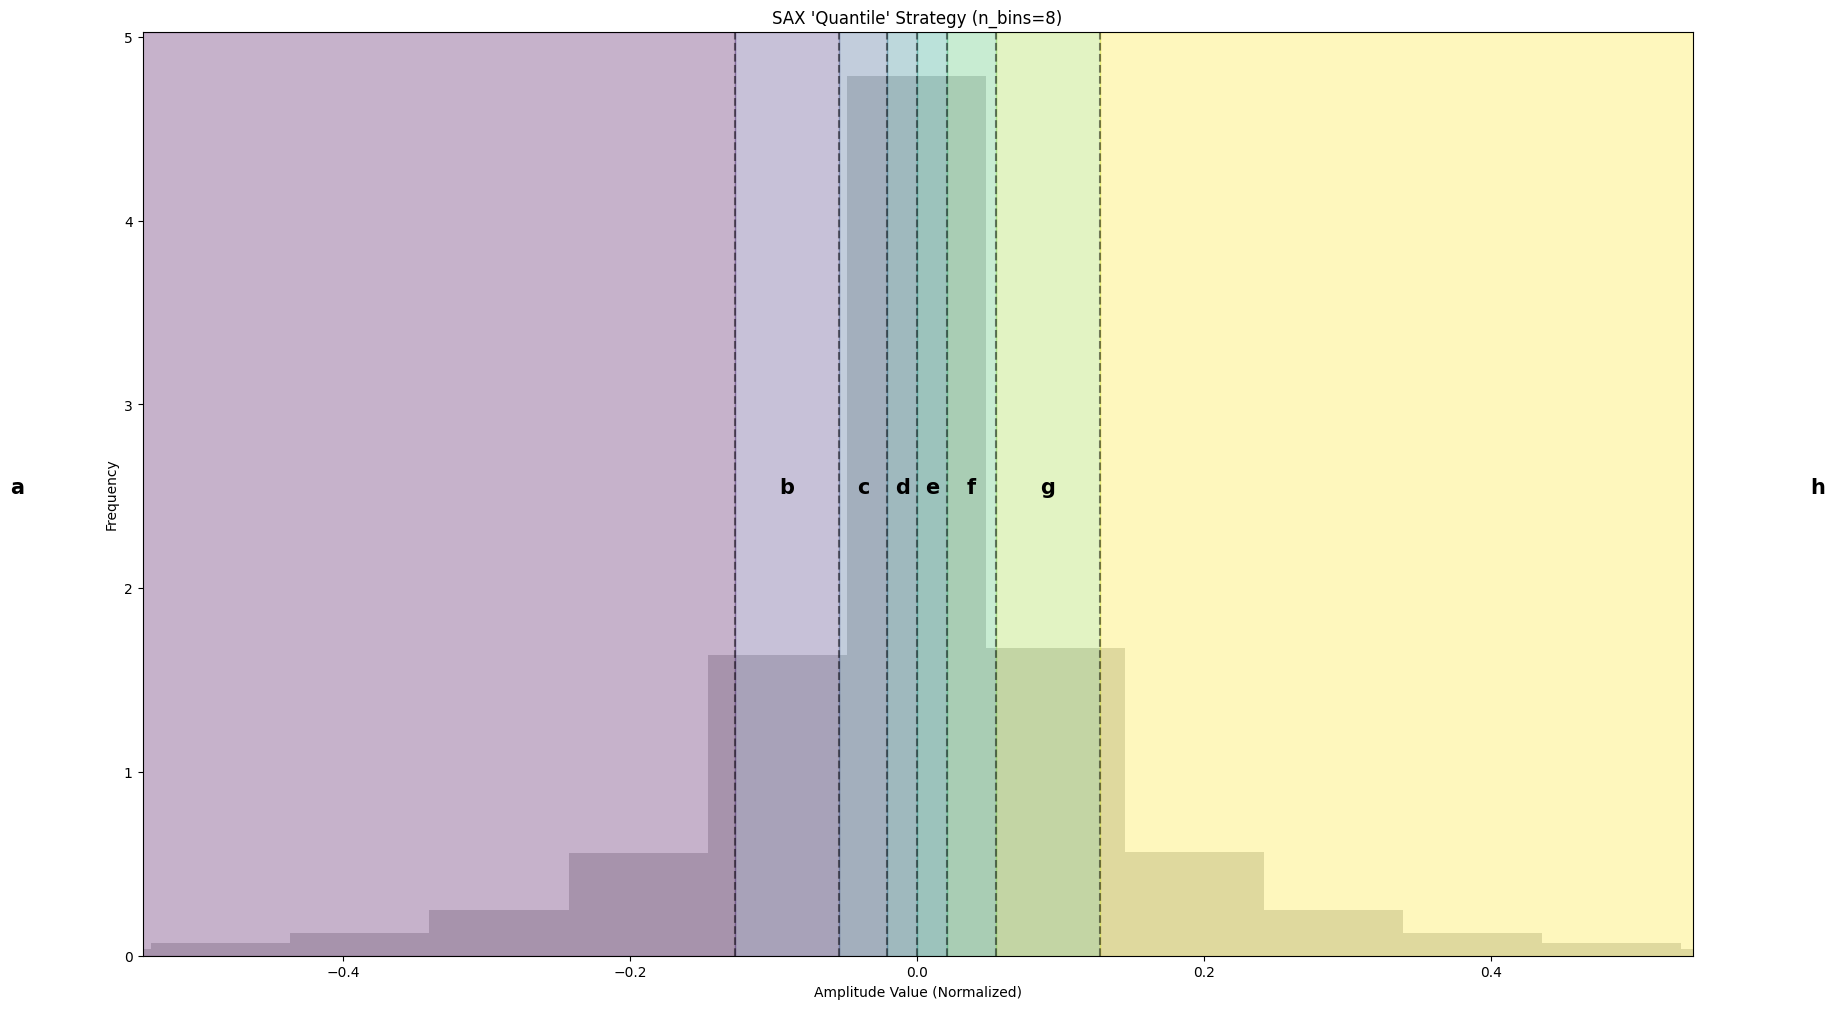

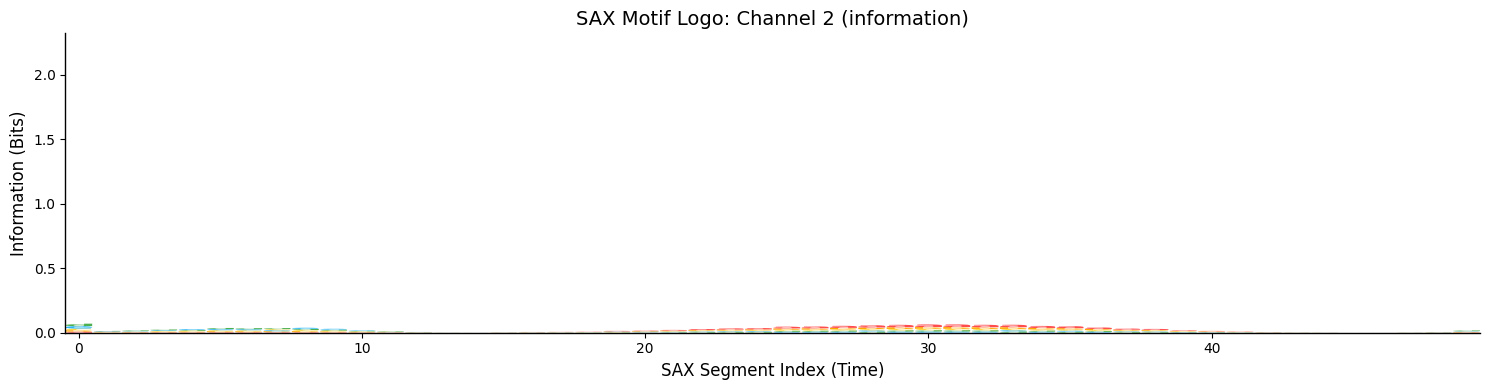

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.1273
Char 'b': -0.1273 to -0.0546
Char 'c': -0.0546 to -0.0211
Char 'd': -0.0211 to -0.0000
Char 'e': -0.0000 to 0.0211
Char 'f': 0.0211 to 0.0547
Char 'g': 0.0547 to 0.1273
Char 'h': 0.1273 to 5.4734


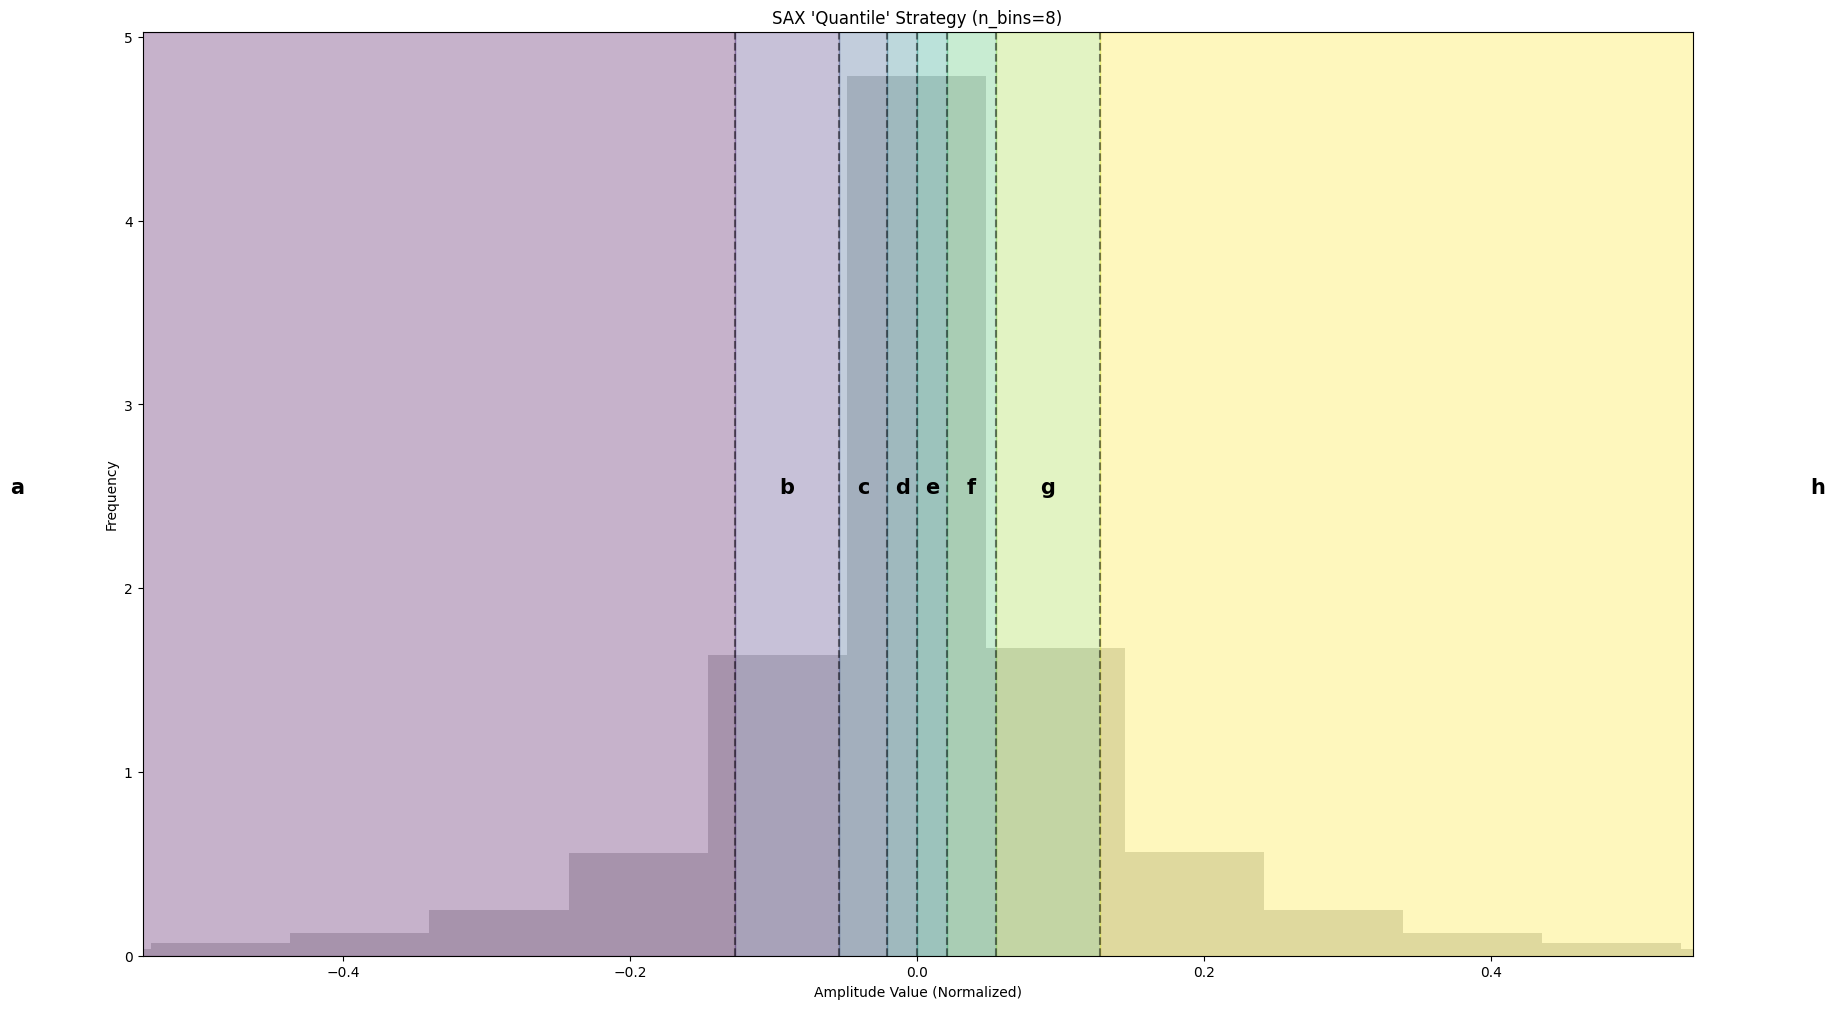

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 50)

--- Pattern Mining Input Check ---
Earthquake 0 String: cnefnckgjlbepahnfapjpaobmlmapboggfkmdicleodihjhdki|mddmjbinchdppaopbepkanohbclloagmkjanffkeejlcifhggi|mbcpbnegfngpoaaohcapjlpabmeodjhgkdnkfiefjimckdlhil


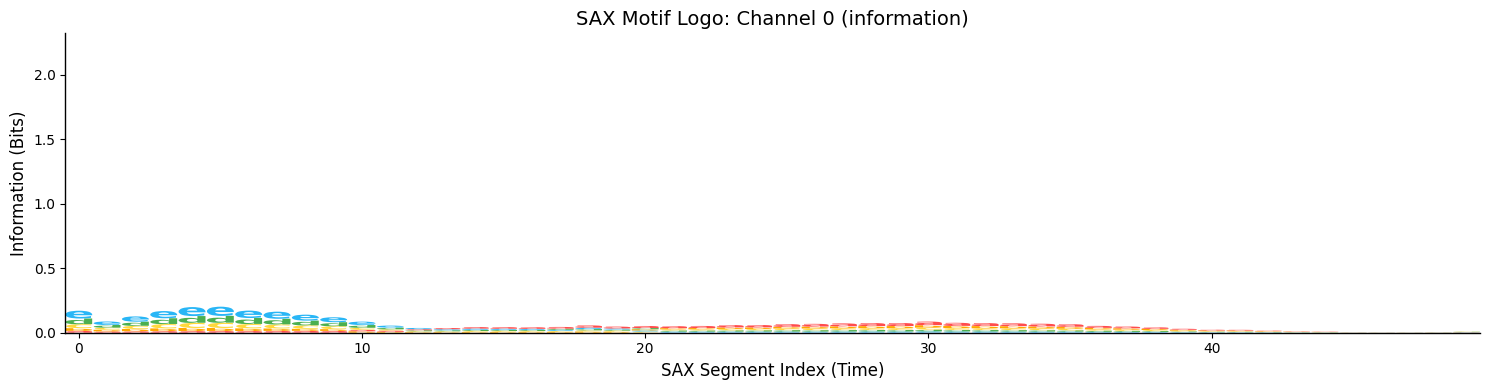

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.2189
Char 'b': -0.2189 to -0.1273
Char 'c': -0.1273 to -0.0824
Char 'd': -0.0824 to -0.0546
Char 'e': -0.0546 to -0.0354
Char 'f': -0.0354 to -0.0211
Char 'g': -0.0211 to -0.0097
Char 'h': -0.0097 to -0.0000
Char 'i': -0.0000 to 0.0097
Char 'j': 0.0097 to 0.0211
Char 'k': 0.0211 to 0.0354
Char 'l': 0.0354 to 0.0547
Char 'm': 0.0547 to 0.0824
Char 'n': 0.0824 to 0.1273
Char 'o': 0.1273 to 0.2187
Char 'p': 0.2187 to 5.4734


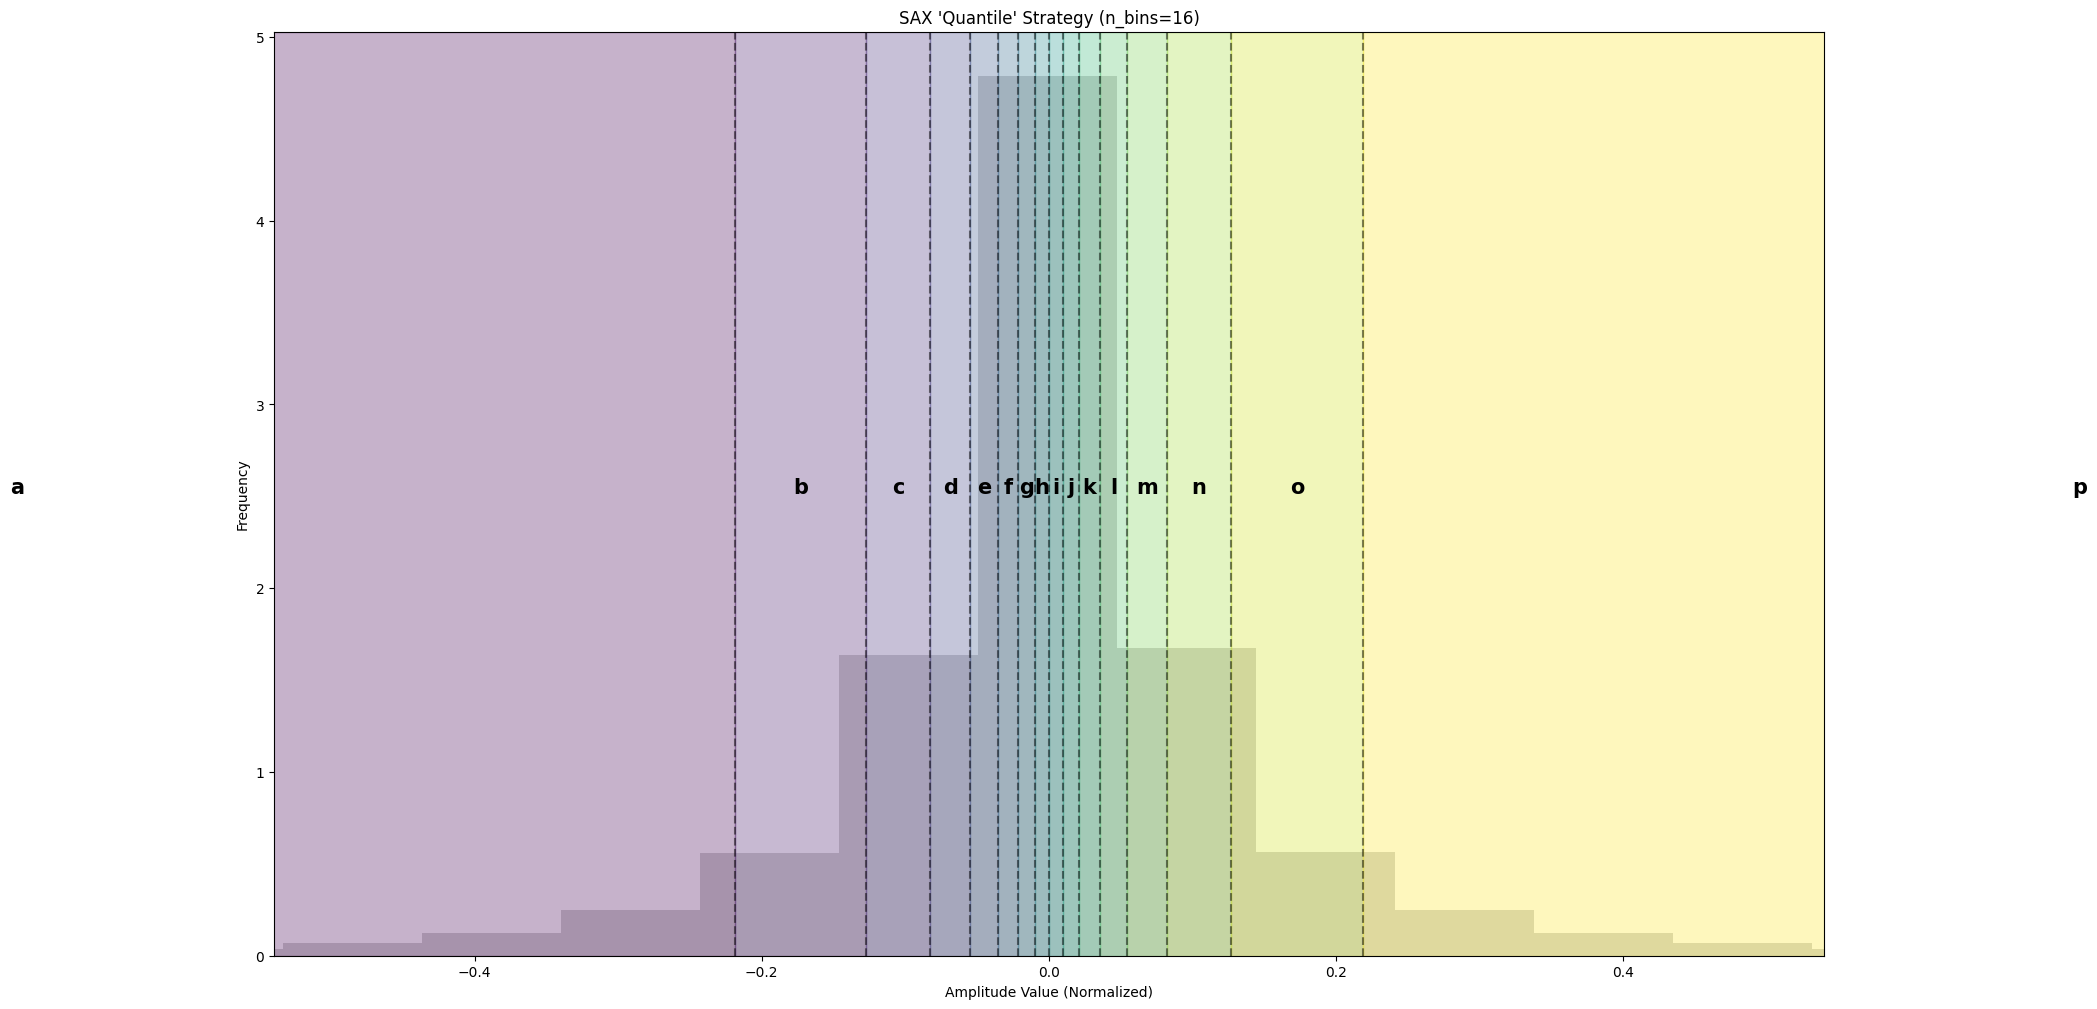

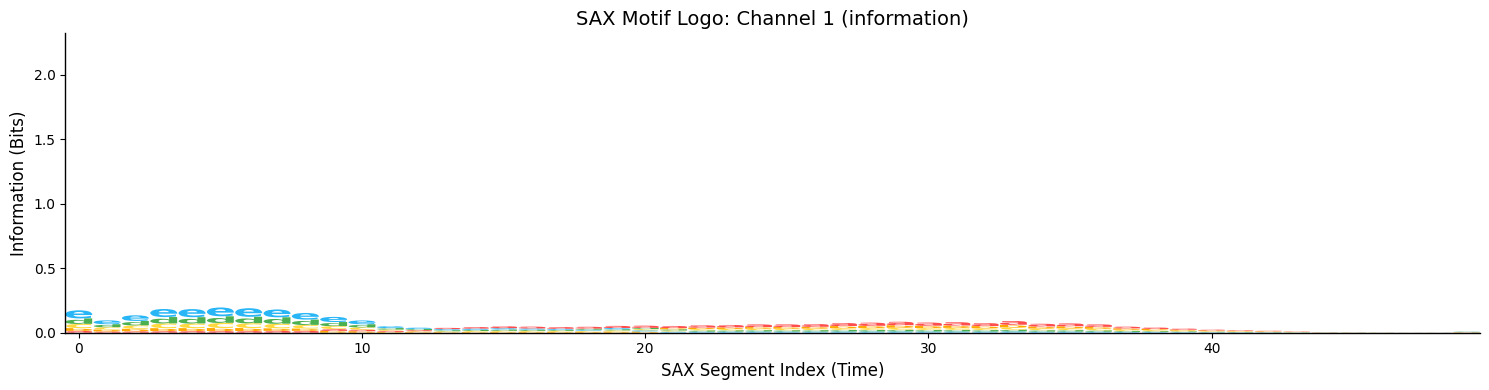

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.2189
Char 'b': -0.2189 to -0.1273
Char 'c': -0.1273 to -0.0824
Char 'd': -0.0824 to -0.0546
Char 'e': -0.0546 to -0.0354
Char 'f': -0.0354 to -0.0211
Char 'g': -0.0211 to -0.0097
Char 'h': -0.0097 to -0.0000
Char 'i': -0.0000 to 0.0097
Char 'j': 0.0097 to 0.0211
Char 'k': 0.0211 to 0.0354
Char 'l': 0.0354 to 0.0547
Char 'm': 0.0547 to 0.0824
Char 'n': 0.0824 to 0.1273
Char 'o': 0.1273 to 0.2187
Char 'p': 0.2187 to 5.4734


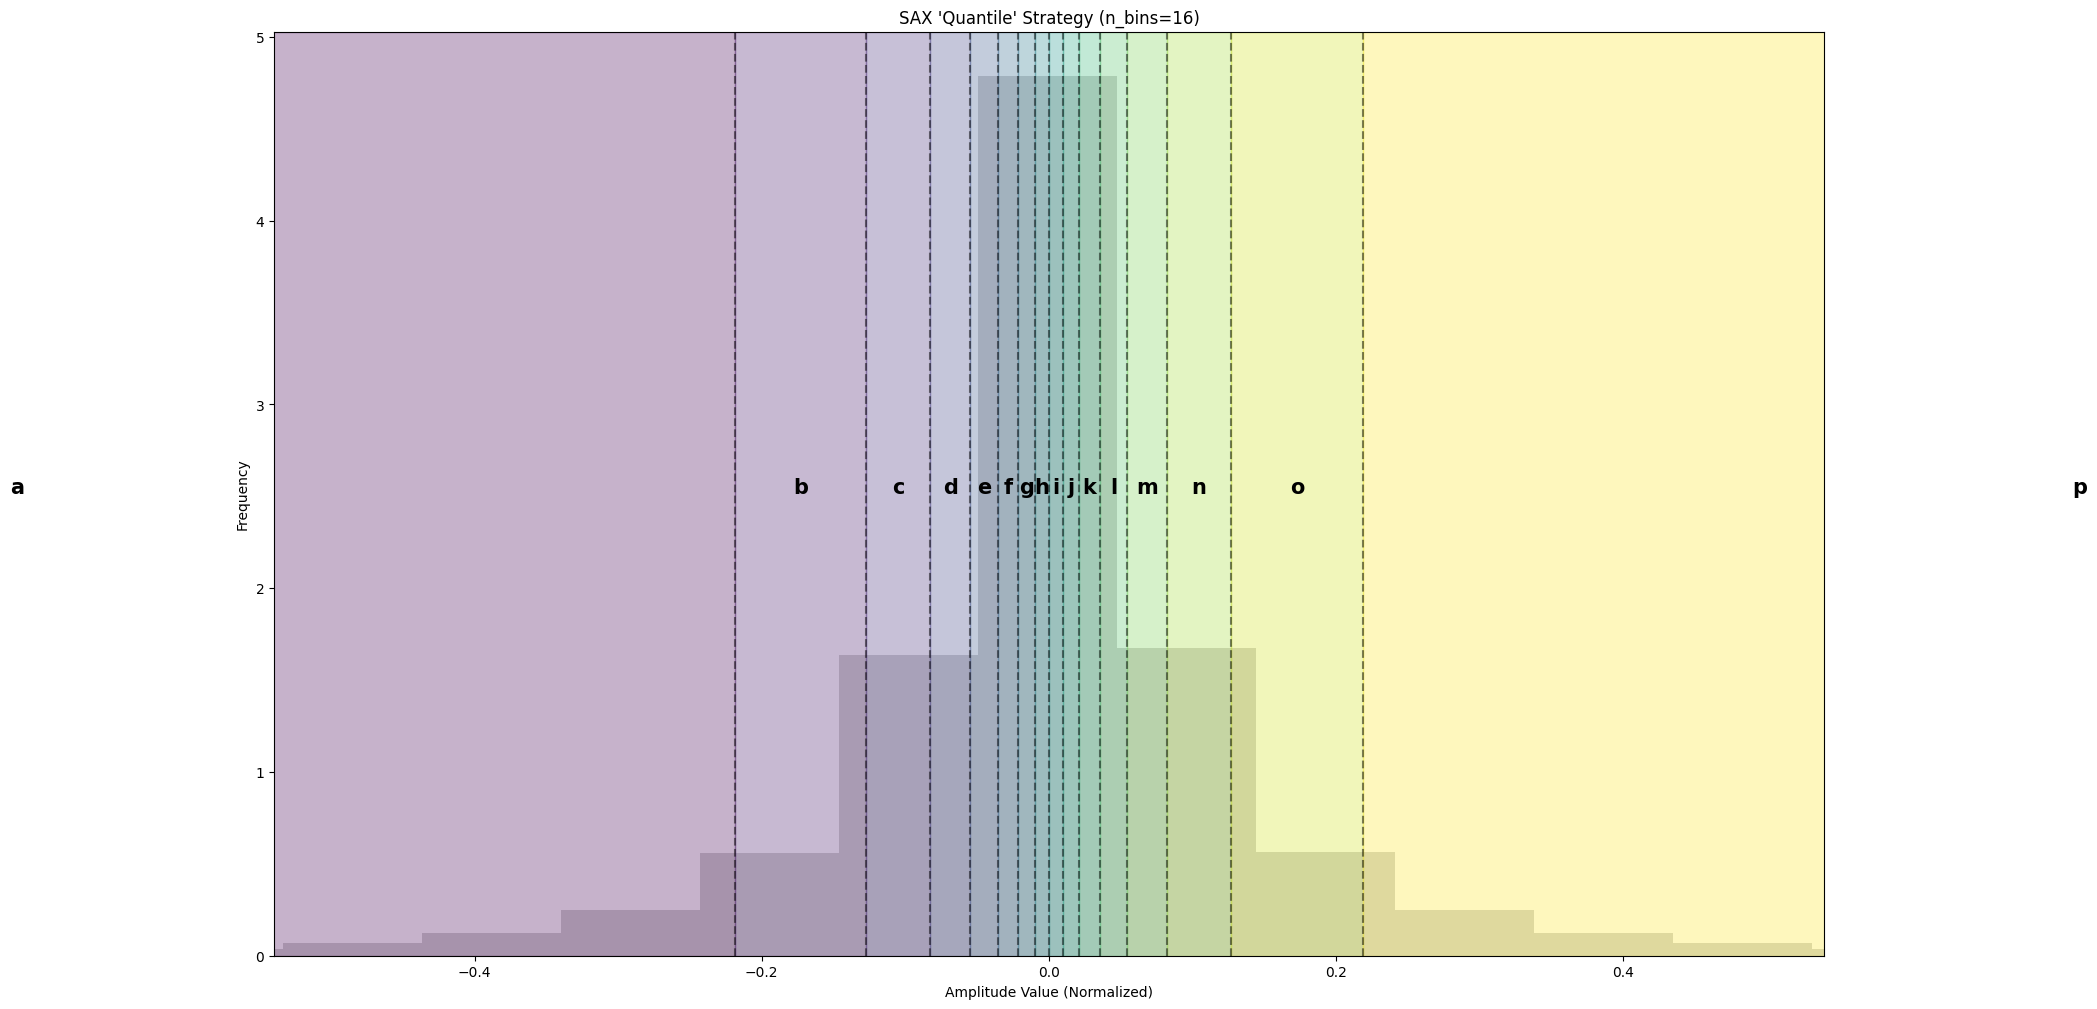

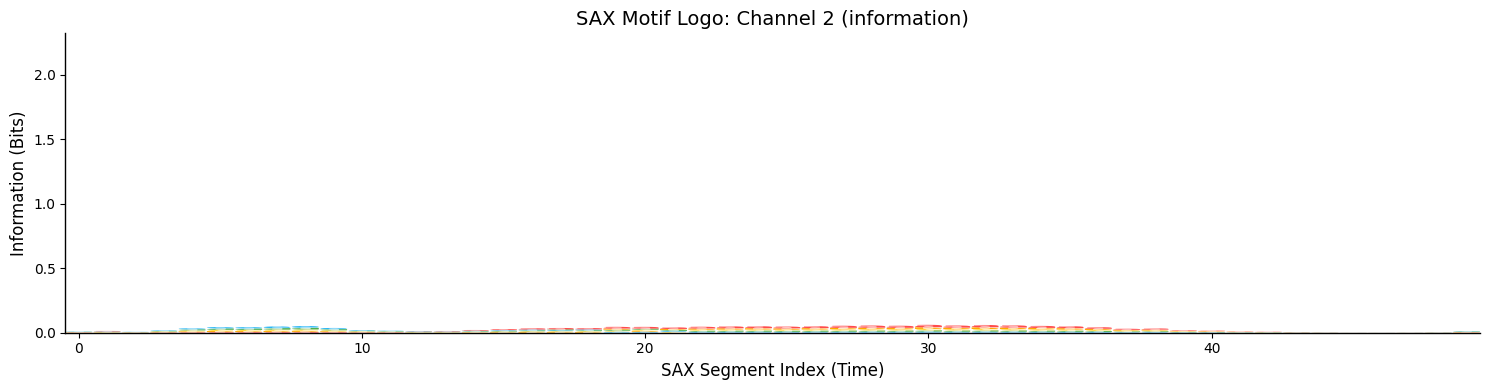

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.2189
Char 'b': -0.2189 to -0.1273
Char 'c': -0.1273 to -0.0824
Char 'd': -0.0824 to -0.0546
Char 'e': -0.0546 to -0.0354
Char 'f': -0.0354 to -0.0211
Char 'g': -0.0211 to -0.0097
Char 'h': -0.0097 to -0.0000
Char 'i': -0.0000 to 0.0097
Char 'j': 0.0097 to 0.0211
Char 'k': 0.0211 to 0.0354
Char 'l': 0.0354 to 0.0547
Char 'm': 0.0547 to 0.0824
Char 'n': 0.0824 to 0.1273
Char 'o': 0.1273 to 0.2187
Char 'p': 0.2187 to 5.4734


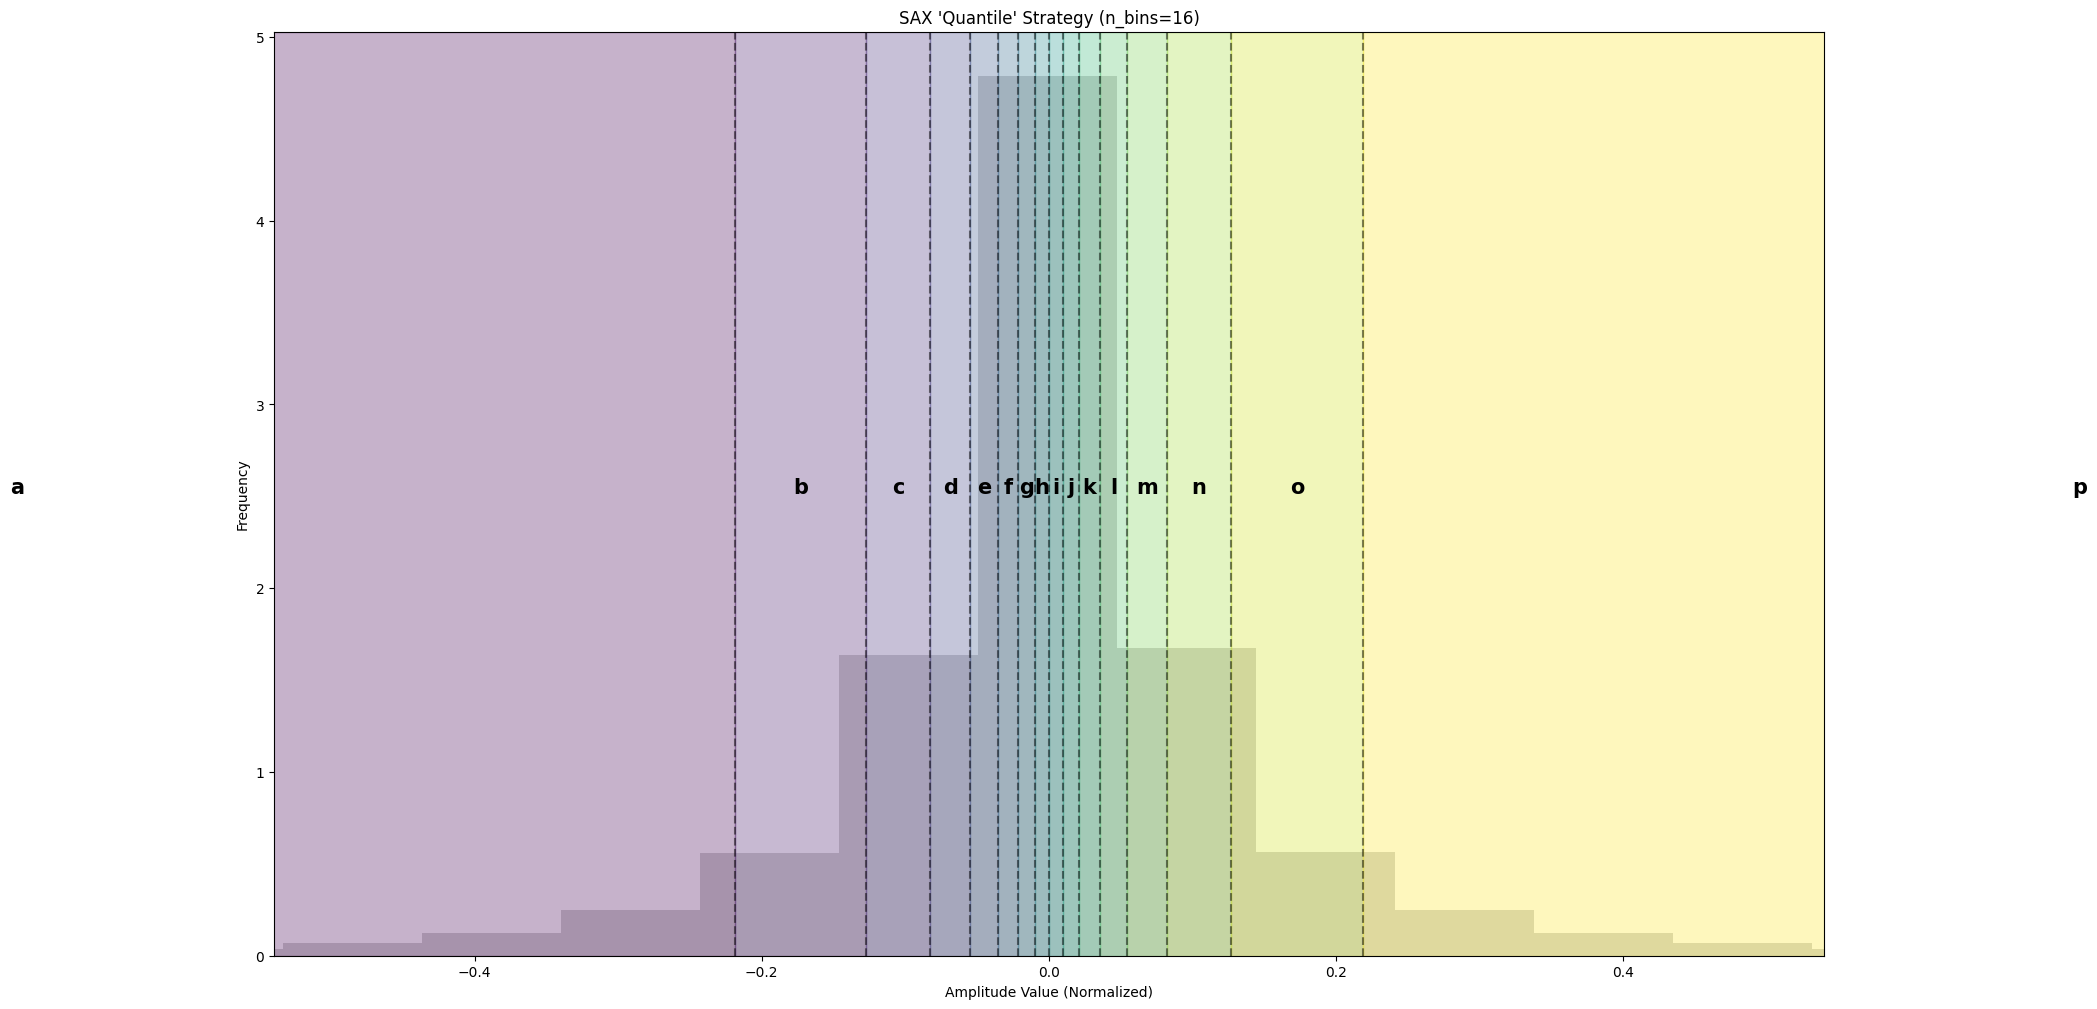

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 50)

--- Pattern Mining Input Check ---
Earthquake 0 String: dughudpkoqchxaktibxnwavbtrsaxcwjjipsfmergvemlolfqn|tffsobnuekewxawxcgxpauvlcdrrvajspnbtiiqhgoqdmhljkm|scexctgjiujxvaawldaworxbbthveolkpfuphmginnsdqfrkmq


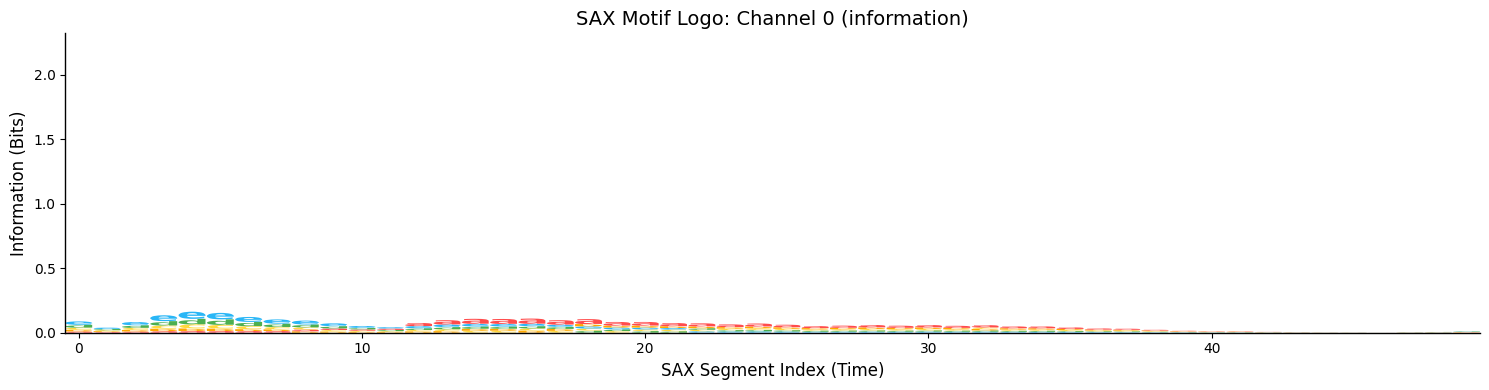

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.2802
Char 'b': -0.2802 to -0.1788
Char 'c': -0.1788 to -0.1273
Char 'd': -0.1273 to -0.0947
Char 'e': -0.0947 to -0.0718
Char 'f': -0.0718 to -0.0546
Char 'g': -0.0546 to -0.0412
Char 'h': -0.0412 to -0.0302
Char 'i': -0.0302 to -0.0211
Char 'j': -0.0211 to -0.0133
Char 'k': -0.0133 to -0.0064
Char 'l': -0.0064 to -0.0000
Char 'm': -0.0000 to 0.0064
Char 'n': 0.0064 to 0.0133
Char 'o': 0.0133 to 0.0211
Char 'p': 0.0211 to 0.0302
Char 'q': 0.0302 to 0.0411
Char 'r': 0.0411 to 0.0547
Char 's': 0.0547 to 0.0718
Char 't': 0.0718 to 0.0948
Char 'u': 0.0948 to 0.1273
Char 'v': 0.1273 to 0.1785
Char 'w': 0.1785 to 0.2799
Char 'x': 0.2799 to 5.4734


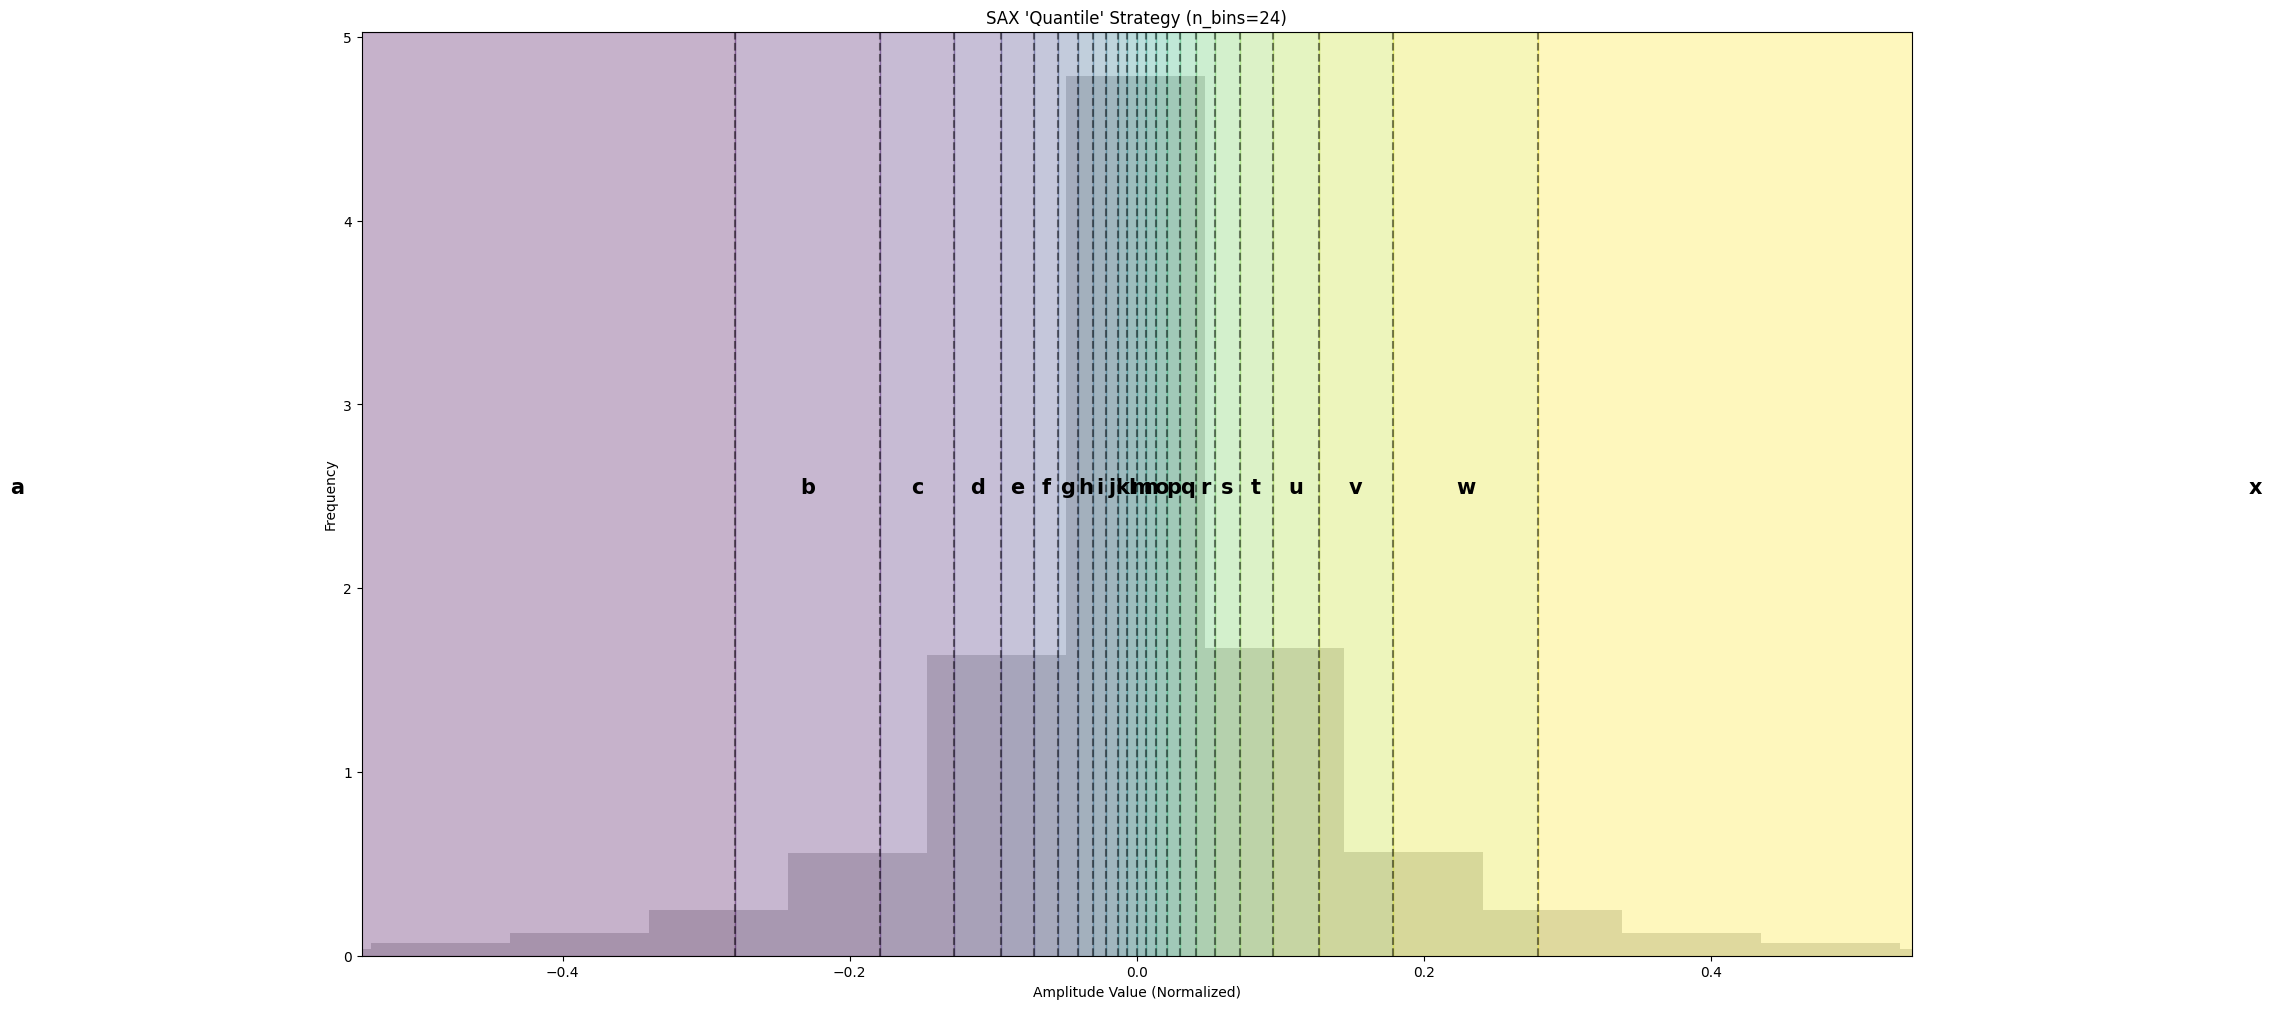

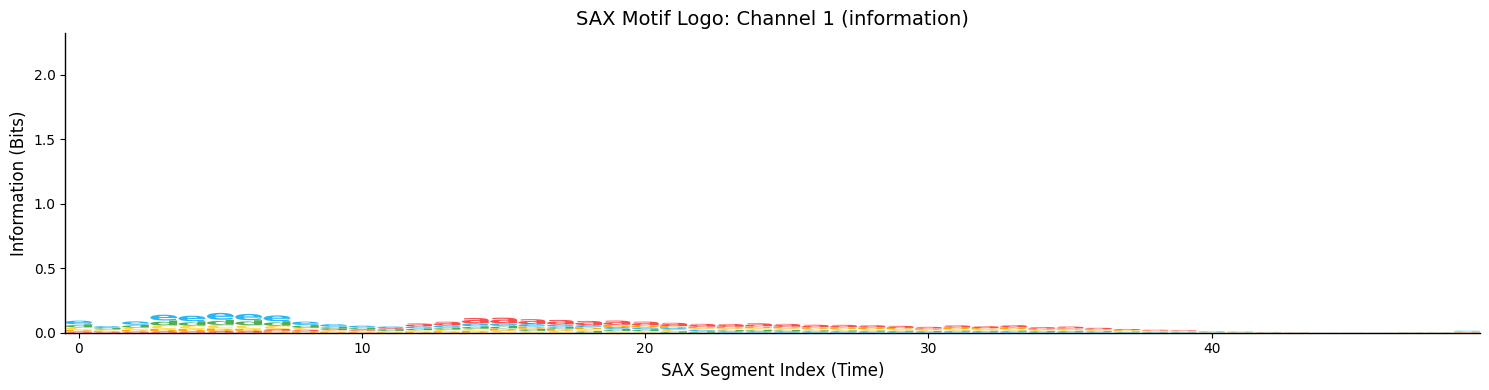

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.2802
Char 'b': -0.2802 to -0.1788
Char 'c': -0.1788 to -0.1273
Char 'd': -0.1273 to -0.0947
Char 'e': -0.0947 to -0.0718
Char 'f': -0.0718 to -0.0546
Char 'g': -0.0546 to -0.0412
Char 'h': -0.0412 to -0.0302
Char 'i': -0.0302 to -0.0211
Char 'j': -0.0211 to -0.0133
Char 'k': -0.0133 to -0.0064
Char 'l': -0.0064 to -0.0000
Char 'm': -0.0000 to 0.0064
Char 'n': 0.0064 to 0.0133
Char 'o': 0.0133 to 0.0211
Char 'p': 0.0211 to 0.0302
Char 'q': 0.0302 to 0.0411
Char 'r': 0.0411 to 0.0547
Char 's': 0.0547 to 0.0718
Char 't': 0.0718 to 0.0948
Char 'u': 0.0948 to 0.1273
Char 'v': 0.1273 to 0.1785
Char 'w': 0.1785 to 0.2799
Char 'x': 0.2799 to 5.4734


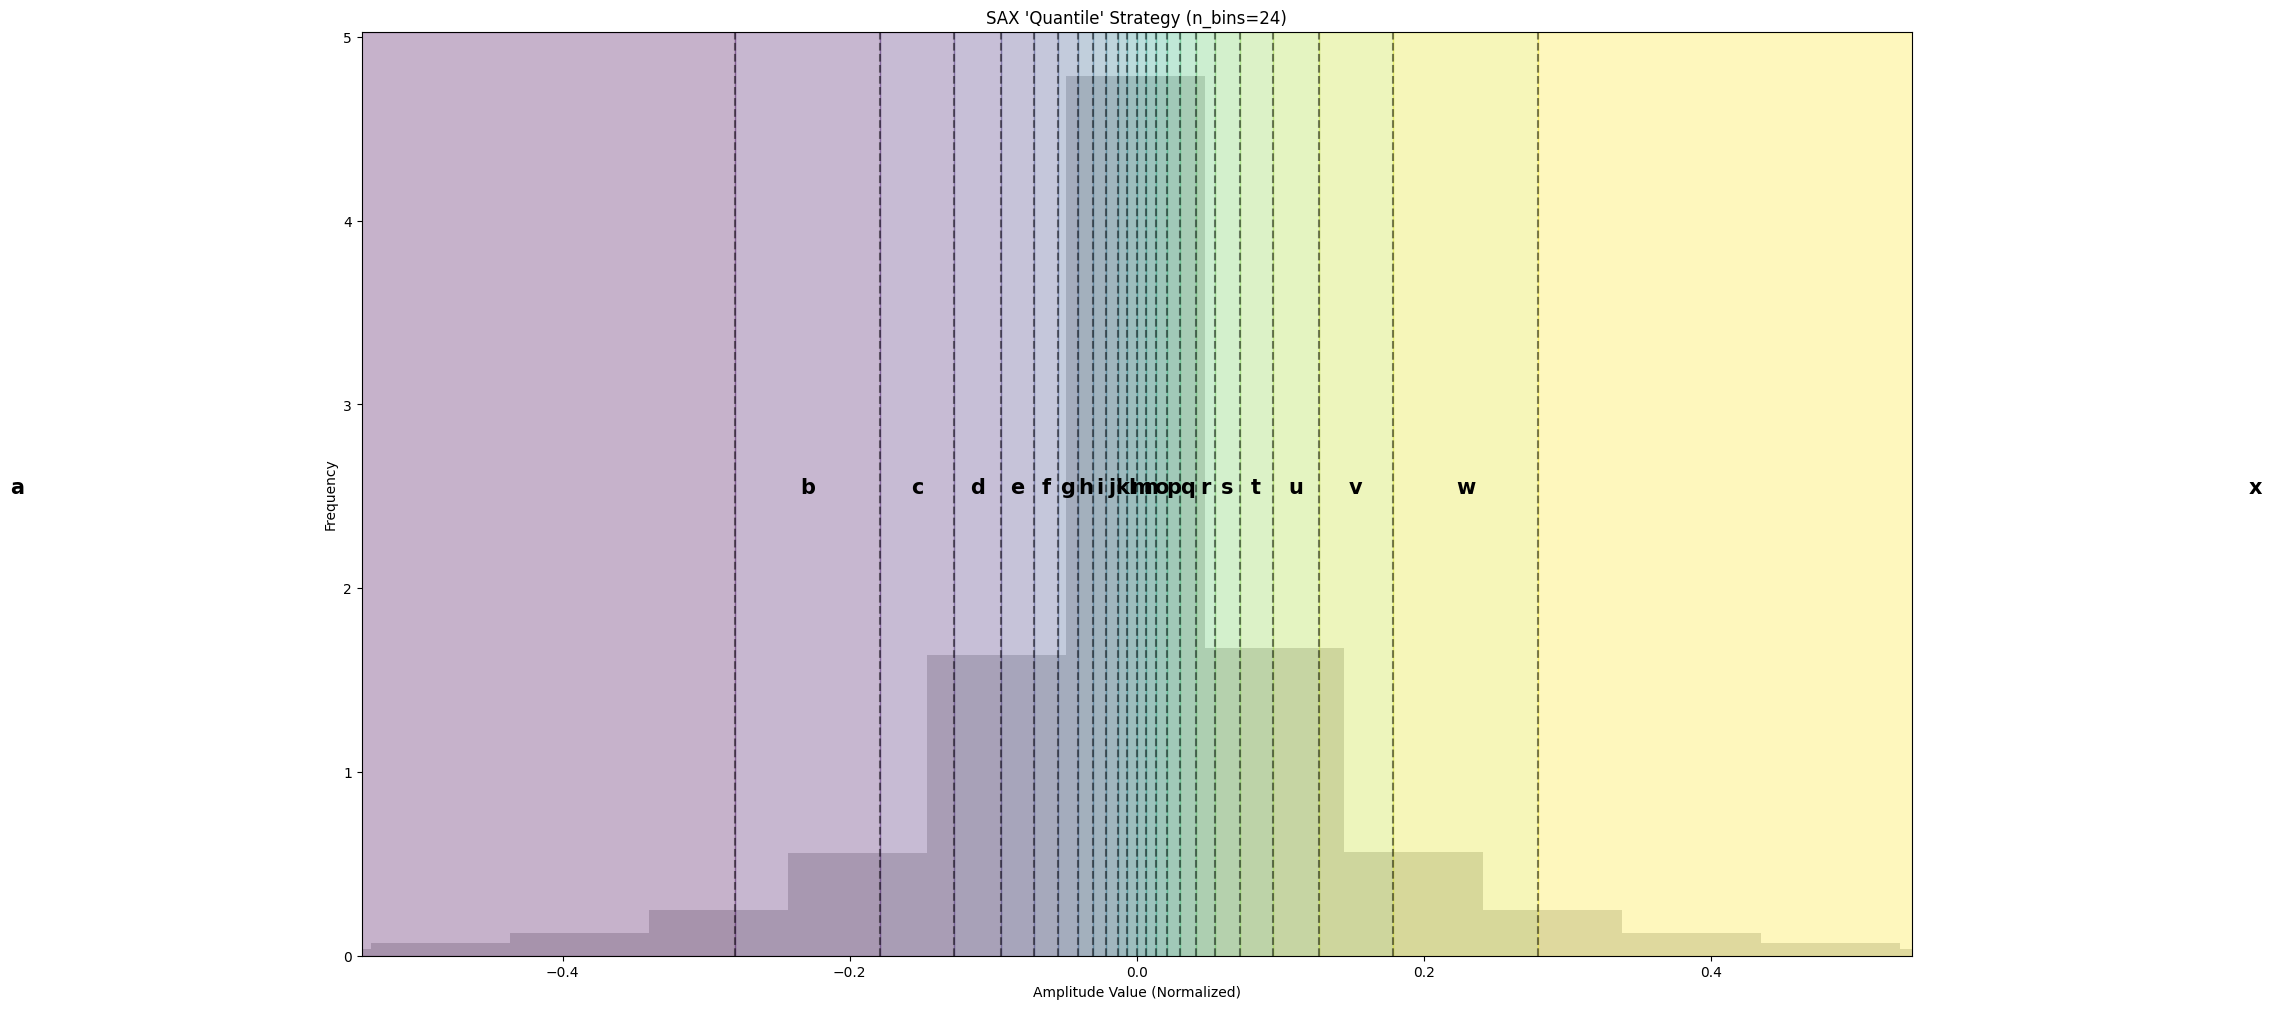

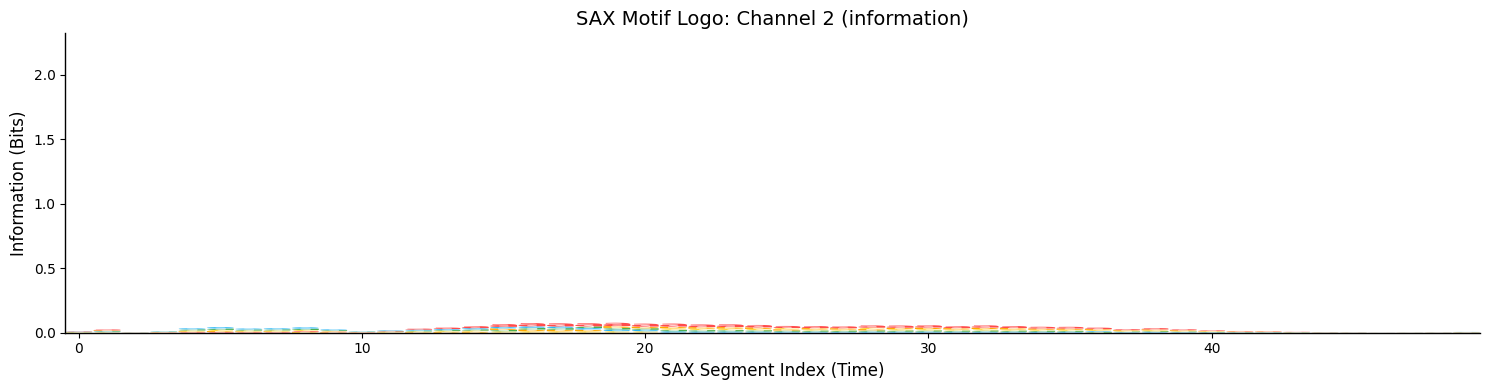

--- Learned Quantile Thresholds ---
Char 'a': -4.2154 to -0.2802
Char 'b': -0.2802 to -0.1788
Char 'c': -0.1788 to -0.1273
Char 'd': -0.1273 to -0.0947
Char 'e': -0.0947 to -0.0718
Char 'f': -0.0718 to -0.0546
Char 'g': -0.0546 to -0.0412
Char 'h': -0.0412 to -0.0302
Char 'i': -0.0302 to -0.0211
Char 'j': -0.0211 to -0.0133
Char 'k': -0.0133 to -0.0064
Char 'l': -0.0064 to -0.0000
Char 'm': -0.0000 to 0.0064
Char 'n': 0.0064 to 0.0133
Char 'o': 0.0133 to 0.0211
Char 'p': 0.0211 to 0.0302
Char 'q': 0.0302 to 0.0411
Char 'r': 0.0411 to 0.0547
Char 's': 0.0547 to 0.0718
Char 't': 0.0718 to 0.0948
Char 'u': 0.0948 to 0.1273
Char 'v': 0.1273 to 0.1785
Char 'w': 0.1785 to 0.2799
Char 'x': 0.2799 to 5.4734


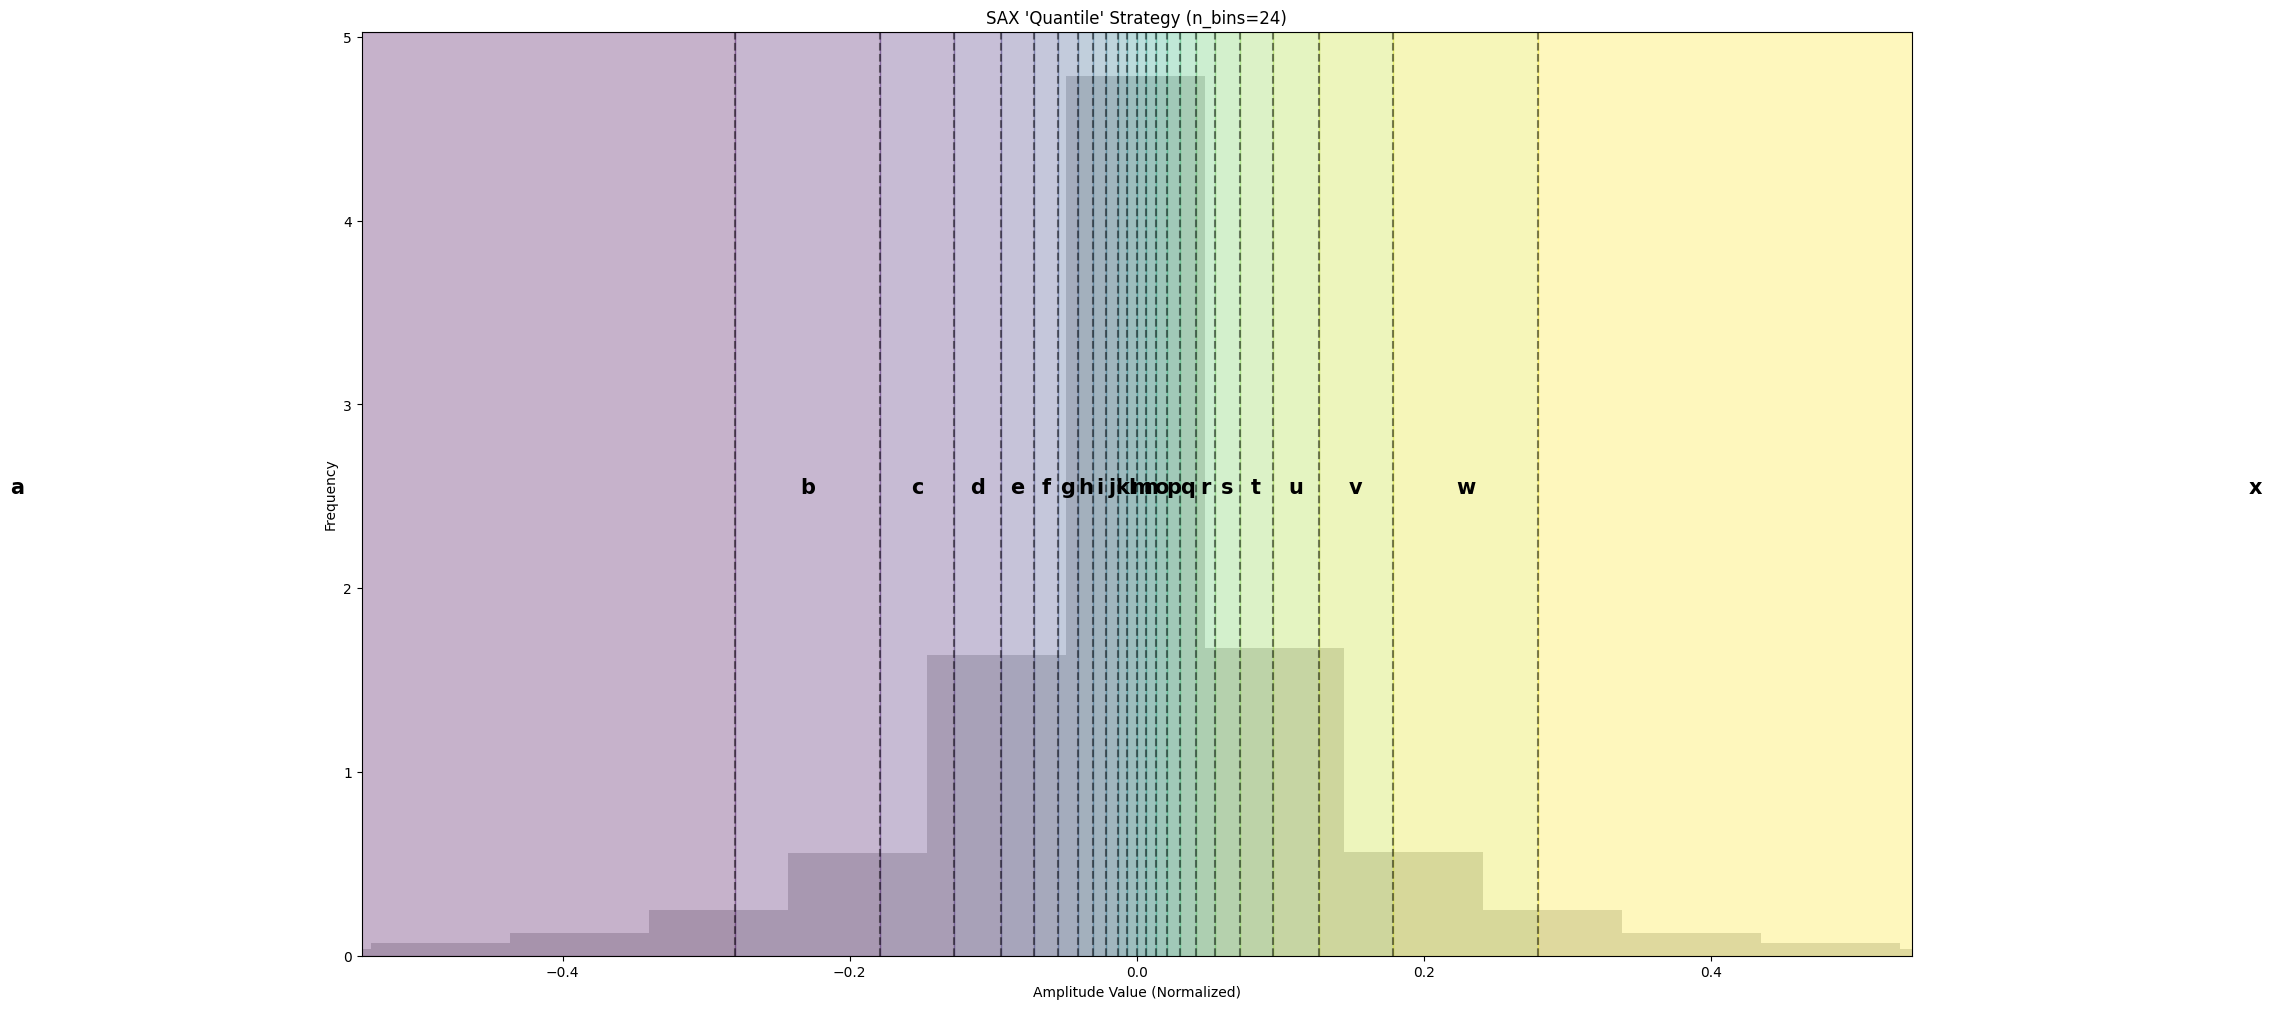

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 100)

--- Pattern Mining Input Check ---
Earthquake 0 String: gaheddceggbccgbgdfdgfahahaaafcbhecabhbahdhachedahdefbhbahdfahccecffbgcegbfdegahcgbggbfdeecfdcffbfede|efbegbdgbgcbgbegbeedbdfhahahhaheahbgahefcaffchahahfahagcchagedegbgbgdahaecfcefcdfbfccgcbfdddfdceddcf|dgcbgahgafefcdgbfbefbgbhahahabdhhahacahahahadhaheagcechccdgcdededffbfecgbfcfbffbgbgcdgbefdecfeceeddg


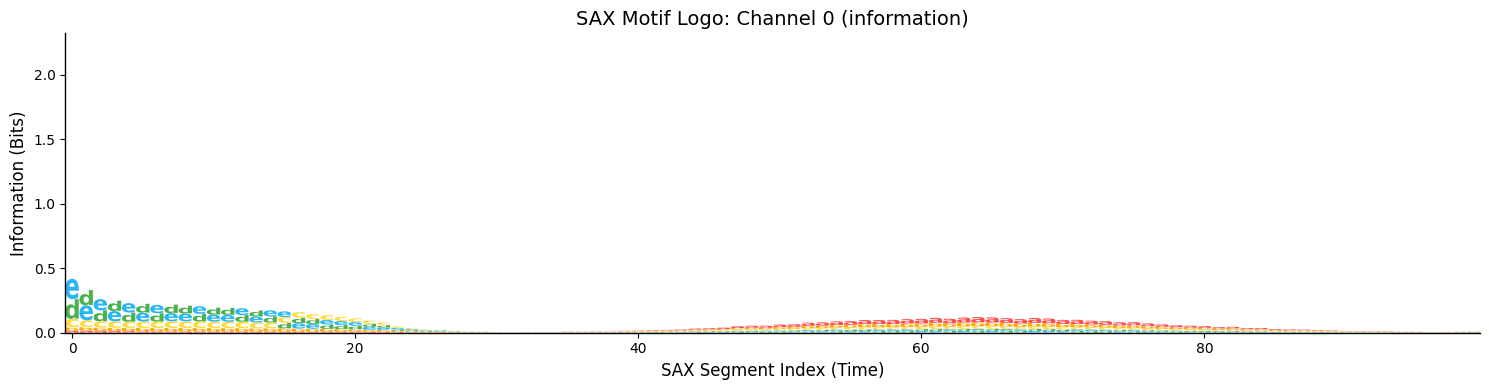

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.2733
Char 'b': -0.2733 to -0.1164
Char 'c': -0.1164 to -0.0444
Char 'd': -0.0444 to 0.0000
Char 'e': 0.0000 to 0.0445
Char 'f': 0.0445 to 0.1165
Char 'g': 0.1165 to 0.2733
Char 'h': 0.2733 to 7.0341


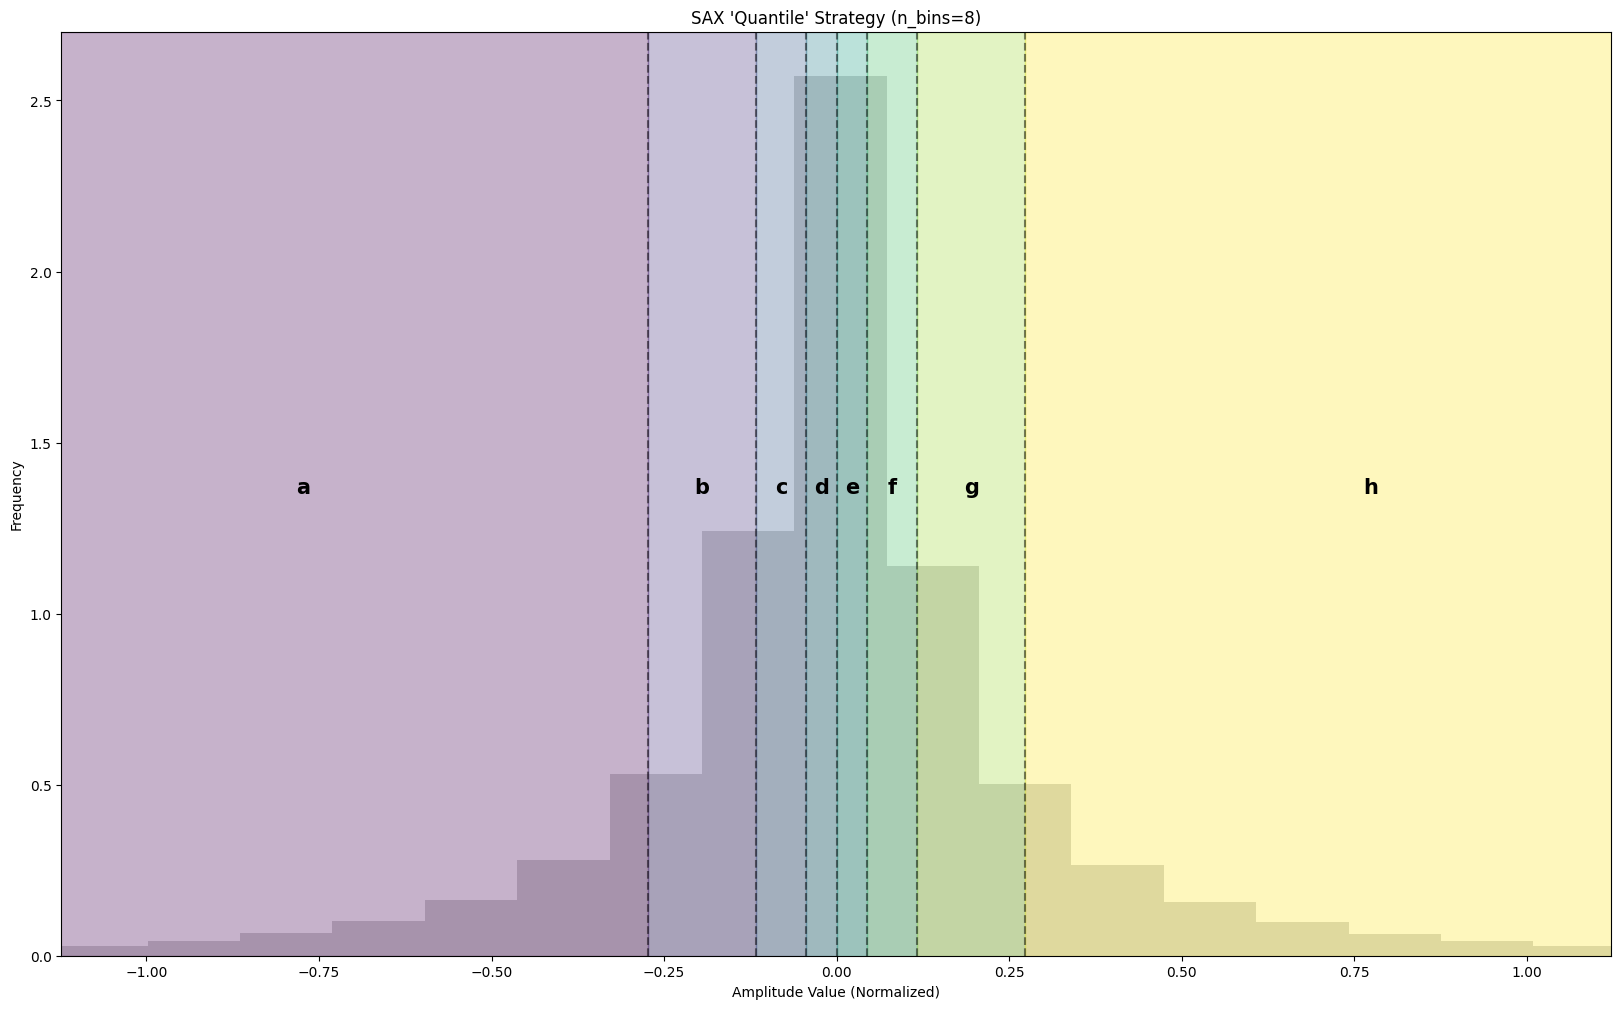

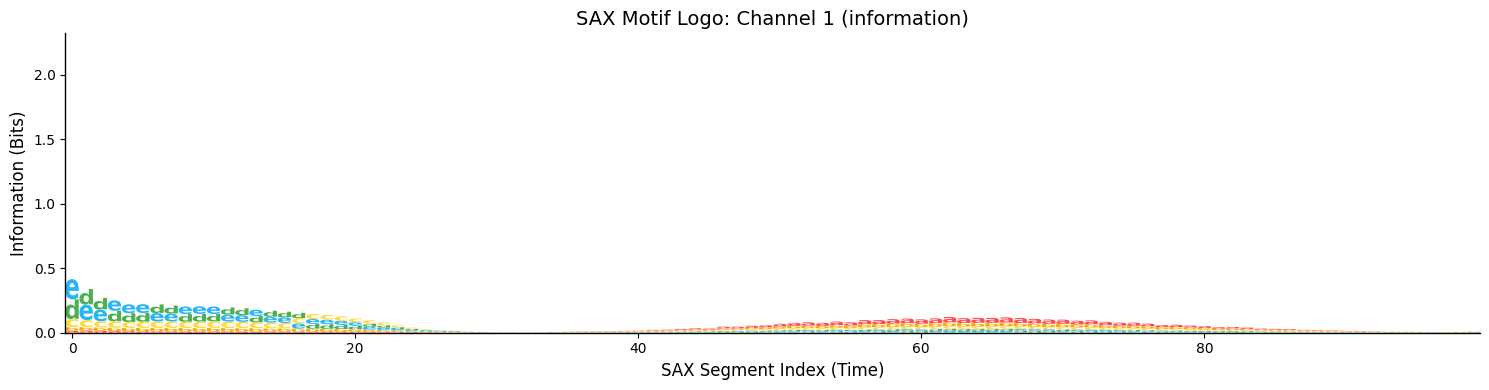

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.2733
Char 'b': -0.2733 to -0.1164
Char 'c': -0.1164 to -0.0444
Char 'd': -0.0444 to 0.0000
Char 'e': 0.0000 to 0.0445
Char 'f': 0.0445 to 0.1165
Char 'g': 0.1165 to 0.2733
Char 'h': 0.2733 to 7.0341


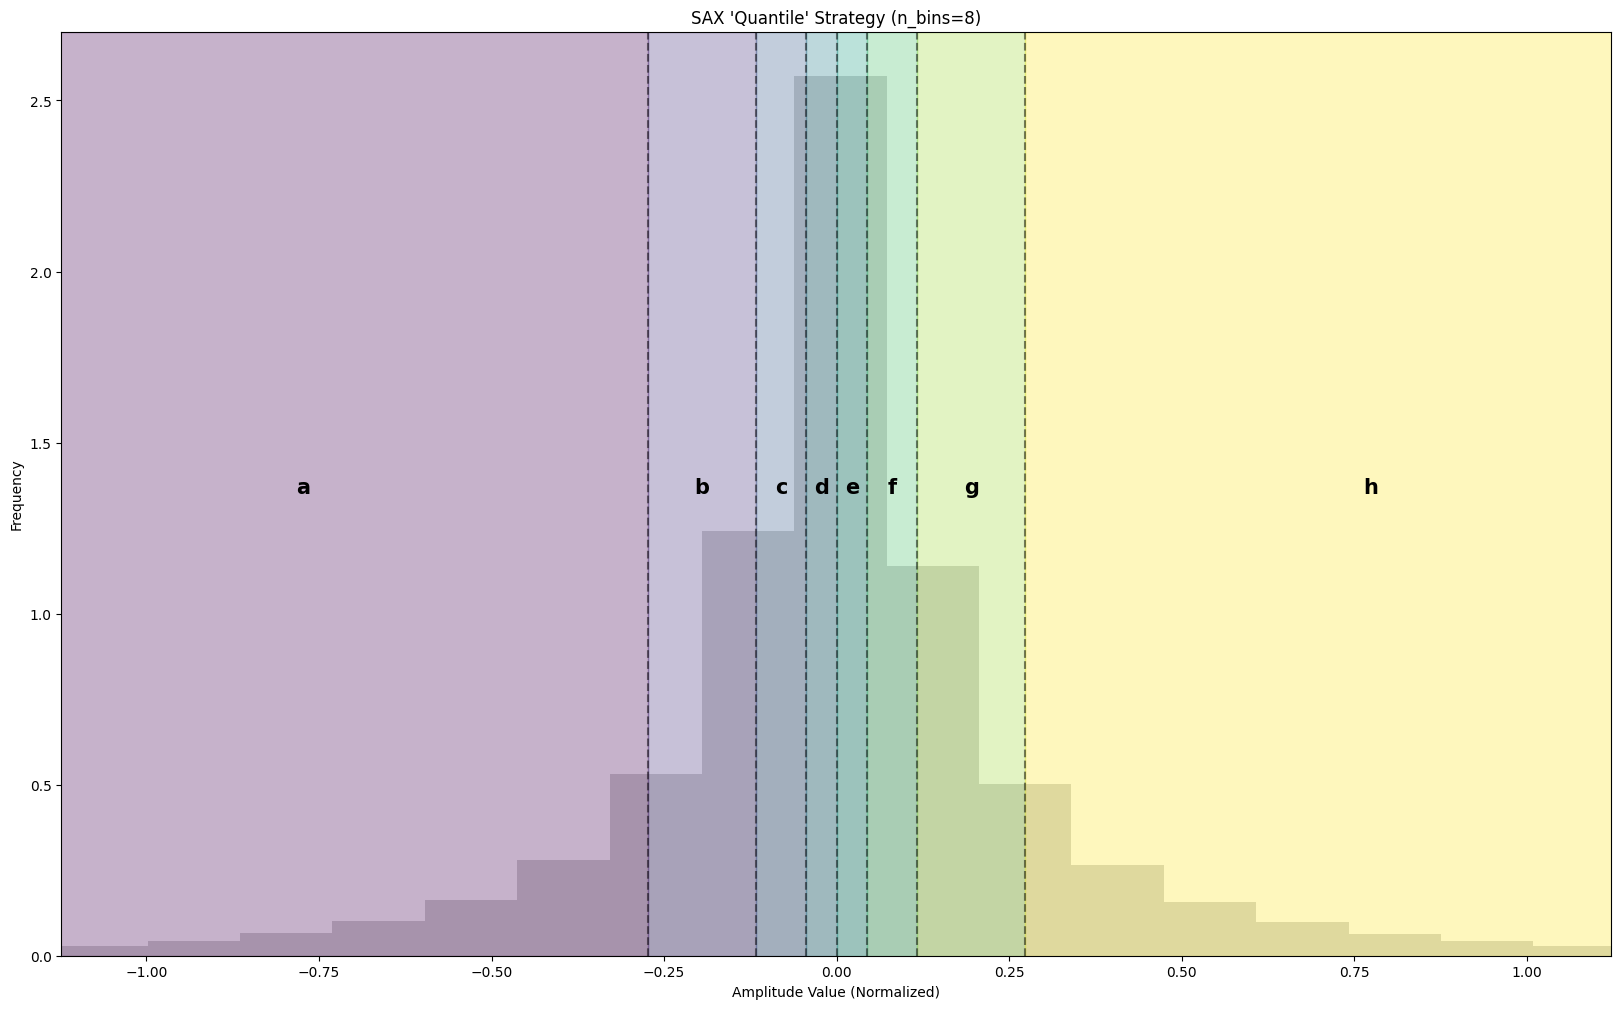

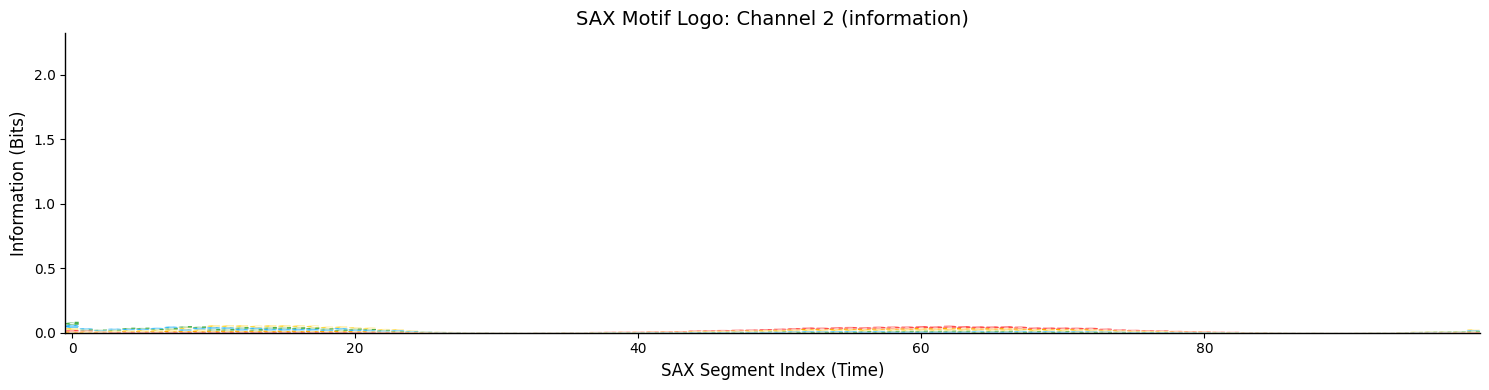

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.2733
Char 'b': -0.2733 to -0.1164
Char 'c': -0.1164 to -0.0444
Char 'd': -0.0444 to 0.0000
Char 'e': 0.0000 to 0.0445
Char 'f': 0.0445 to 0.1165
Char 'g': 0.1165 to 0.2733
Char 'h': 0.2733 to 7.0341


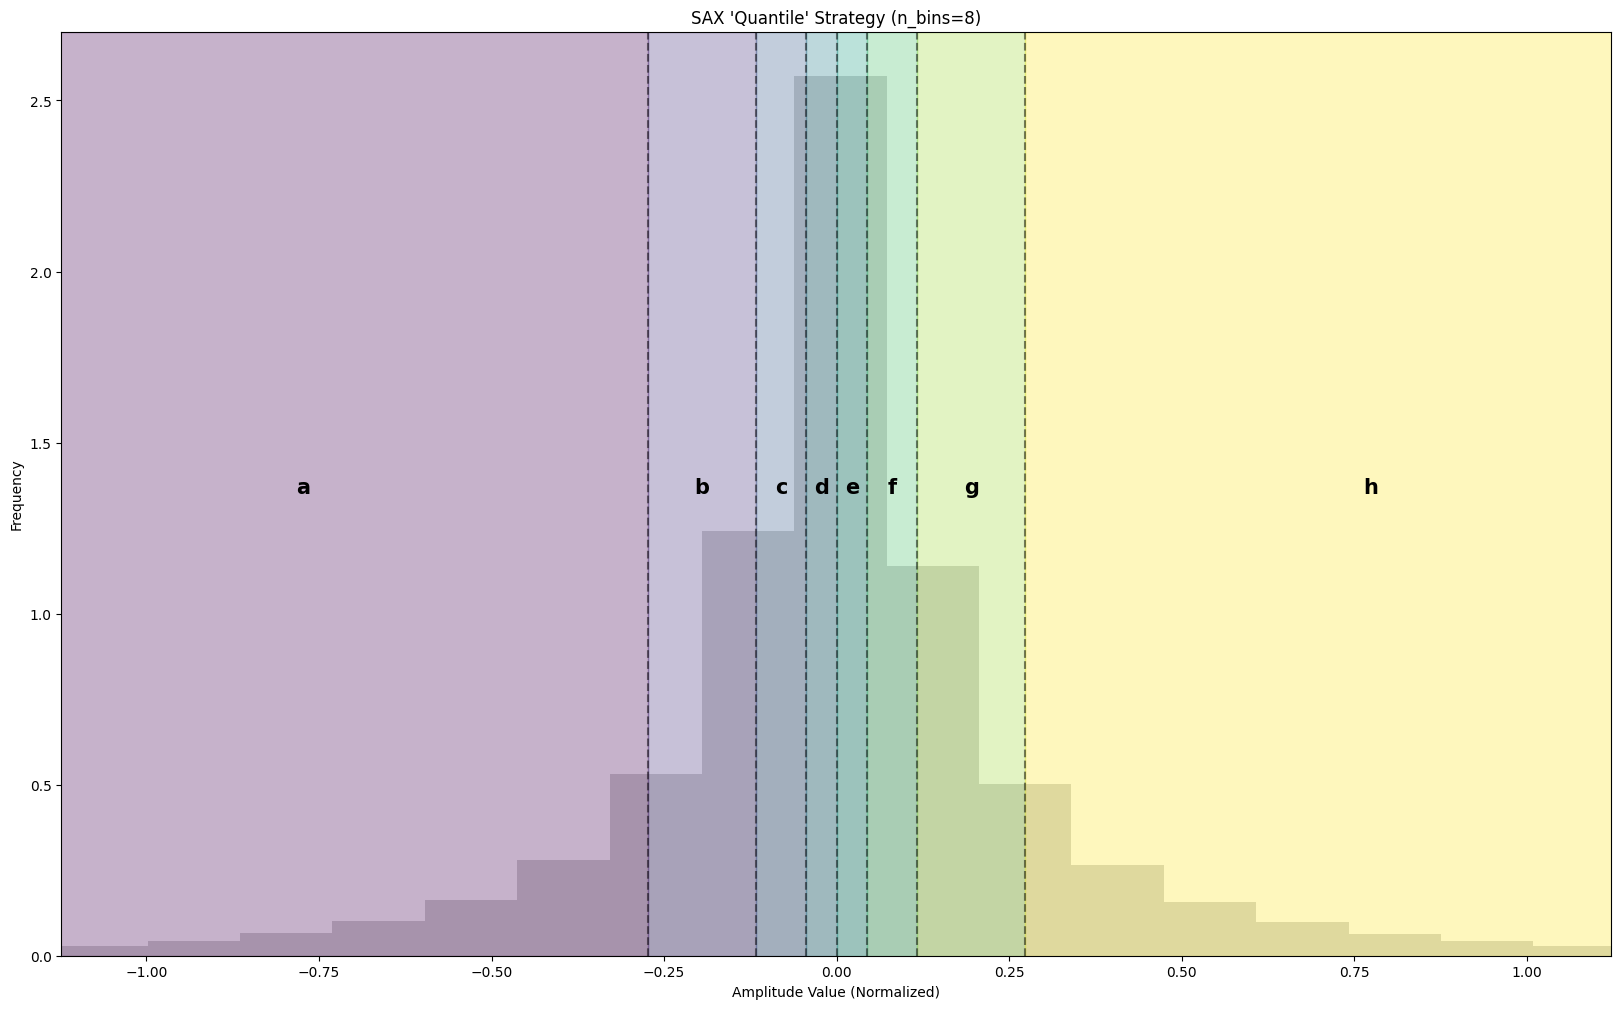

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 100)

--- Pattern Mining Input Check ---
Earthquake 0 String: mboihgeinmdffndmglgmlbobpaaakecpifadpdapgoafoigbogjldpcaphkbpefjekkdnejnckhimboencmnckhjjfkhfllclihj|jldjmchmcnecmdjncjihdhloapappbpjaocmapikfblkfoapaokbobnefoanigimdncngbpbjekeikfhldlffmedkgghkgfighel|hmfdnbomakjlfhmdlcjkcndpapapacgooboafbpaobpbhpapjbnfifoeehnegihiglkclienclfkdklcndmehmdikgjekifjjggm


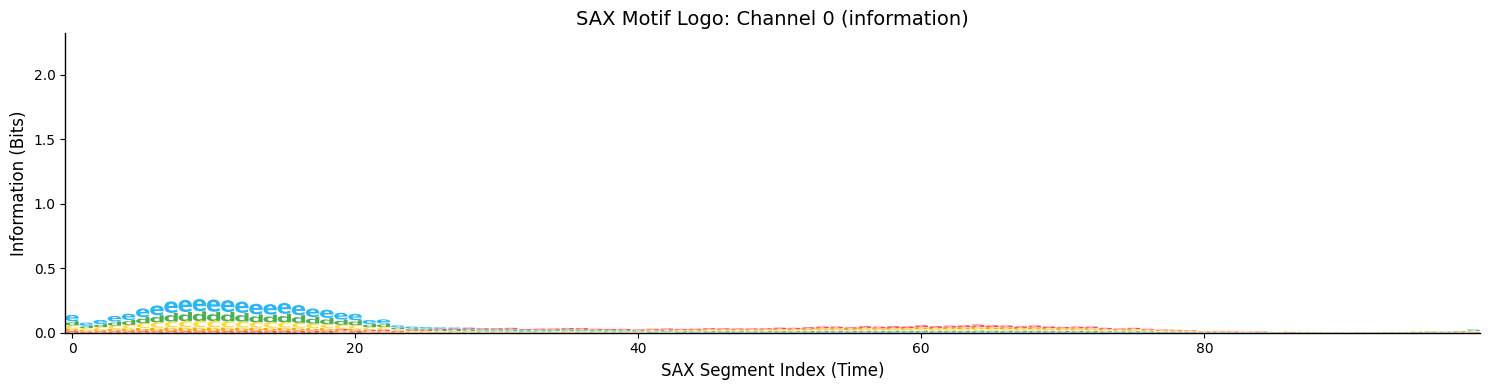

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.4692
Char 'b': -0.4692 to -0.2733
Char 'c': -0.2733 to -0.1763
Char 'd': -0.1763 to -0.1164
Char 'e': -0.1164 to -0.0751
Char 'f': -0.0751 to -0.0444
Char 'g': -0.0444 to -0.0203
Char 'h': -0.0203 to 0.0000
Char 'i': 0.0000 to 0.0203
Char 'j': 0.0203 to 0.0445
Char 'k': 0.0445 to 0.0751
Char 'l': 0.0751 to 0.1165
Char 'm': 0.1165 to 0.1765
Char 'n': 0.1765 to 0.2733
Char 'o': 0.2733 to 0.4694
Char 'p': 0.4694 to 7.0341


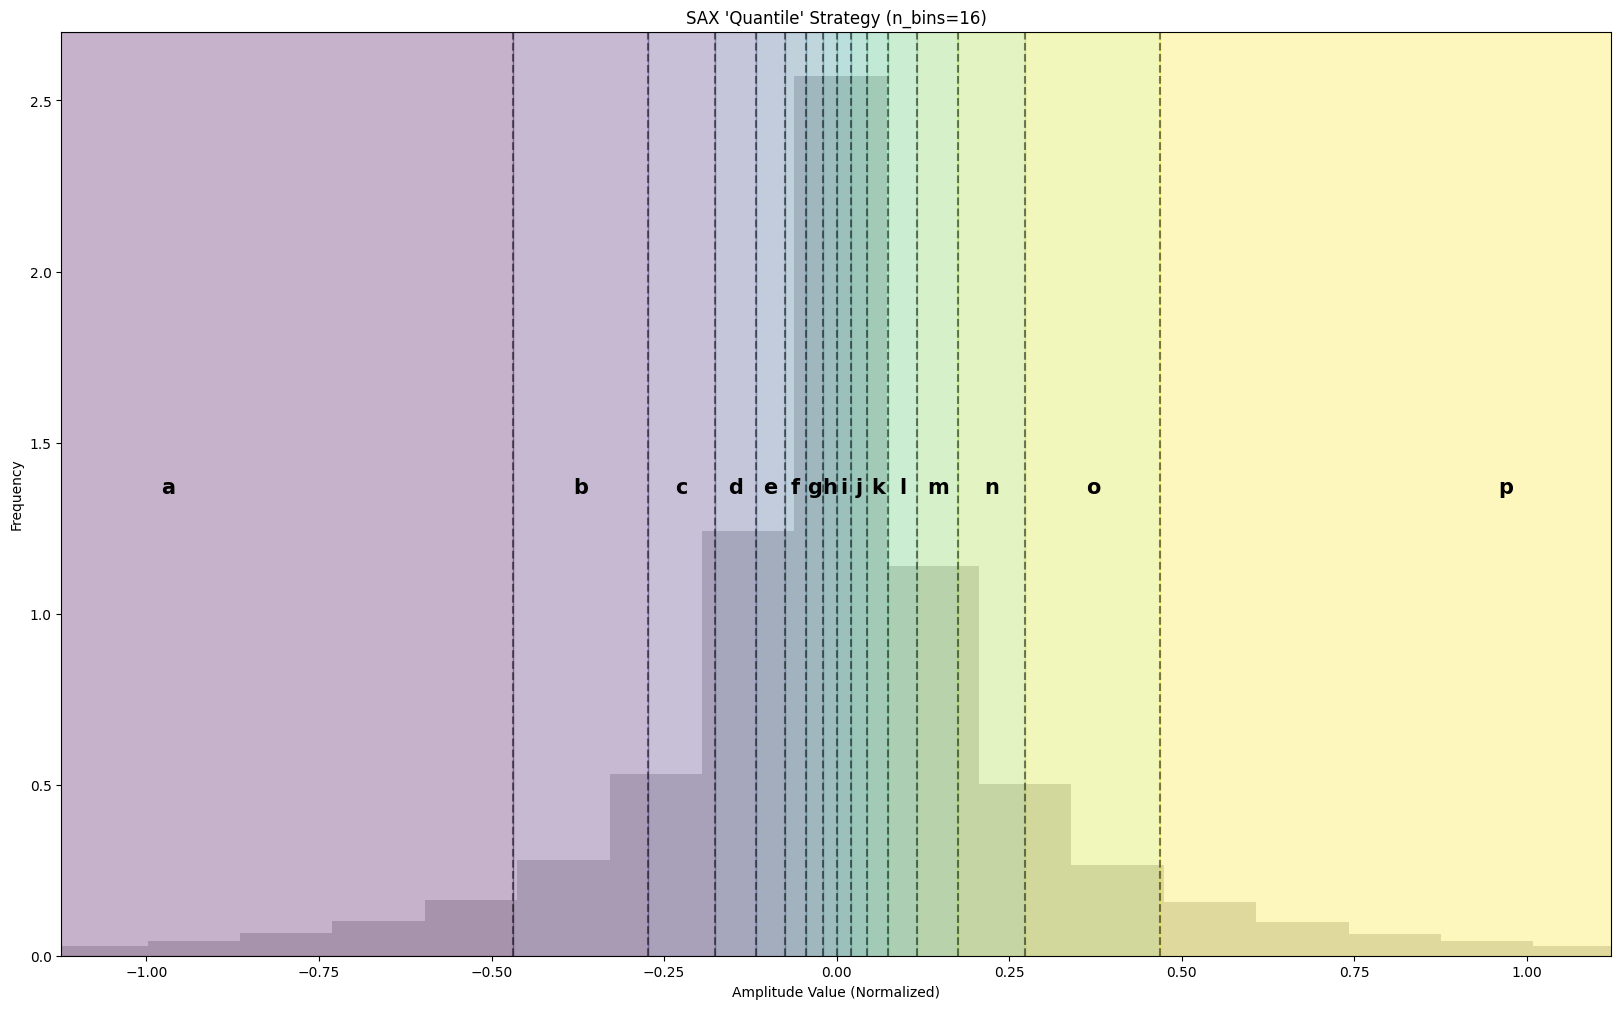

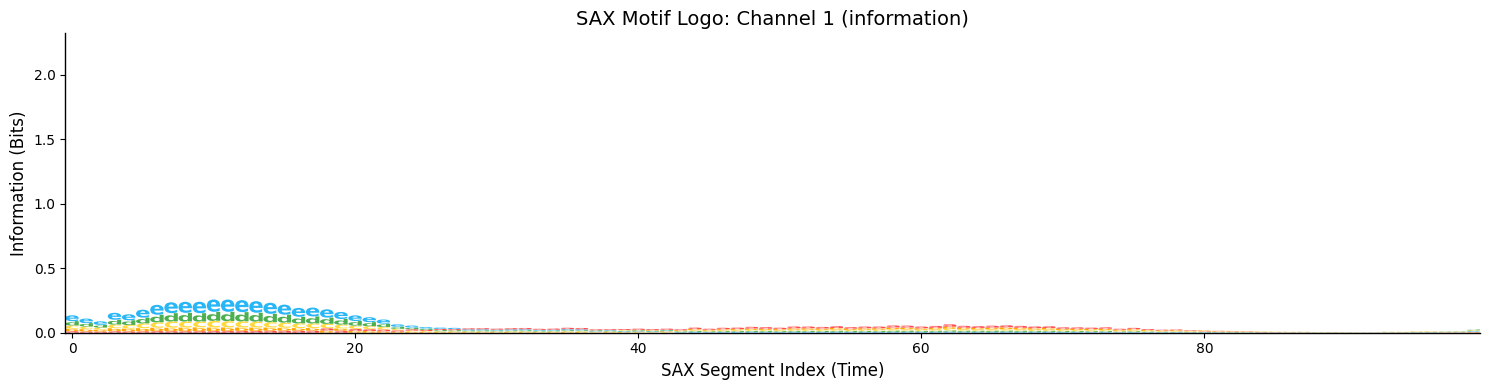

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.4692
Char 'b': -0.4692 to -0.2733
Char 'c': -0.2733 to -0.1763
Char 'd': -0.1763 to -0.1164
Char 'e': -0.1164 to -0.0751
Char 'f': -0.0751 to -0.0444
Char 'g': -0.0444 to -0.0203
Char 'h': -0.0203 to 0.0000
Char 'i': 0.0000 to 0.0203
Char 'j': 0.0203 to 0.0445
Char 'k': 0.0445 to 0.0751
Char 'l': 0.0751 to 0.1165
Char 'm': 0.1165 to 0.1765
Char 'n': 0.1765 to 0.2733
Char 'o': 0.2733 to 0.4694
Char 'p': 0.4694 to 7.0341


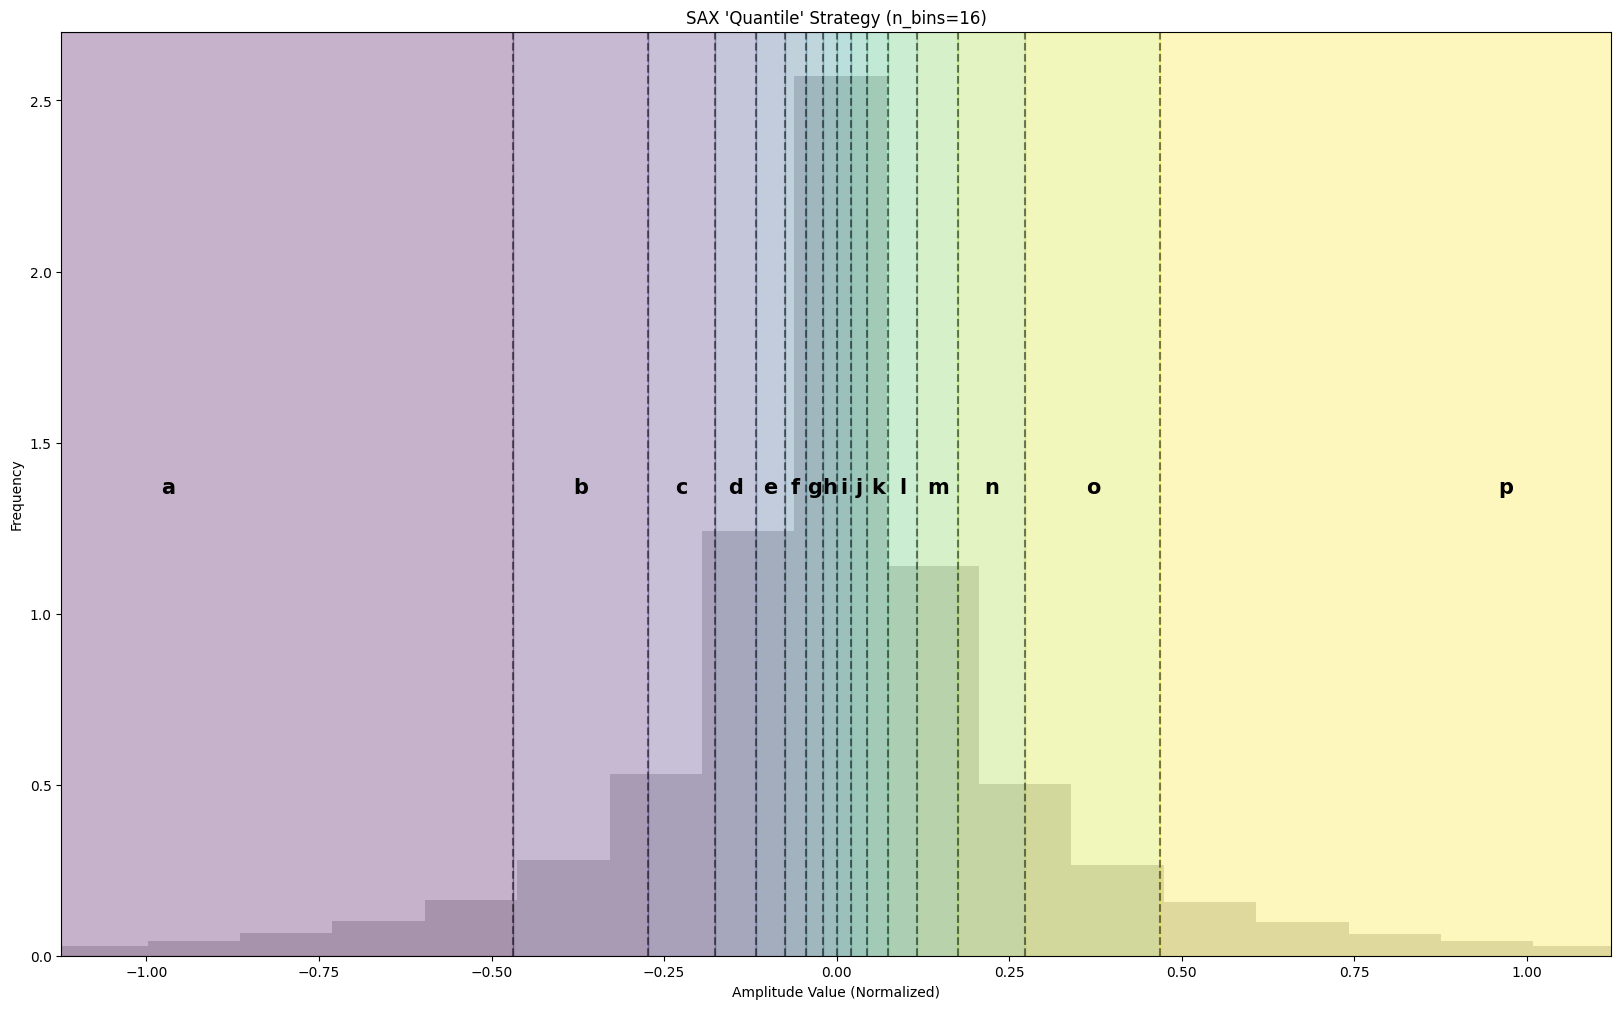

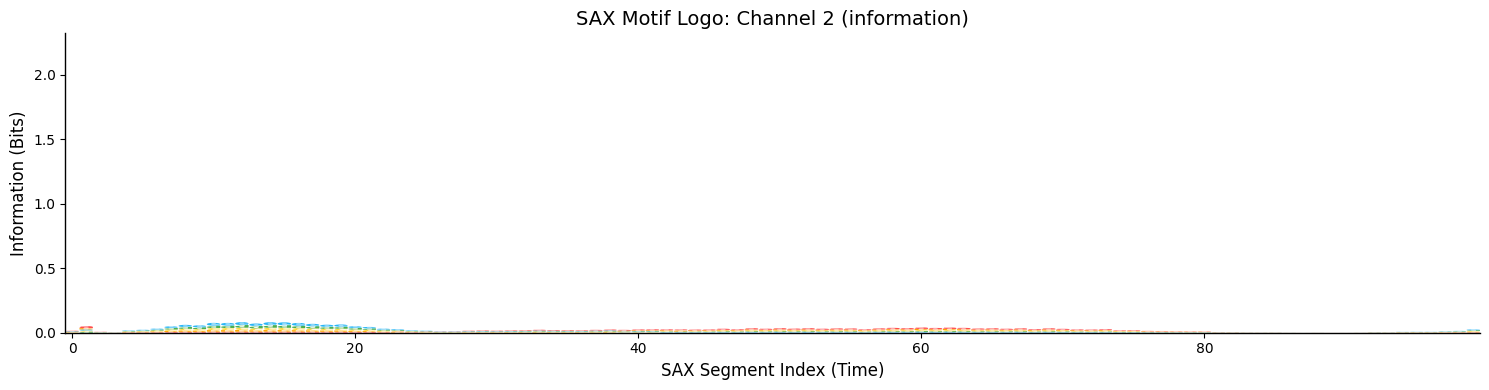

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.4692
Char 'b': -0.4692 to -0.2733
Char 'c': -0.2733 to -0.1763
Char 'd': -0.1763 to -0.1164
Char 'e': -0.1164 to -0.0751
Char 'f': -0.0751 to -0.0444
Char 'g': -0.0444 to -0.0203
Char 'h': -0.0203 to 0.0000
Char 'i': 0.0000 to 0.0203
Char 'j': 0.0203 to 0.0445
Char 'k': 0.0445 to 0.0751
Char 'l': 0.0751 to 0.1165
Char 'm': 0.1165 to 0.1765
Char 'n': 0.1765 to 0.2733
Char 'o': 0.2733 to 0.4694
Char 'p': 0.4694 to 7.0341


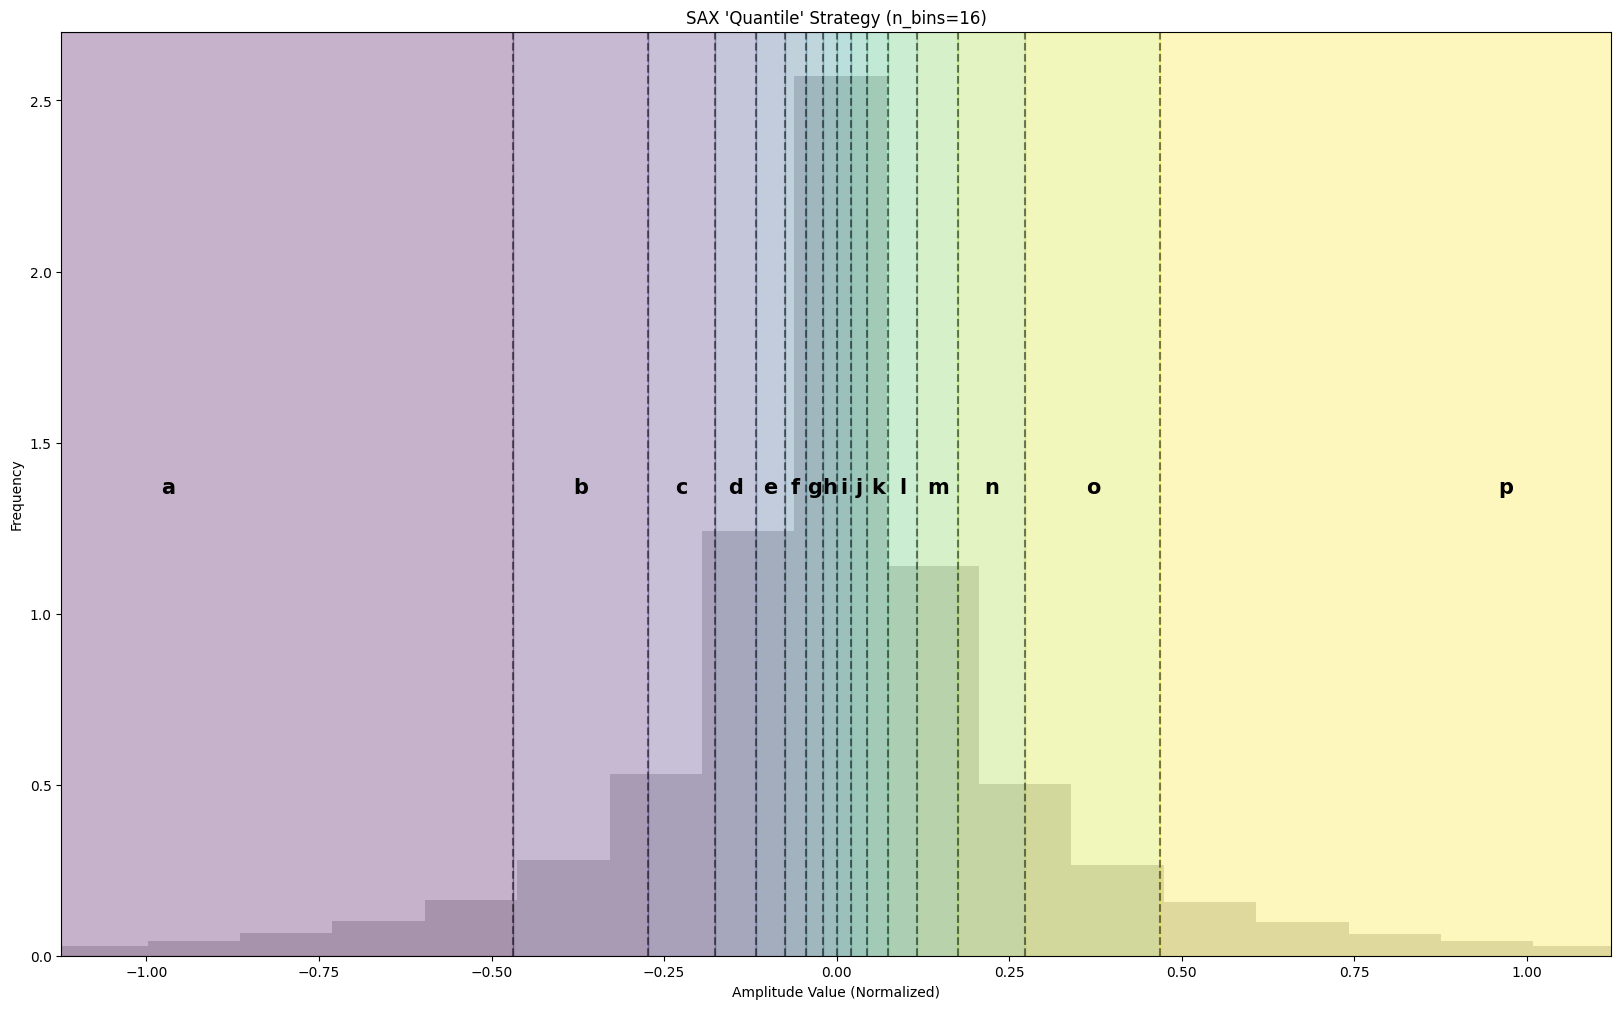

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 100)

--- Pattern Mining Input Check ---
Earthquake 0 String: sbvmljhntsfiitetjqktqbvcxaabphdxmhafxfaxjwaivmkcwjnrexdbwkpcwghngpqfugoueplnscvgudsudqkooiplhrrermlo|oreosdkseugdtfnteomkflqvaxaxxbwnawdsbxmphbrqivaxavpcwcugivbunjmsftdukcwcogpgmphlqerhithfpjjlqjinklhr|ksiftcvtbpnrilseqeoqdtexaxaxadjwvcvahcxbwcwblxawobuhmivhhlugkmkmjqqdrngudripfpreuftglsfnpkngpmhoojjs


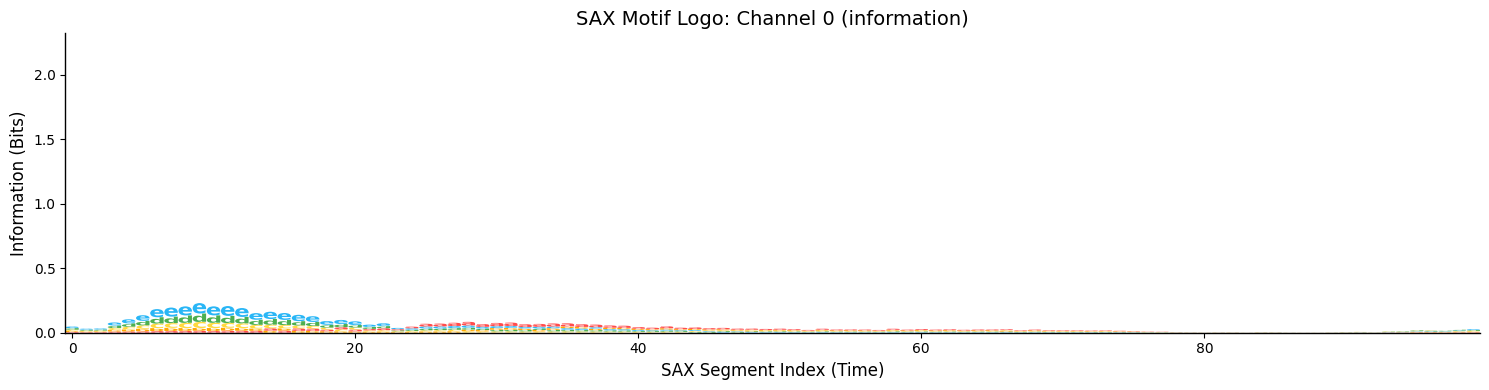

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.5988
Char 'b': -0.5988 to -0.3834
Char 'c': -0.3834 to -0.2733
Char 'd': -0.2733 to -0.2030
Char 'e': -0.2030 to -0.1535
Char 'f': -0.1535 to -0.1164
Char 'g': -0.1164 to -0.0874
Char 'h': -0.0874 to -0.0639
Char 'i': -0.0639 to -0.0444
Char 'j': -0.0444 to -0.0278
Char 'k': -0.0278 to -0.0132
Char 'l': -0.0132 to 0.0000
Char 'm': 0.0000 to 0.0133
Char 'n': 0.0133 to 0.0278
Char 'o': 0.0278 to 0.0445
Char 'p': 0.0445 to 0.0640
Char 'q': 0.0640 to 0.0874
Char 'r': 0.0874 to 0.1165
Char 's': 0.1165 to 0.1537
Char 't': 0.1537 to 0.2032
Char 'u': 0.2032 to 0.2733
Char 'v': 0.2733 to 0.3836
Char 'w': 0.3836 to 0.5985
Char 'x': 0.5985 to 7.0341


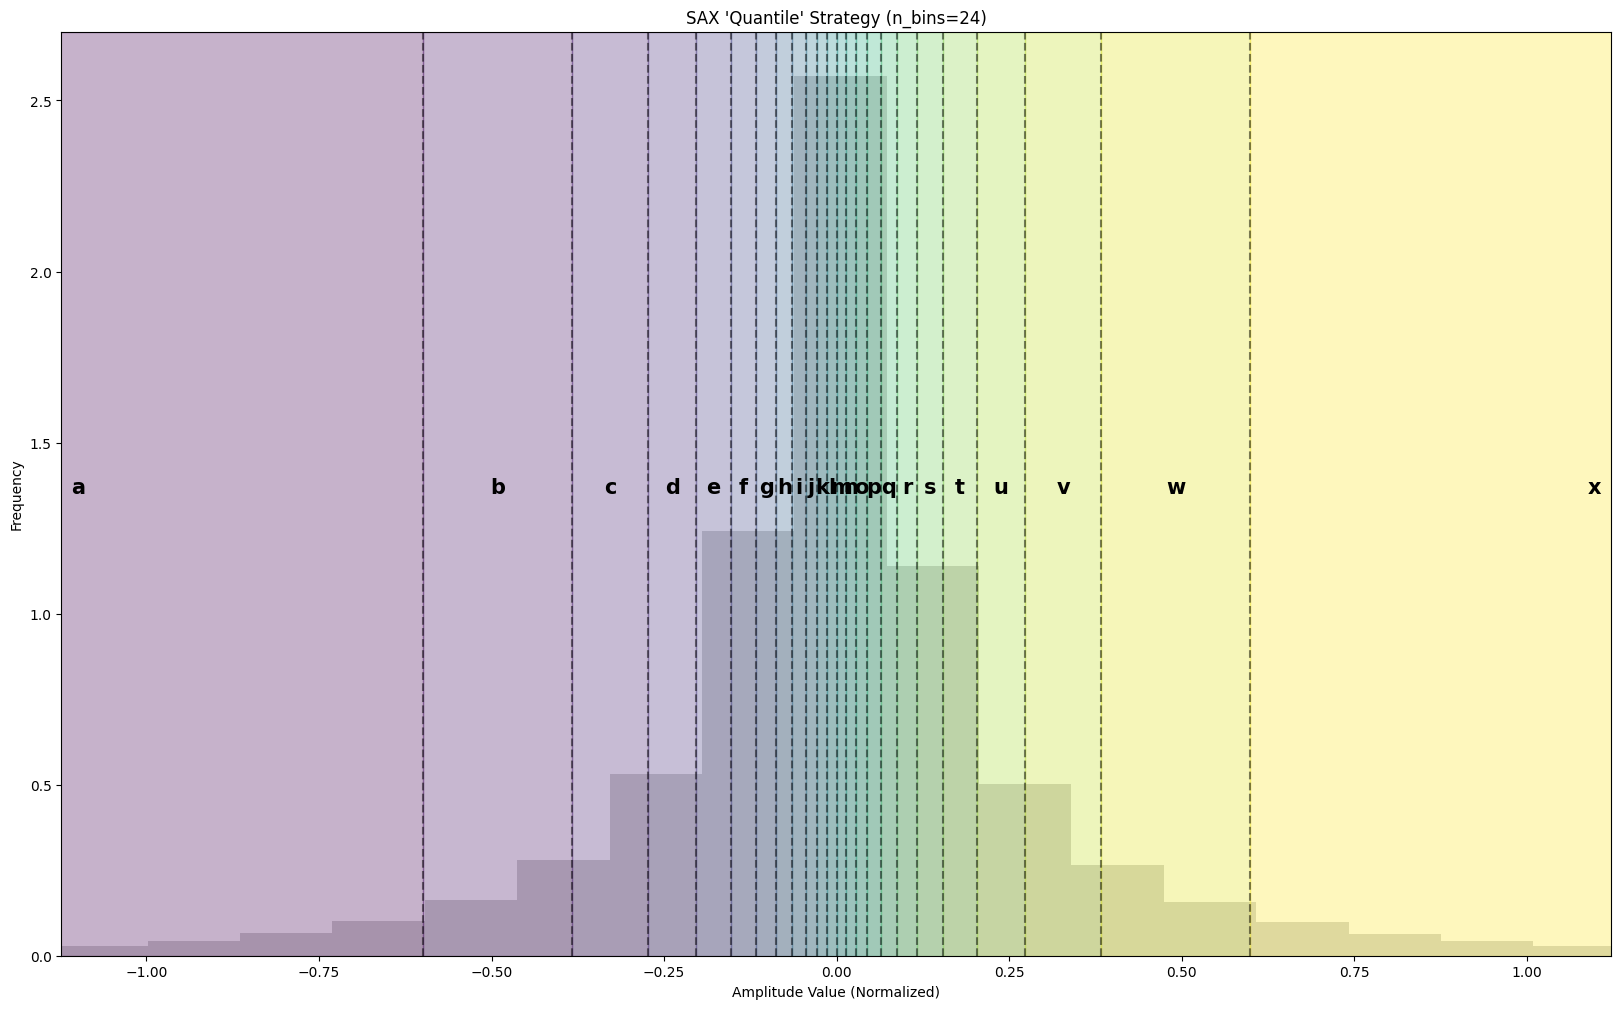

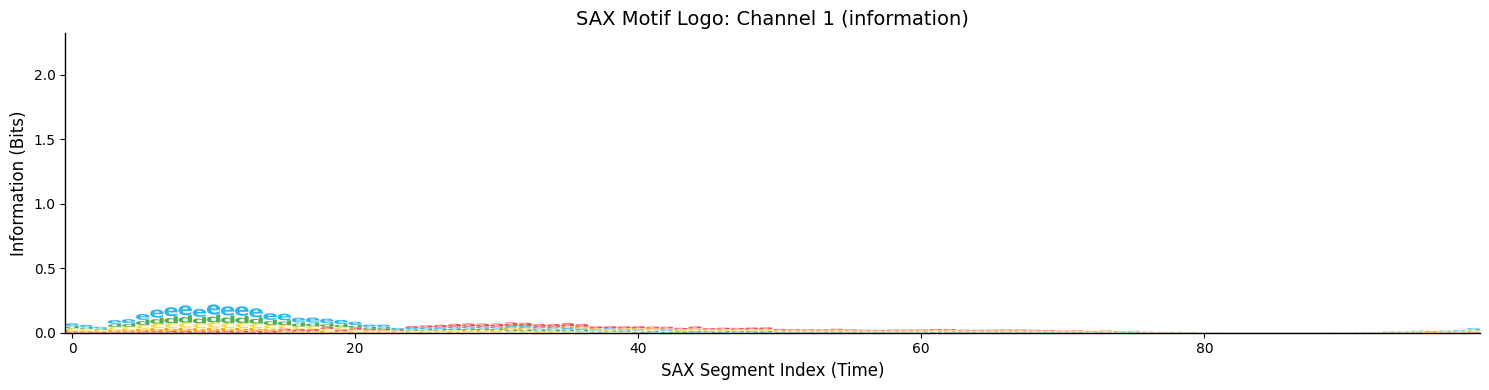

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.5988
Char 'b': -0.5988 to -0.3834
Char 'c': -0.3834 to -0.2733
Char 'd': -0.2733 to -0.2030
Char 'e': -0.2030 to -0.1535
Char 'f': -0.1535 to -0.1164
Char 'g': -0.1164 to -0.0874
Char 'h': -0.0874 to -0.0639
Char 'i': -0.0639 to -0.0444
Char 'j': -0.0444 to -0.0278
Char 'k': -0.0278 to -0.0132
Char 'l': -0.0132 to 0.0000
Char 'm': 0.0000 to 0.0133
Char 'n': 0.0133 to 0.0278
Char 'o': 0.0278 to 0.0445
Char 'p': 0.0445 to 0.0640
Char 'q': 0.0640 to 0.0874
Char 'r': 0.0874 to 0.1165
Char 's': 0.1165 to 0.1537
Char 't': 0.1537 to 0.2032
Char 'u': 0.2032 to 0.2733
Char 'v': 0.2733 to 0.3836
Char 'w': 0.3836 to 0.5985
Char 'x': 0.5985 to 7.0341


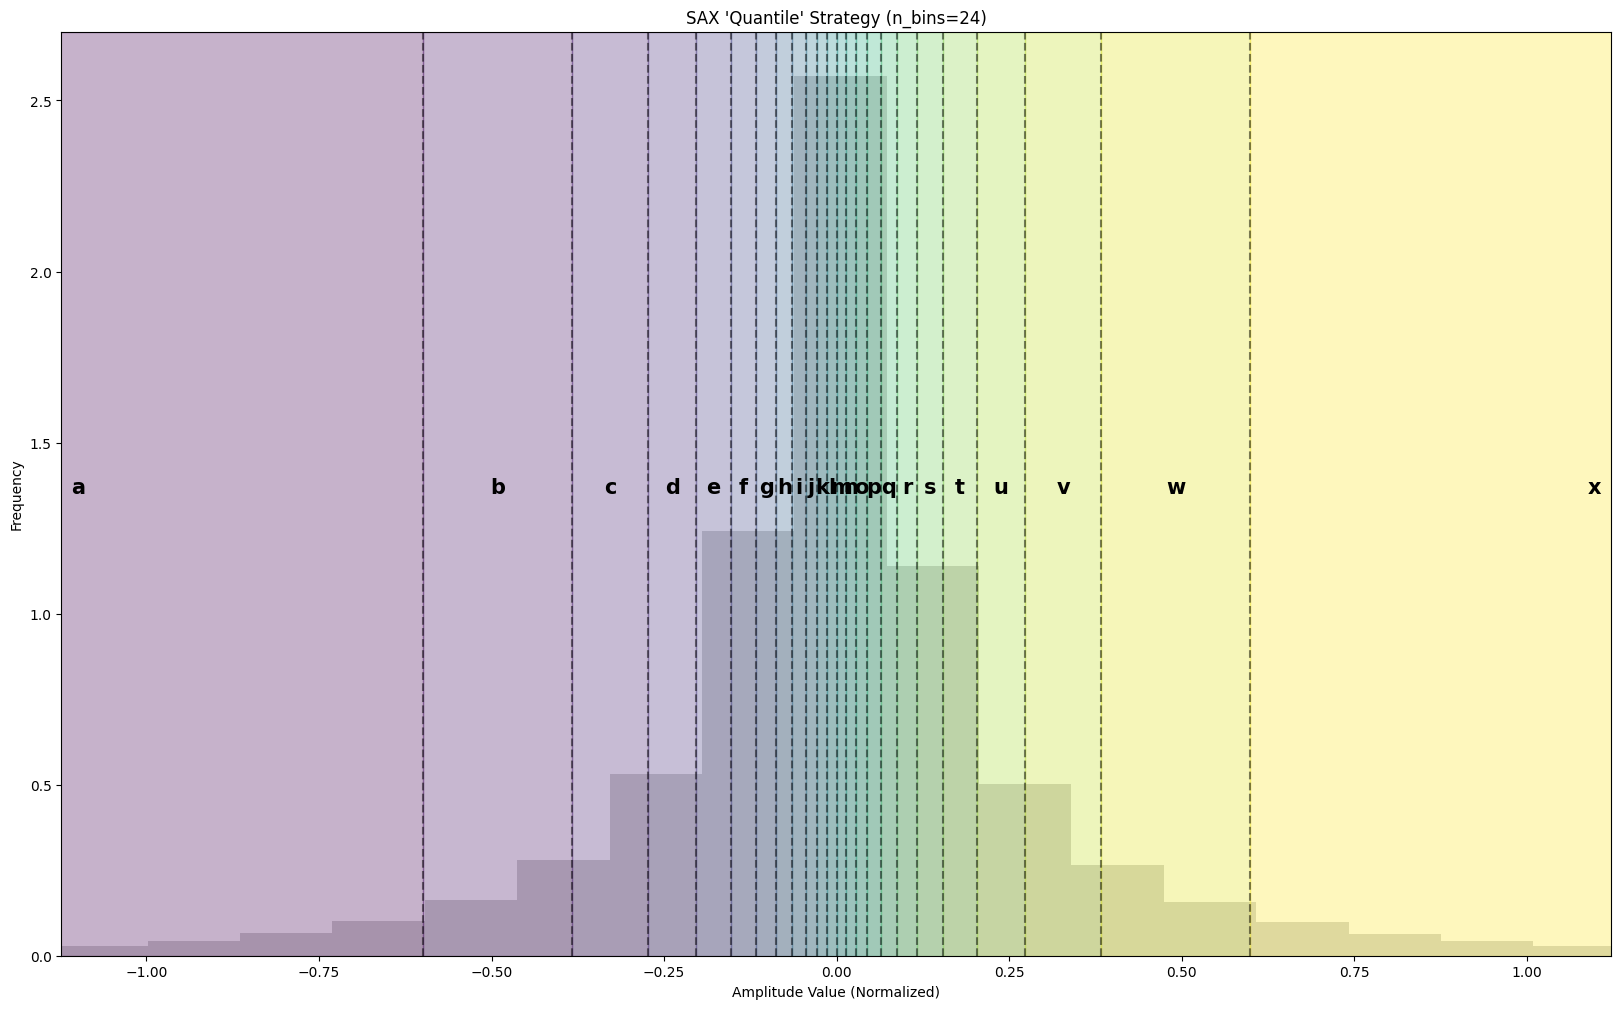

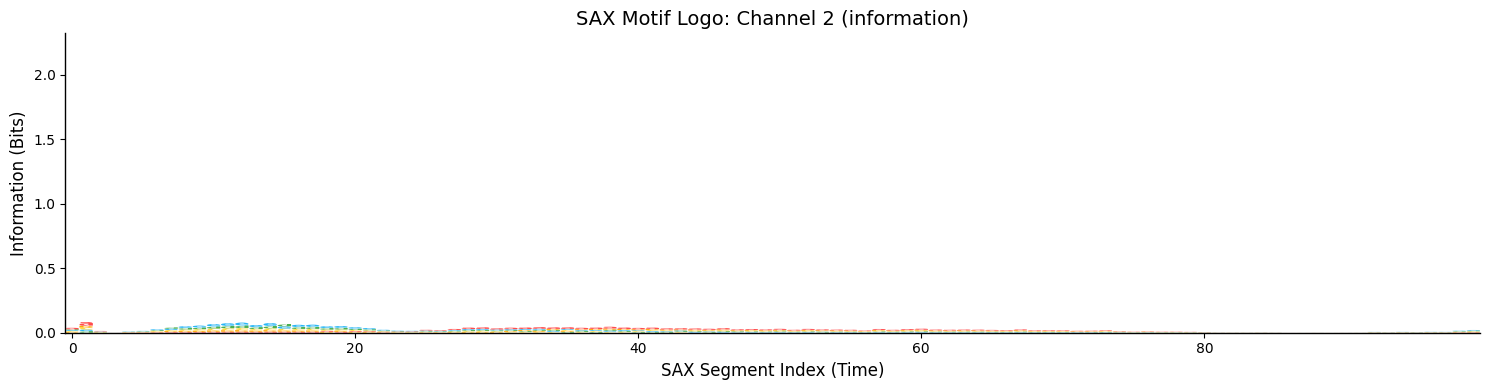

--- Learned Quantile Thresholds ---
Char 'a': -6.3533 to -0.5988
Char 'b': -0.5988 to -0.3834
Char 'c': -0.3834 to -0.2733
Char 'd': -0.2733 to -0.2030
Char 'e': -0.2030 to -0.1535
Char 'f': -0.1535 to -0.1164
Char 'g': -0.1164 to -0.0874
Char 'h': -0.0874 to -0.0639
Char 'i': -0.0639 to -0.0444
Char 'j': -0.0444 to -0.0278
Char 'k': -0.0278 to -0.0132
Char 'l': -0.0132 to 0.0000
Char 'm': 0.0000 to 0.0133
Char 'n': 0.0133 to 0.0278
Char 'o': 0.0278 to 0.0445
Char 'p': 0.0445 to 0.0640
Char 'q': 0.0640 to 0.0874
Char 'r': 0.0874 to 0.1165
Char 's': 0.1165 to 0.1537
Char 't': 0.1537 to 0.2032
Char 'u': 0.2032 to 0.2733
Char 'v': 0.2733 to 0.3836
Char 'w': 0.3836 to 0.5985
Char 'x': 0.5985 to 7.0341


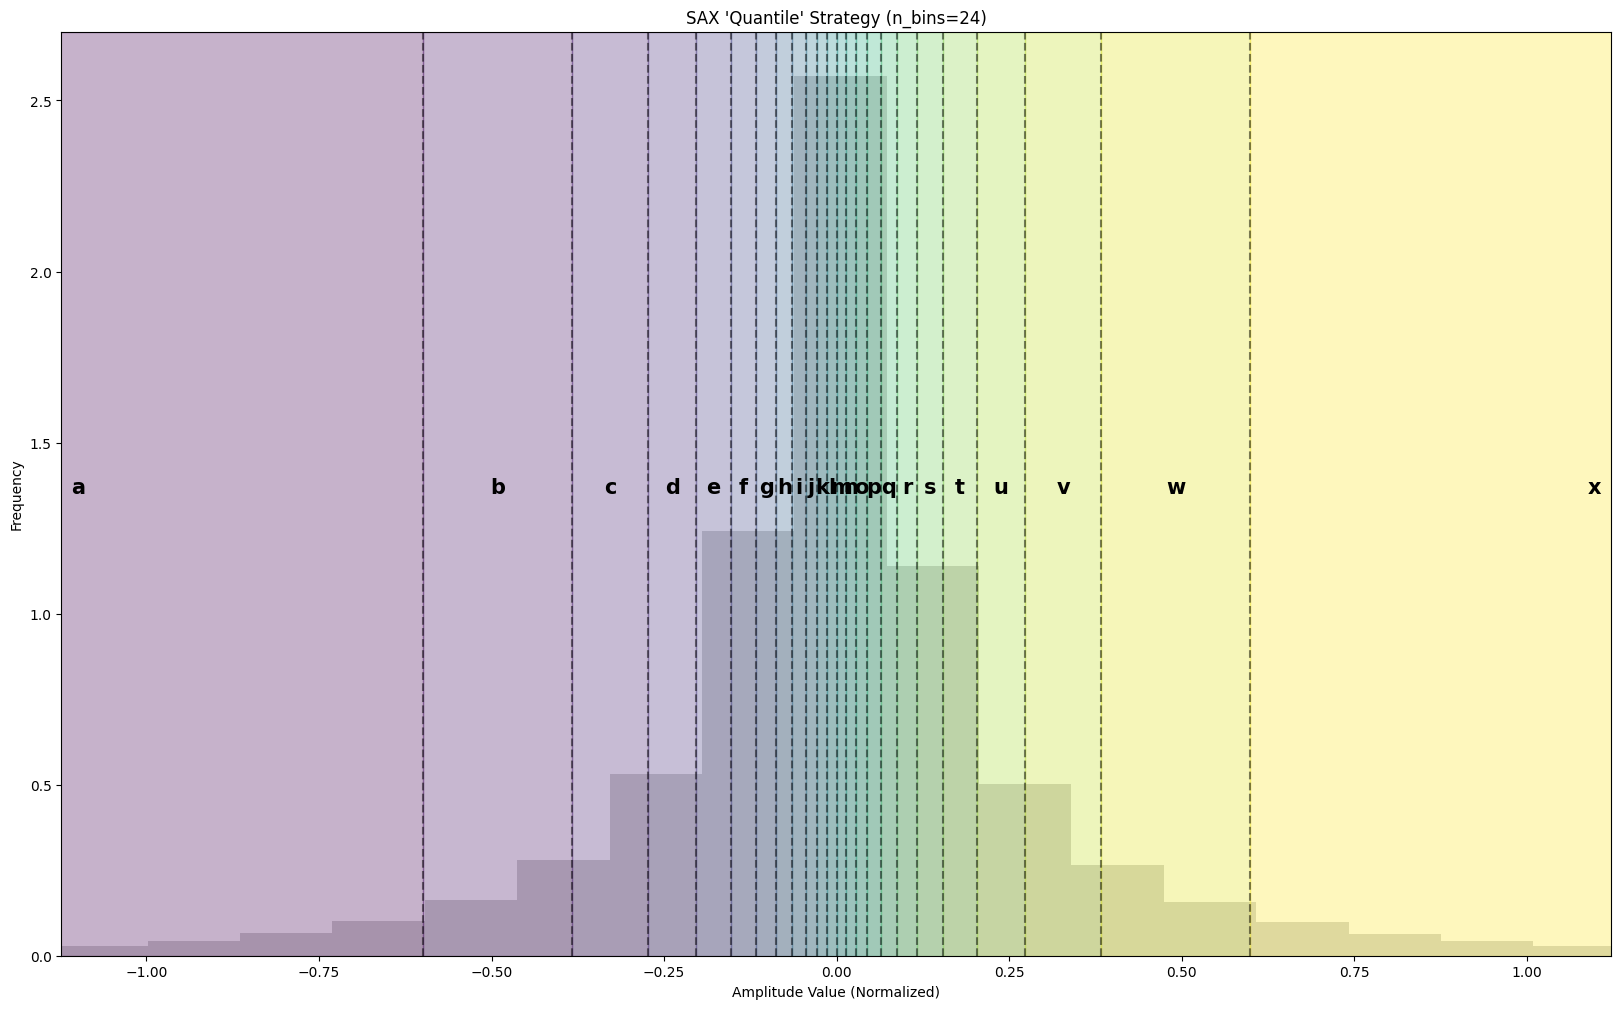

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 200)

--- Pattern Mining Input Check ---
Earthquake 0 String: ahbcegbgbgcdgafcfebgbegbfbgecchaecfegbgcfebbhceaghagahhaahahhachgbhaeahaehahcahcahhdafhahbahhabbgghacfgcdcdhagfahbcfaheaggcdbggbebgceeebegfbgcffccdfdedeefcbgfebdgbcfdfebcfdddfdedcddfddddefefbdfddefcdf|fdffagcgahbdeegedcegcebdgdebgcgddbfdgcgbceedgdhbabahaahabhabghhafahefbaheahhahahceachaahbgchaahcbahgdgcbdhbcfgahdechbahagbgbfdffgafgbdfgbhbbehbdfeceefgadfdfecfccgfbdgececffddeceffcdefchbcedefcfcgbddeg|habhecebffdahdcgbahagccgdcgbfeccgdebhbefbdhbdbdhaahhahghahfahaggahbcahafhahahcbaahcadhacahghabgheeafgdbecegbehahdccffgaggbcfbfgbecgdefbbdgdfebgfdbcgecdfdbgdfebdfgafgecdceffccfdfeddcfcdefedeceedegbbgfe


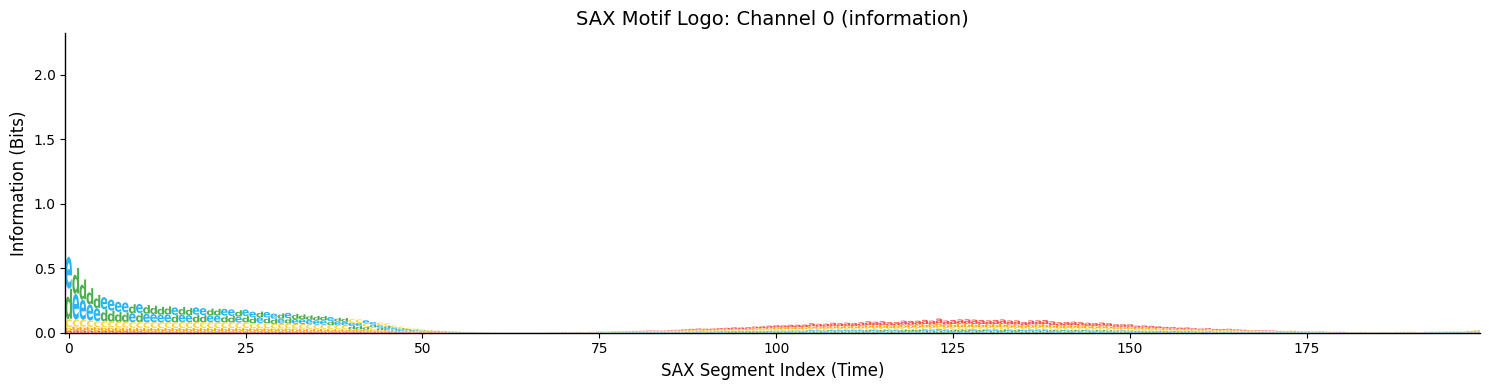

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -0.4843
Char 'b': -0.4843 to -0.2139
Char 'c': -0.2139 to -0.0830
Char 'd': -0.0830 to 0.0001
Char 'e': 0.0001 to 0.0831
Char 'f': 0.0831 to 0.2138
Char 'g': 0.2138 to 0.4847
Char 'h': 0.4847 to 9.8183


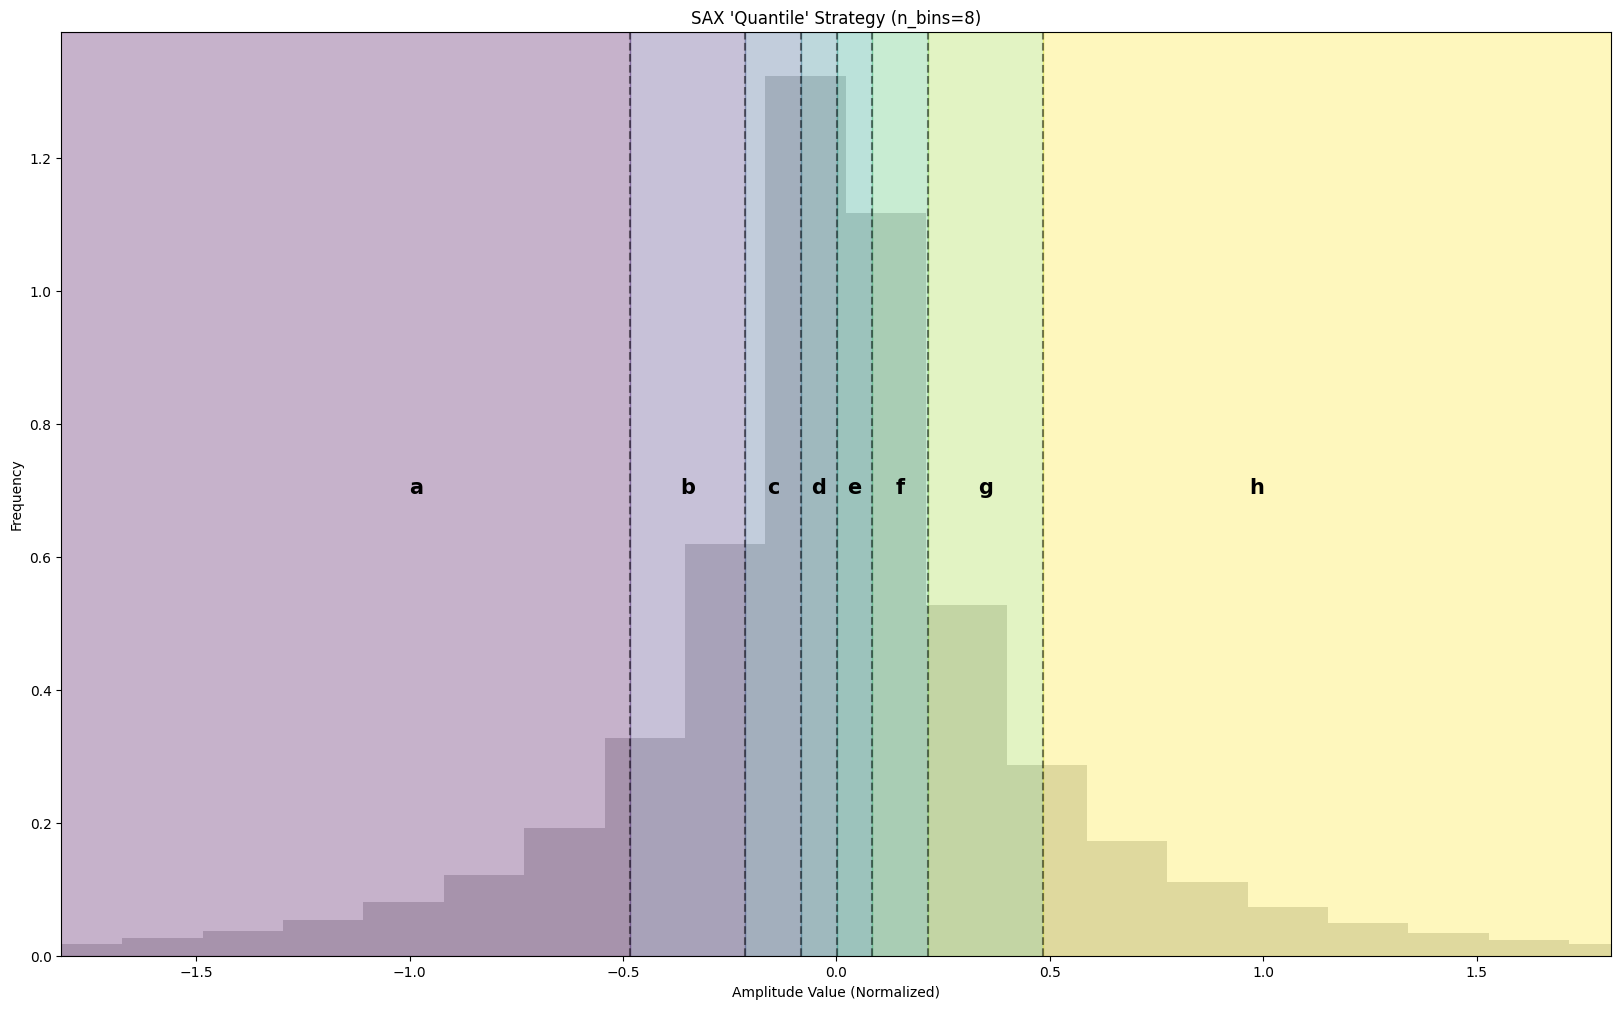

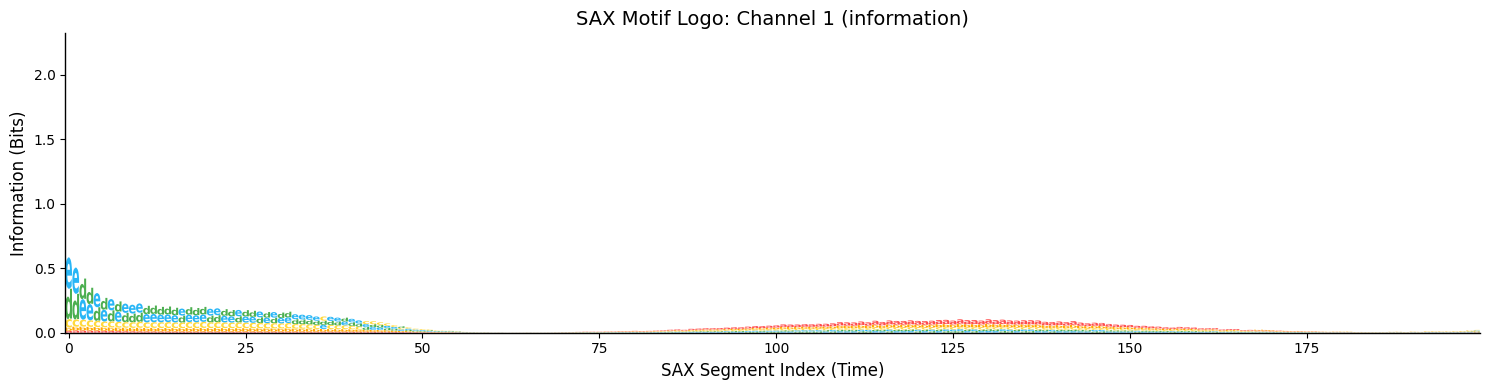

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -0.4843
Char 'b': -0.4843 to -0.2139
Char 'c': -0.2139 to -0.0830
Char 'd': -0.0830 to 0.0001
Char 'e': 0.0001 to 0.0831
Char 'f': 0.0831 to 0.2138
Char 'g': 0.2138 to 0.4847
Char 'h': 0.4847 to 9.8183


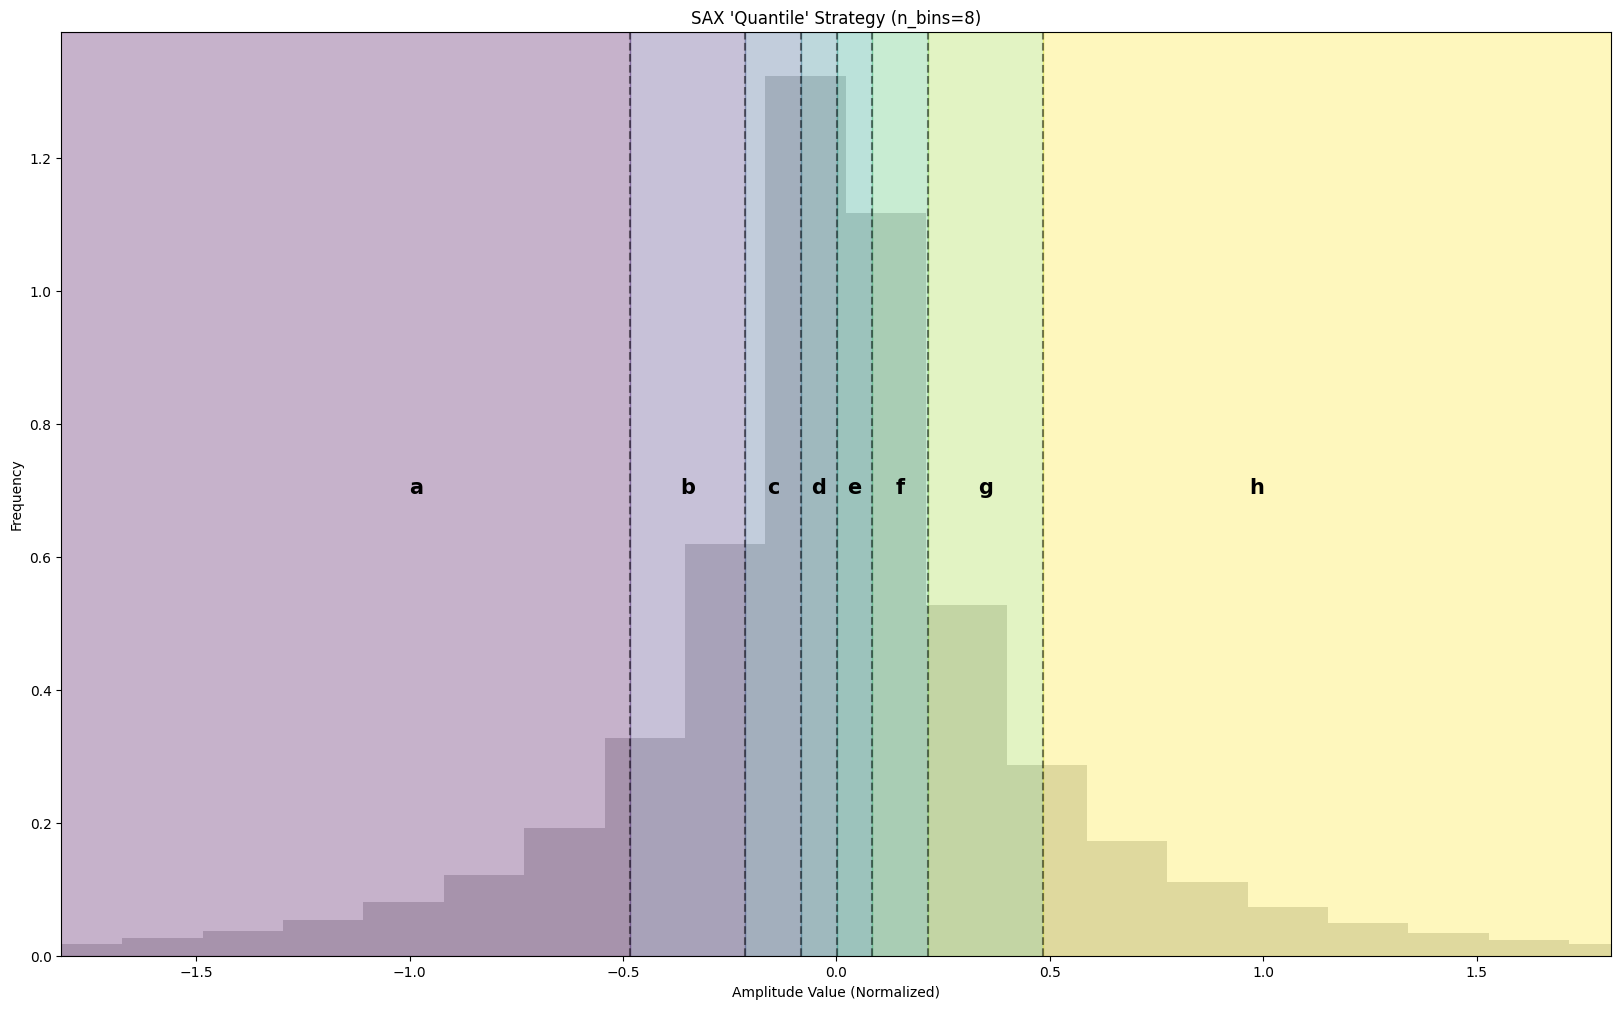

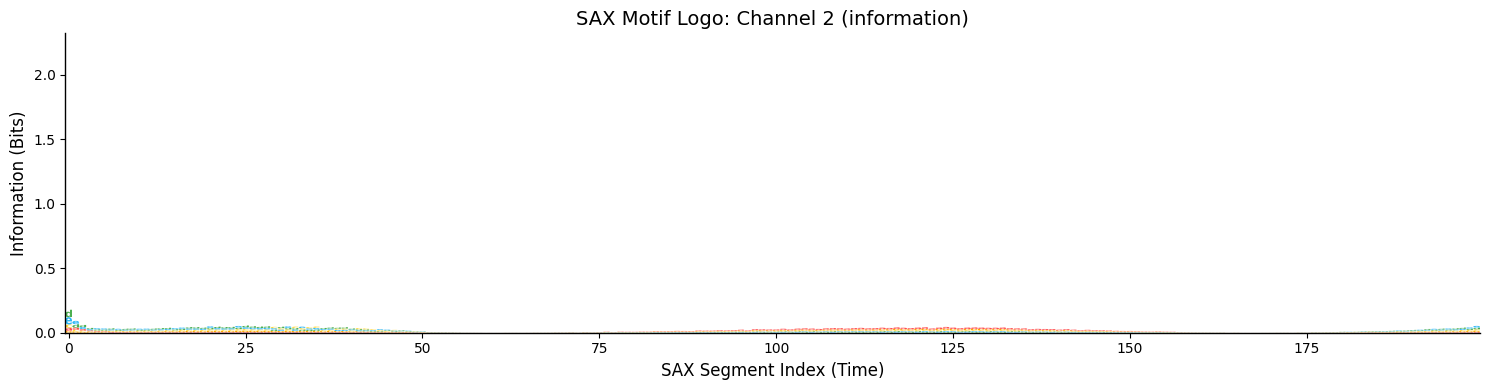

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -0.4843
Char 'b': -0.4843 to -0.2139
Char 'c': -0.2139 to -0.0830
Char 'd': -0.0830 to 0.0001
Char 'e': 0.0001 to 0.0831
Char 'f': 0.0831 to 0.2138
Char 'g': 0.2138 to 0.4847
Char 'h': 0.4847 to 9.8183


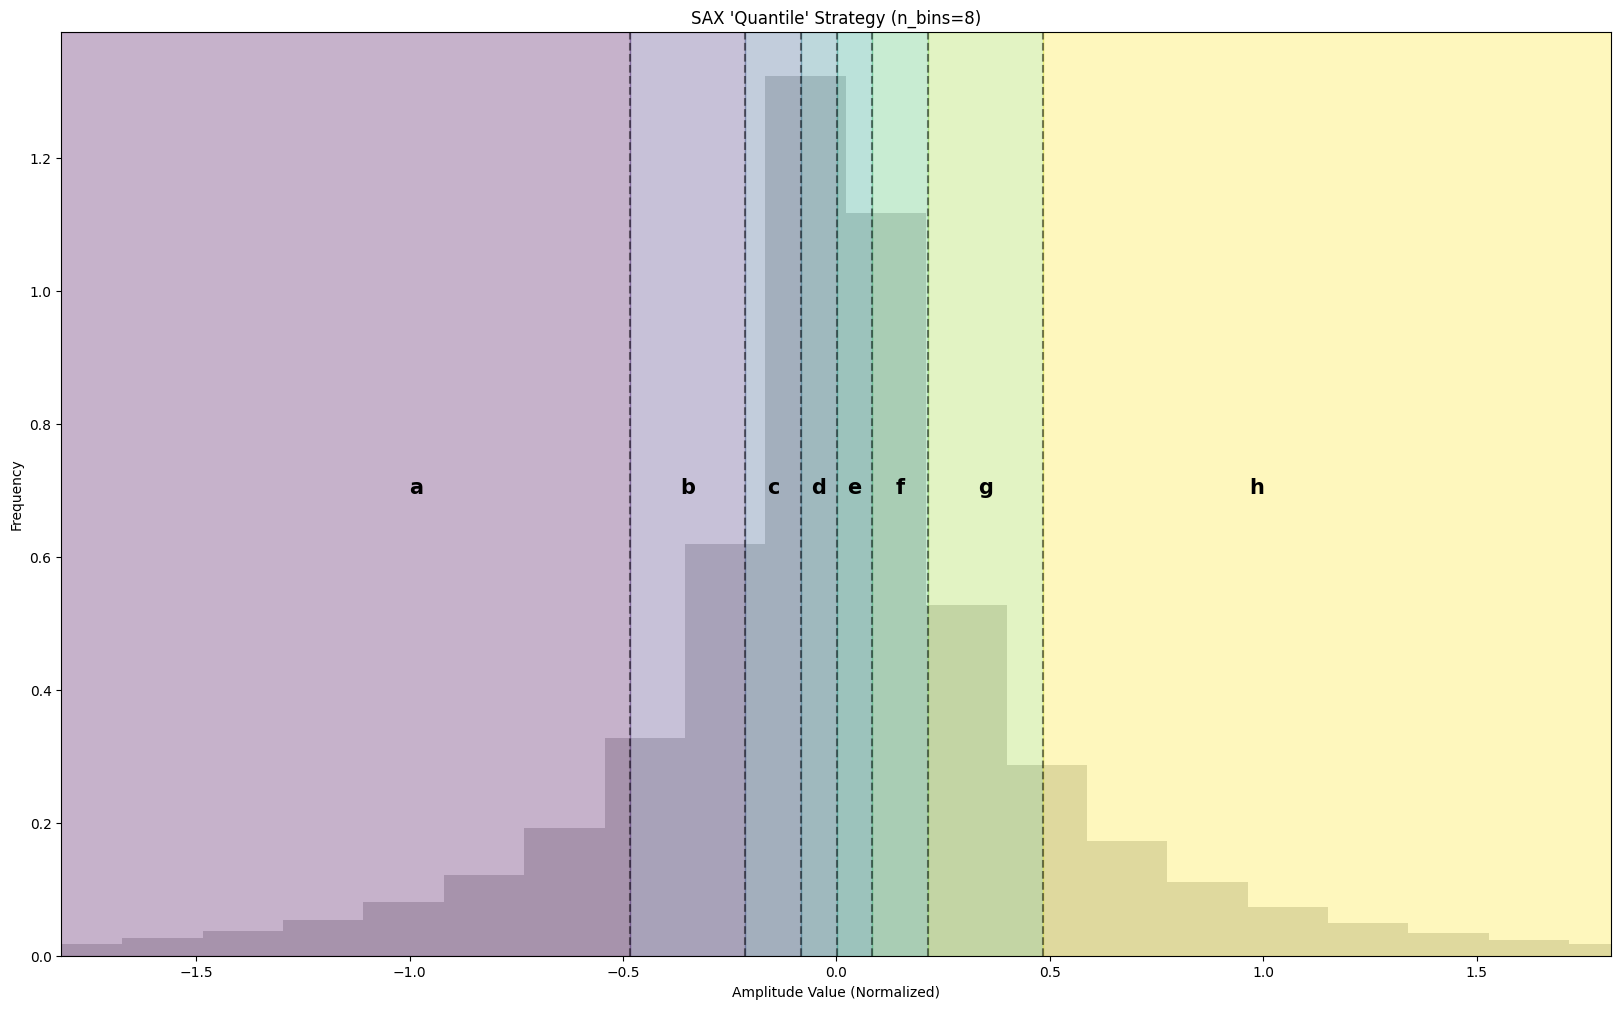

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 200)

--- Pattern Mining Input Check ---
Earthquake 0 String: bpceincncnfhmblflidncjmclcmifeobjfkimcnfkiddoejbnpamaopaapapoafpndpajbpajpaoebpfaoogakpaodapobddmmobflnegegobnkbpdelbojbmnehcmncjdnfjijcjmkcmflkeehkgjhiikecmlidgndelhljdflghhlgjhfhhkhgggikikcgkhgilegl|lgkkbmfmbpchiimihejnejdgnhjdmenhgdlhmendeijgmgpcadbpaapadpbdnooblaojkcapiapoapbofibepaapcneoabpfcaomgmecgpdelnaogieocbpbncmdkglknblmdhkncoccjochkjejiknbgkhljflfenlchmifjfklghiejkkfhilfodfjgilflfndghjm|padoiejclkhbogendbpamefnhfmdljefmhicocilchochchpaaopapnpaplbpannbpceapakpaoapfcbbpfbgobebonoadnoijalnhdjfjmcjobogeelkmbnmdfkdlncifngilddhmgkidmkgcfnjehlhdmglicgknblmjegfjkkfekgkighflegjkjgieijhjmdcmli


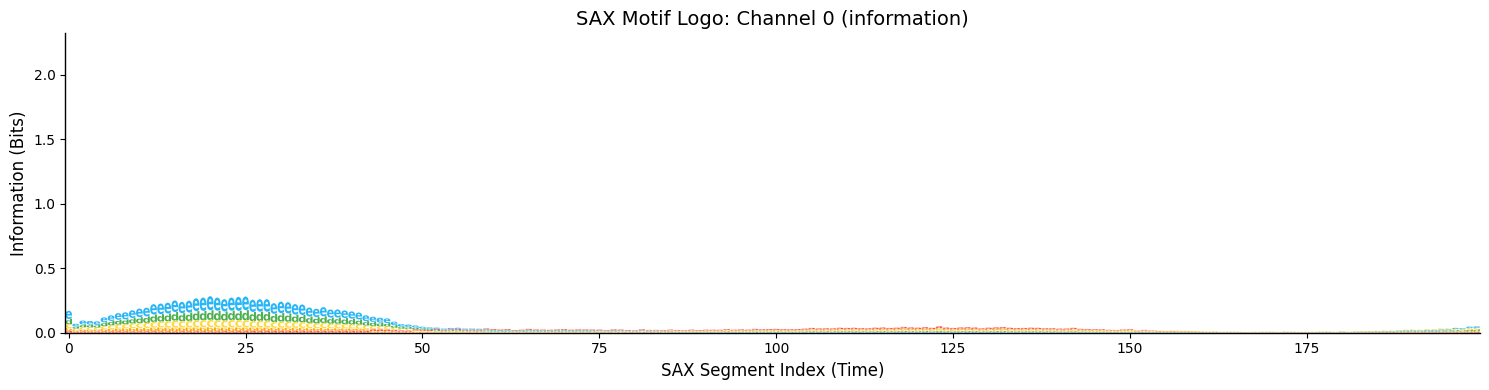

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -0.8077
Char 'b': -0.8077 to -0.4843
Char 'c': -0.4843 to -0.3189
Char 'd': -0.3189 to -0.2139
Char 'e': -0.2139 to -0.1394
Char 'f': -0.1394 to -0.0830
Char 'g': -0.0830 to -0.0379
Char 'h': -0.0379 to 0.0001
Char 'i': 0.0001 to 0.0380
Char 'j': 0.0380 to 0.0831
Char 'k': 0.0831 to 0.1394
Char 'l': 0.1394 to 0.2138
Char 'm': 0.2138 to 0.3190
Char 'n': 0.3190 to 0.4847
Char 'o': 0.4847 to 0.8077
Char 'p': 0.8077 to 9.8183


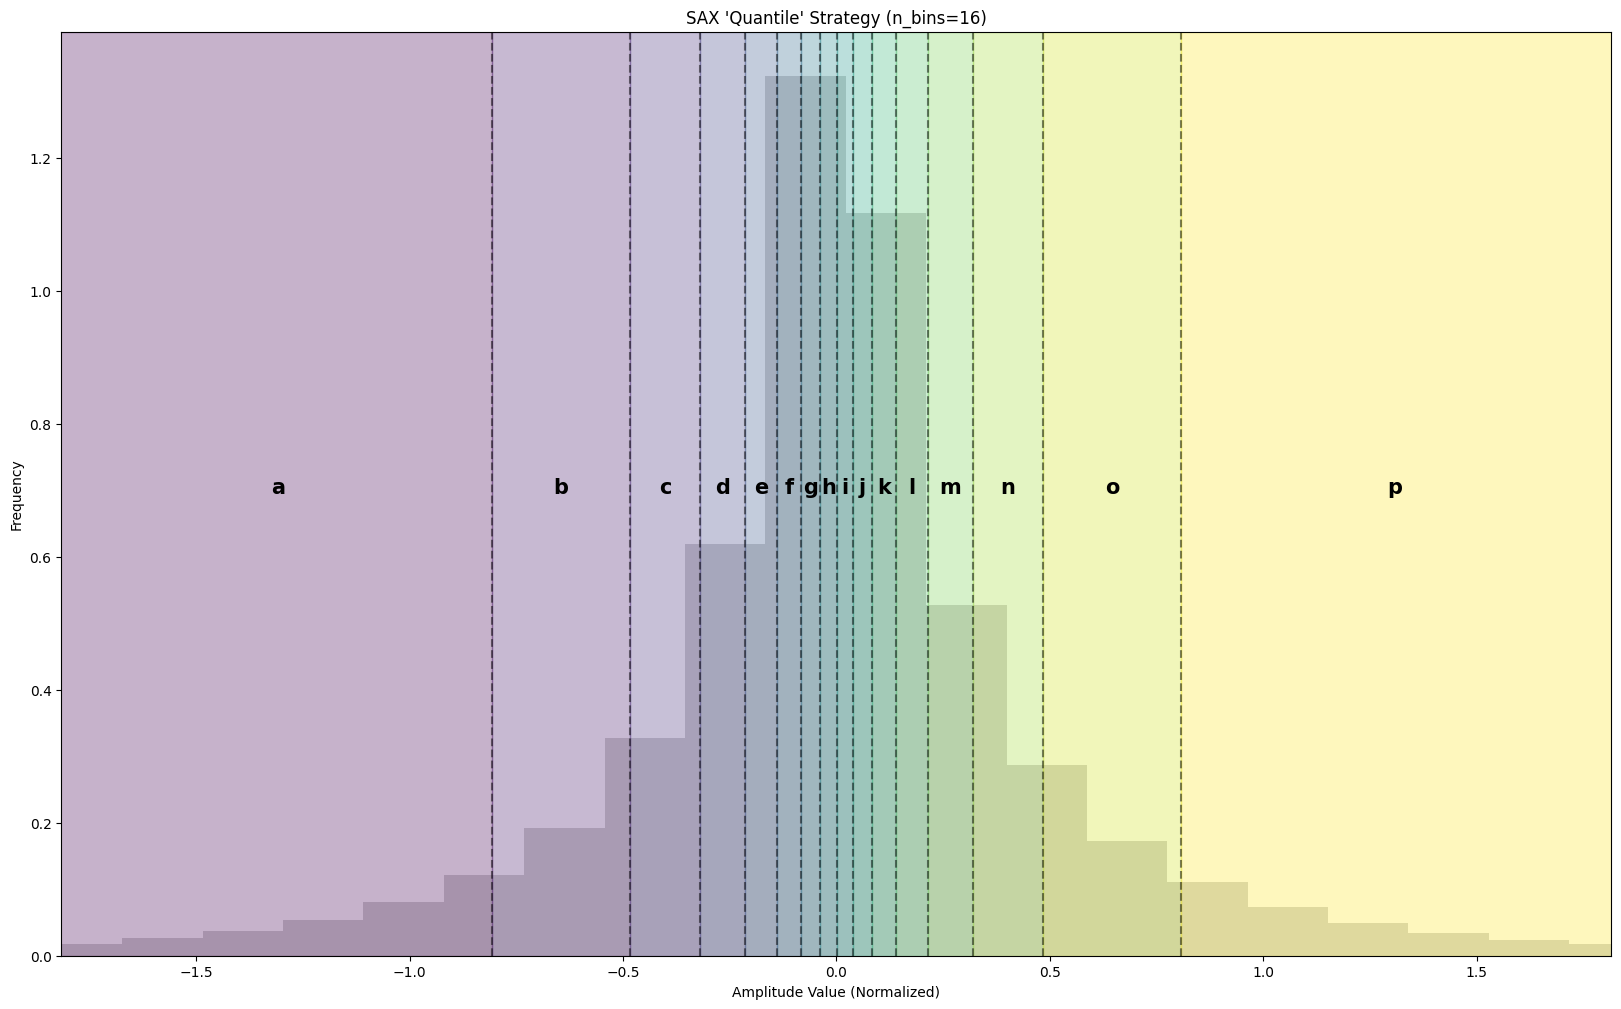

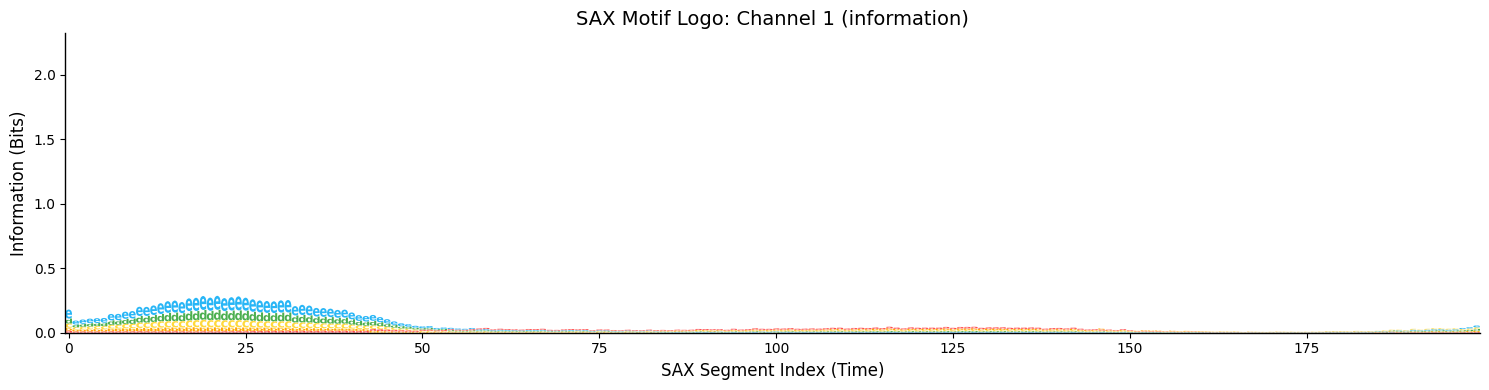

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -0.8077
Char 'b': -0.8077 to -0.4843
Char 'c': -0.4843 to -0.3189
Char 'd': -0.3189 to -0.2139
Char 'e': -0.2139 to -0.1394
Char 'f': -0.1394 to -0.0830
Char 'g': -0.0830 to -0.0379
Char 'h': -0.0379 to 0.0001
Char 'i': 0.0001 to 0.0380
Char 'j': 0.0380 to 0.0831
Char 'k': 0.0831 to 0.1394
Char 'l': 0.1394 to 0.2138
Char 'm': 0.2138 to 0.3190
Char 'n': 0.3190 to 0.4847
Char 'o': 0.4847 to 0.8077
Char 'p': 0.8077 to 9.8183


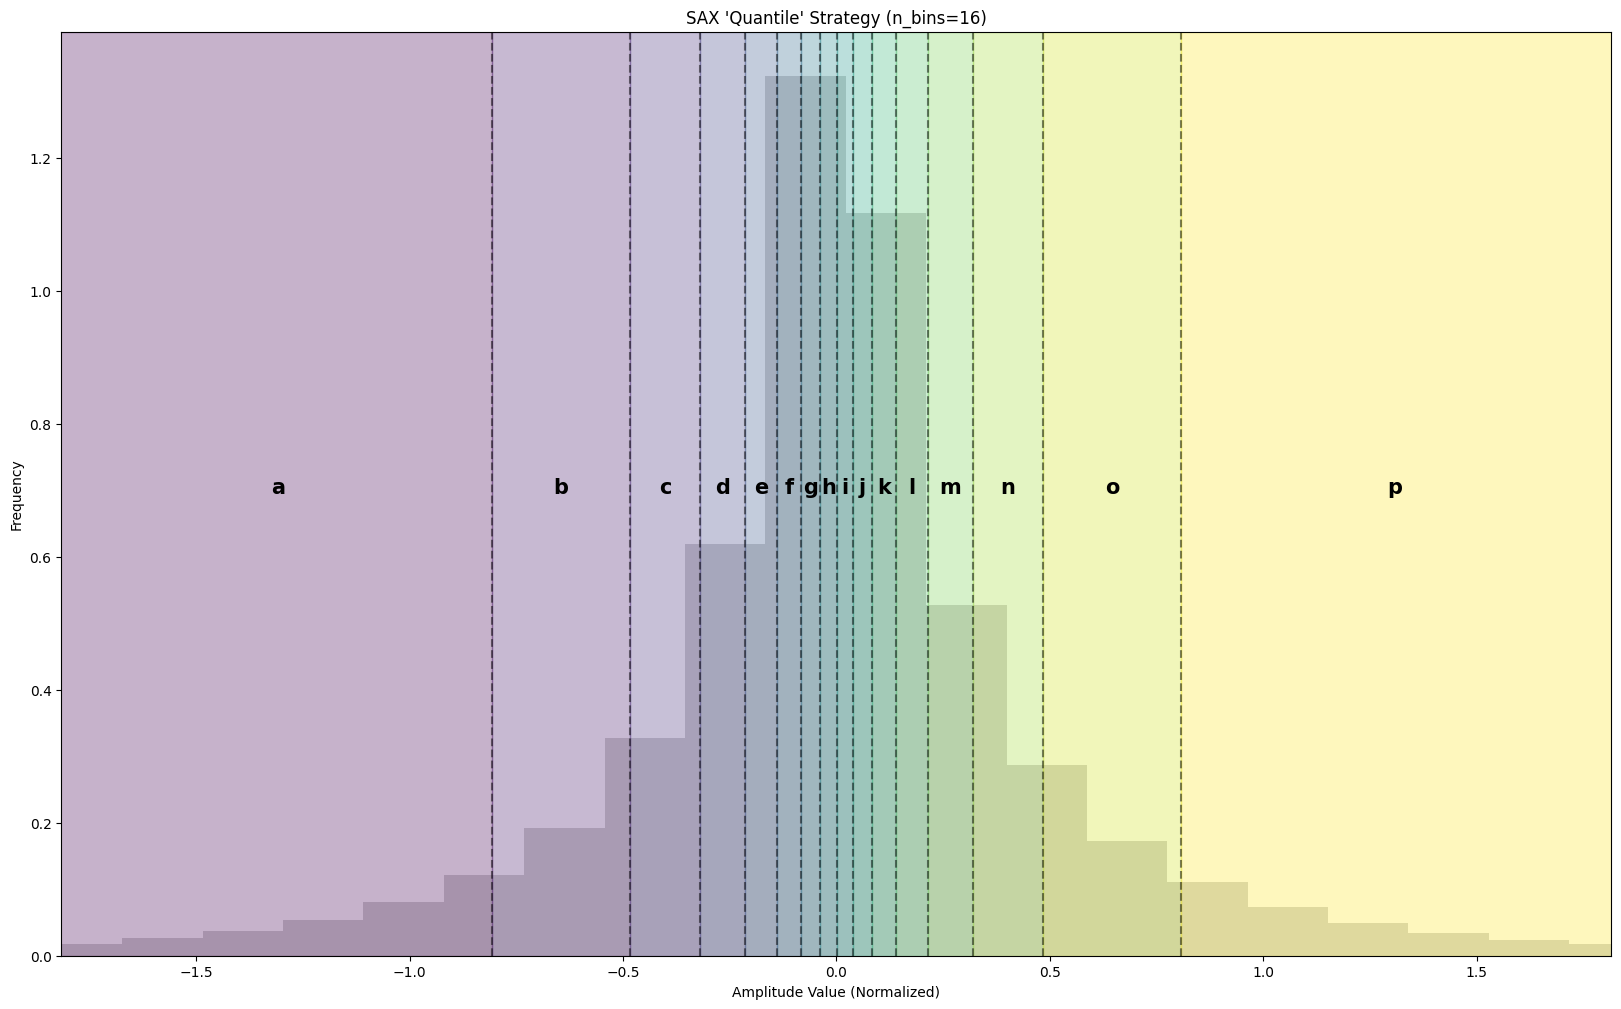

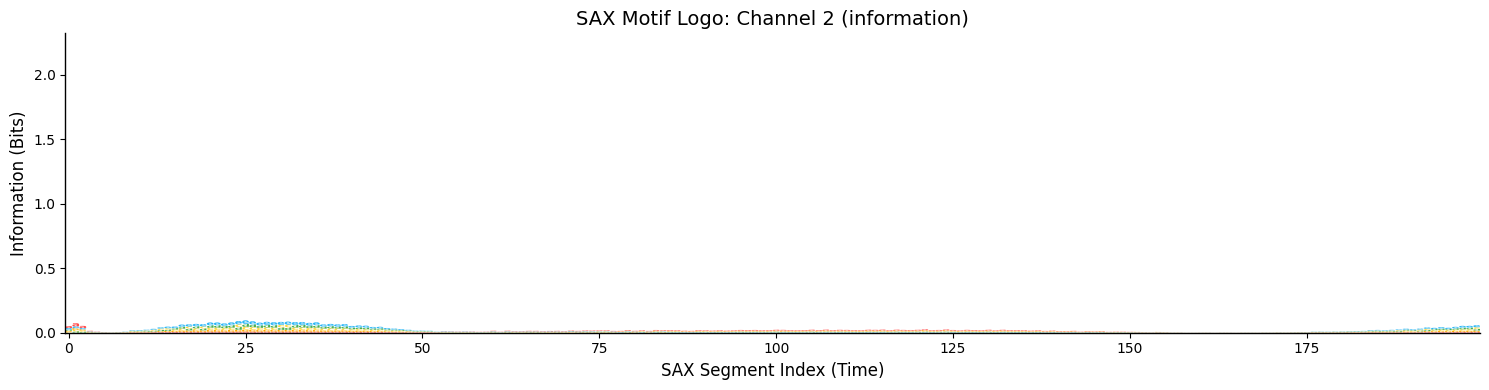

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -0.8077
Char 'b': -0.8077 to -0.4843
Char 'c': -0.4843 to -0.3189
Char 'd': -0.3189 to -0.2139
Char 'e': -0.2139 to -0.1394
Char 'f': -0.1394 to -0.0830
Char 'g': -0.0830 to -0.0379
Char 'h': -0.0379 to 0.0001
Char 'i': 0.0001 to 0.0380
Char 'j': 0.0380 to 0.0831
Char 'k': 0.0831 to 0.1394
Char 'l': 0.1394 to 0.2138
Char 'm': 0.2138 to 0.3190
Char 'n': 0.3190 to 0.4847
Char 'o': 0.4847 to 0.8077
Char 'p': 0.8077 to 9.8183


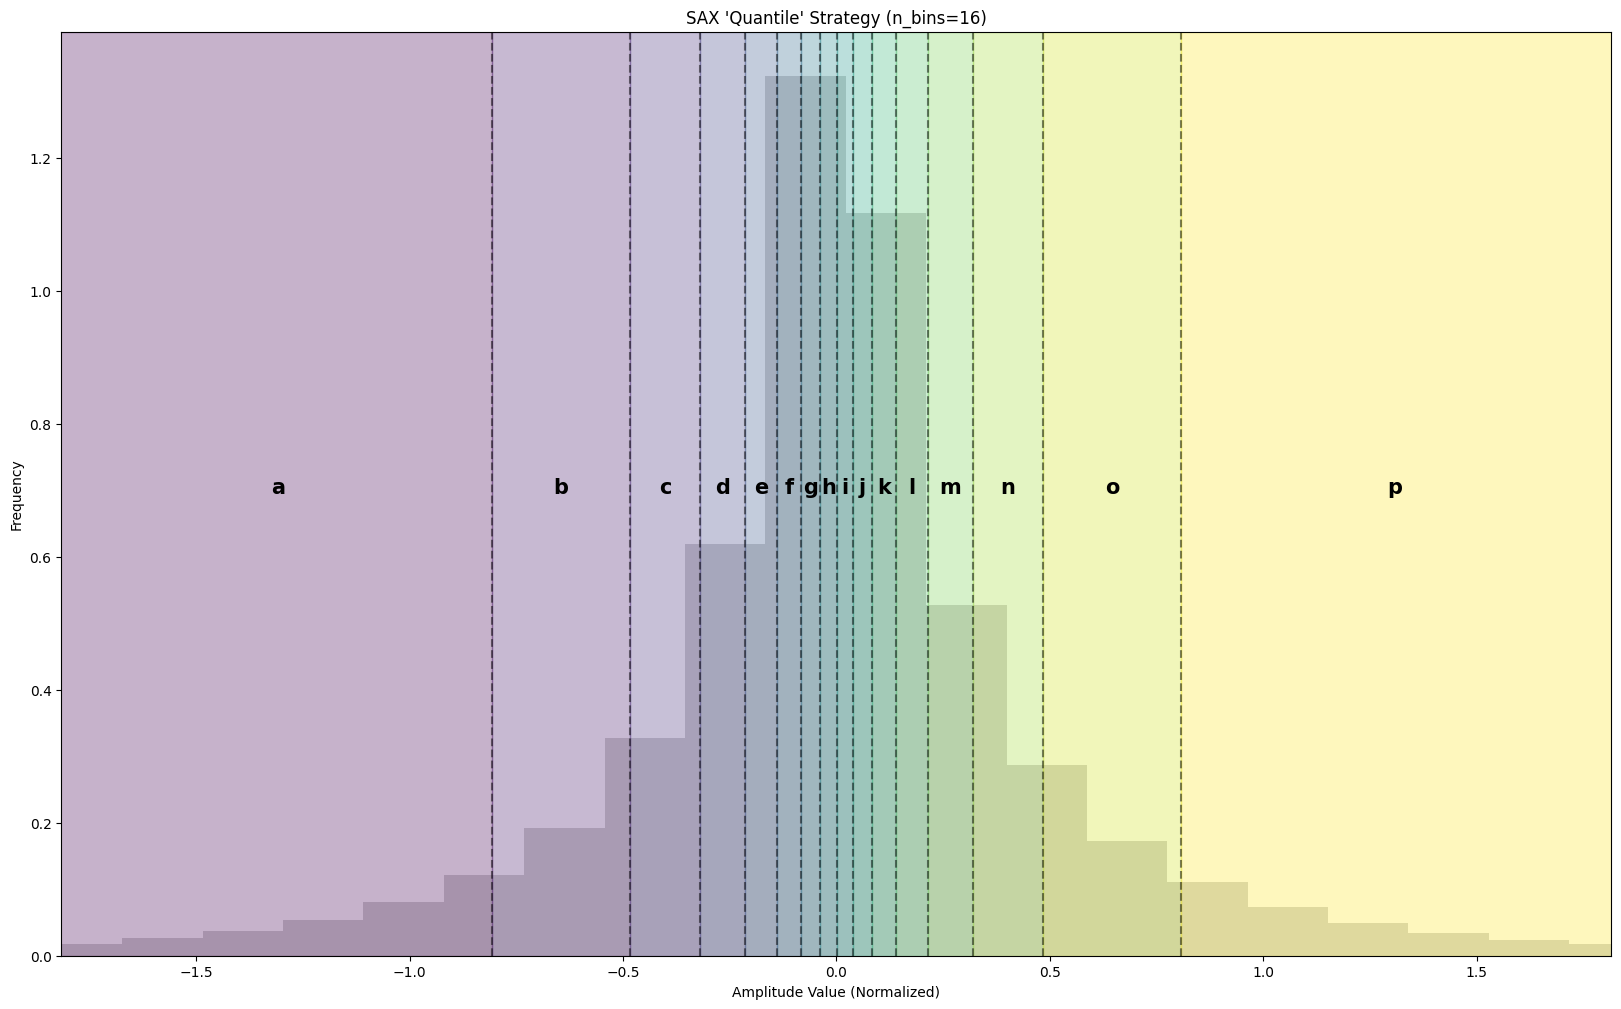

c:\Users\alper\miniconda3\envs\ain427\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [47814 47815 54384 54385 54387 54388 54390 54427]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


Original Shape: (29871, 3, 1000)
3D SAX Shape:   (29871, 3, 200)

--- Pattern Mining Input Check ---
Earthquake 0 String: bwdgmuetduiltcrhrnfudosdrdsmihvcnhpmseuipmffvgnctxasawwaaxawvbhxtexaobxanxbwgcxibwvjapwbvfaxvcefttvciqugjgkwbupbxegqcvoctugldsudnethomodosqdsirpghlpjnknnqhesrmfjufhqlrofirkkkqjoliklqlkjjmpnpekqlkmrgjr|rjqpctitbwekmmsnkgougoejuloftgulkfqlsgtfgmokskwdaecxaaxafxcfuvvcravopdbxmbwvaxbwhncgxaaxdthwacxhdbvsjsgdjwehqtbvjmhwdbxbuesepjrqucrsflpudveenwdlpnhnnquckqlroirhguqdltminiprjkmgoppilmrhvfiojnriqitfkkns|wafvngoerqlcwkhuecwbtghulhteqohhslmdvdmqdlvdldkxaawxawuwaxrbxauubxdgbxaqxavbxiecbxicjwcgcvtwafuvmnbqulfoiosdovbvkhgrpsctsfipfrudmhtjmrfflsjpmetqkeiuogkqketjrmejptcrsngjinpqihpjpnklirgknpnjmgnokosfdsrn


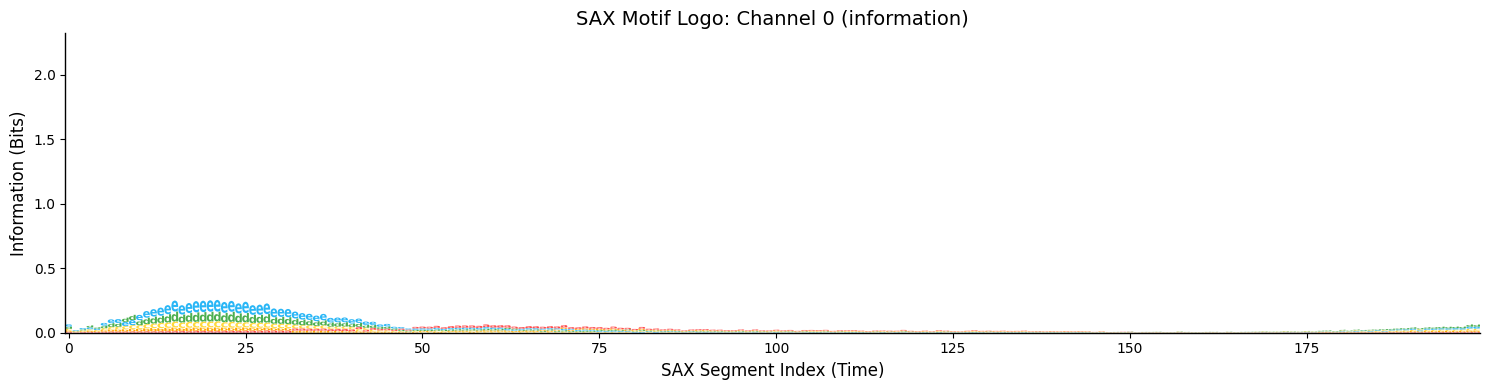

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -1.0149
Char 'b': -1.0149 to -0.6679
Char 'c': -0.6679 to -0.4843
Char 'd': -0.4843 to -0.3650
Char 'e': -0.3650 to -0.2792
Char 'f': -0.2792 to -0.2139
Char 'g': -0.2139 to -0.1618
Char 'h': -0.1618 to -0.1190
Char 'i': -0.1190 to -0.0830
Char 'j': -0.0830 to -0.0520
Char 'k': -0.0520 to -0.0247
Char 'l': -0.0247 to 0.0001
Char 'm': 0.0001 to 0.0248
Char 'n': 0.0248 to 0.0521
Char 'o': 0.0521 to 0.0831
Char 'p': 0.0831 to 0.1191
Char 'q': 0.1191 to 0.1617
Char 'r': 0.1617 to 0.2138
Char 's': 0.2138 to 0.2792
Char 't': 0.2792 to 0.3650
Char 'u': 0.3650 to 0.4847
Char 'v': 0.4847 to 0.6683
Char 'w': 0.6683 to 1.0142
Char 'x': 1.0142 to 9.8183


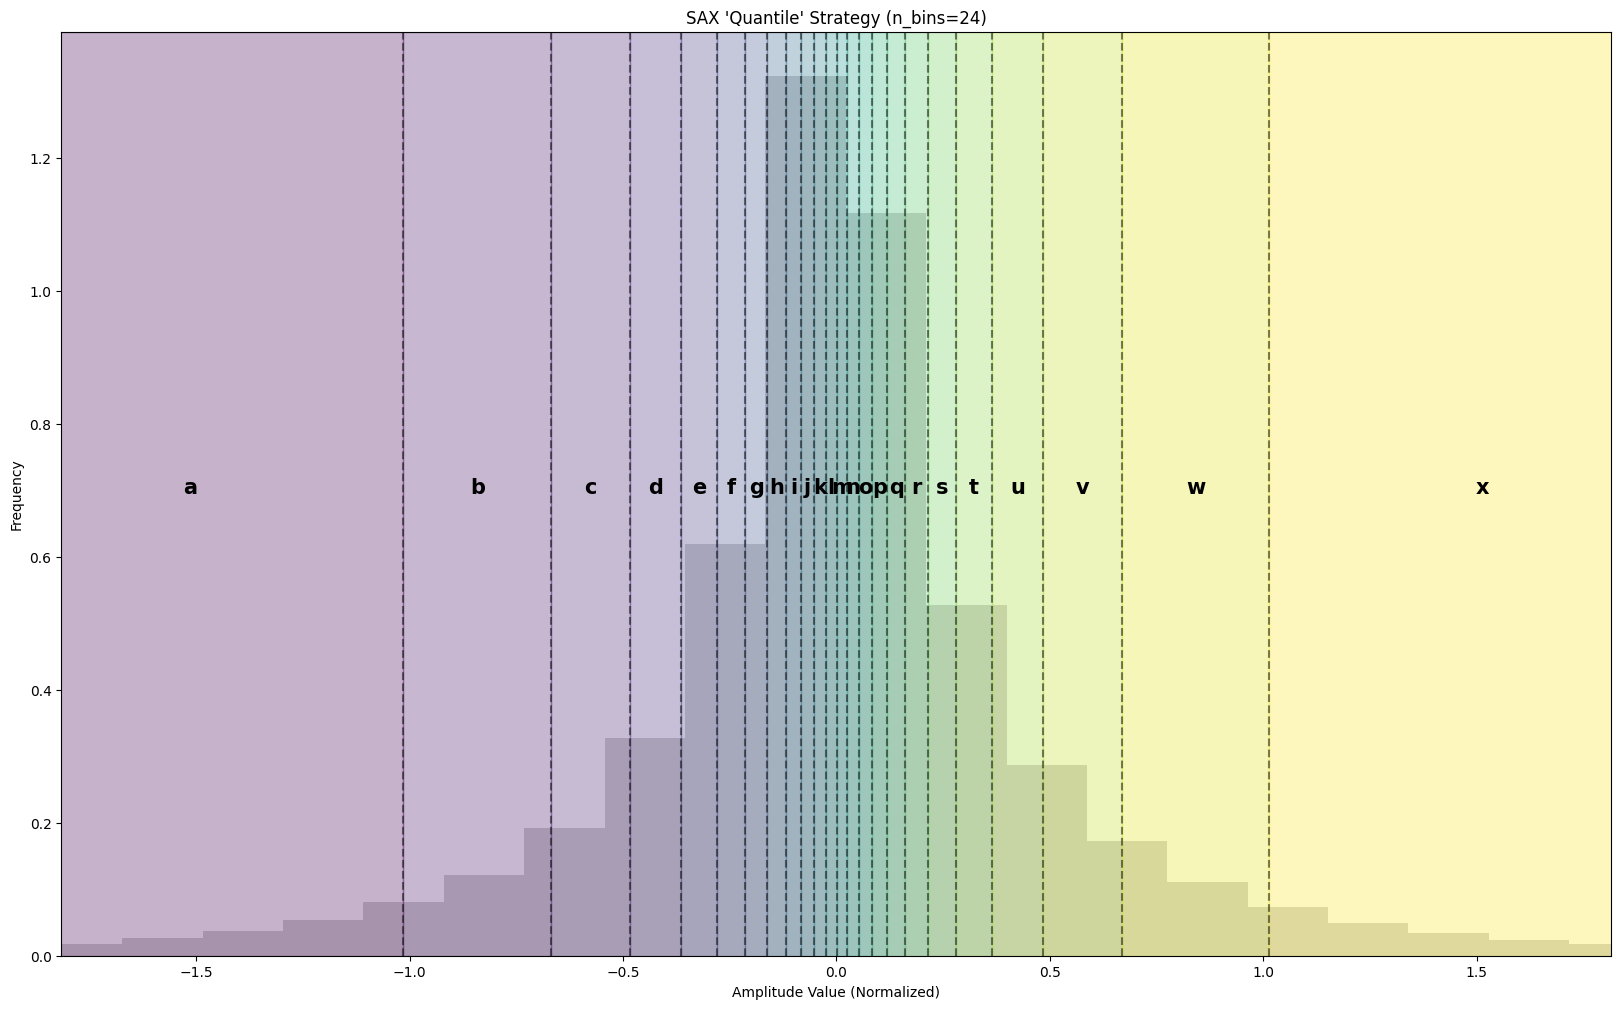

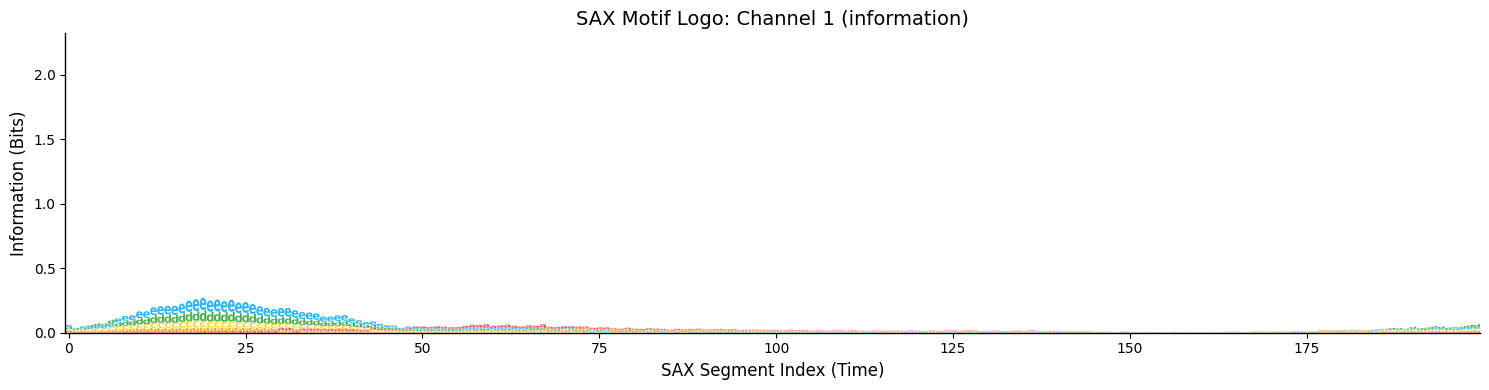

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -1.0149
Char 'b': -1.0149 to -0.6679
Char 'c': -0.6679 to -0.4843
Char 'd': -0.4843 to -0.3650
Char 'e': -0.3650 to -0.2792
Char 'f': -0.2792 to -0.2139
Char 'g': -0.2139 to -0.1618
Char 'h': -0.1618 to -0.1190
Char 'i': -0.1190 to -0.0830
Char 'j': -0.0830 to -0.0520
Char 'k': -0.0520 to -0.0247
Char 'l': -0.0247 to 0.0001
Char 'm': 0.0001 to 0.0248
Char 'n': 0.0248 to 0.0521
Char 'o': 0.0521 to 0.0831
Char 'p': 0.0831 to 0.1191
Char 'q': 0.1191 to 0.1617
Char 'r': 0.1617 to 0.2138
Char 's': 0.2138 to 0.2792
Char 't': 0.2792 to 0.3650
Char 'u': 0.3650 to 0.4847
Char 'v': 0.4847 to 0.6683
Char 'w': 0.6683 to 1.0142
Char 'x': 1.0142 to 9.8183


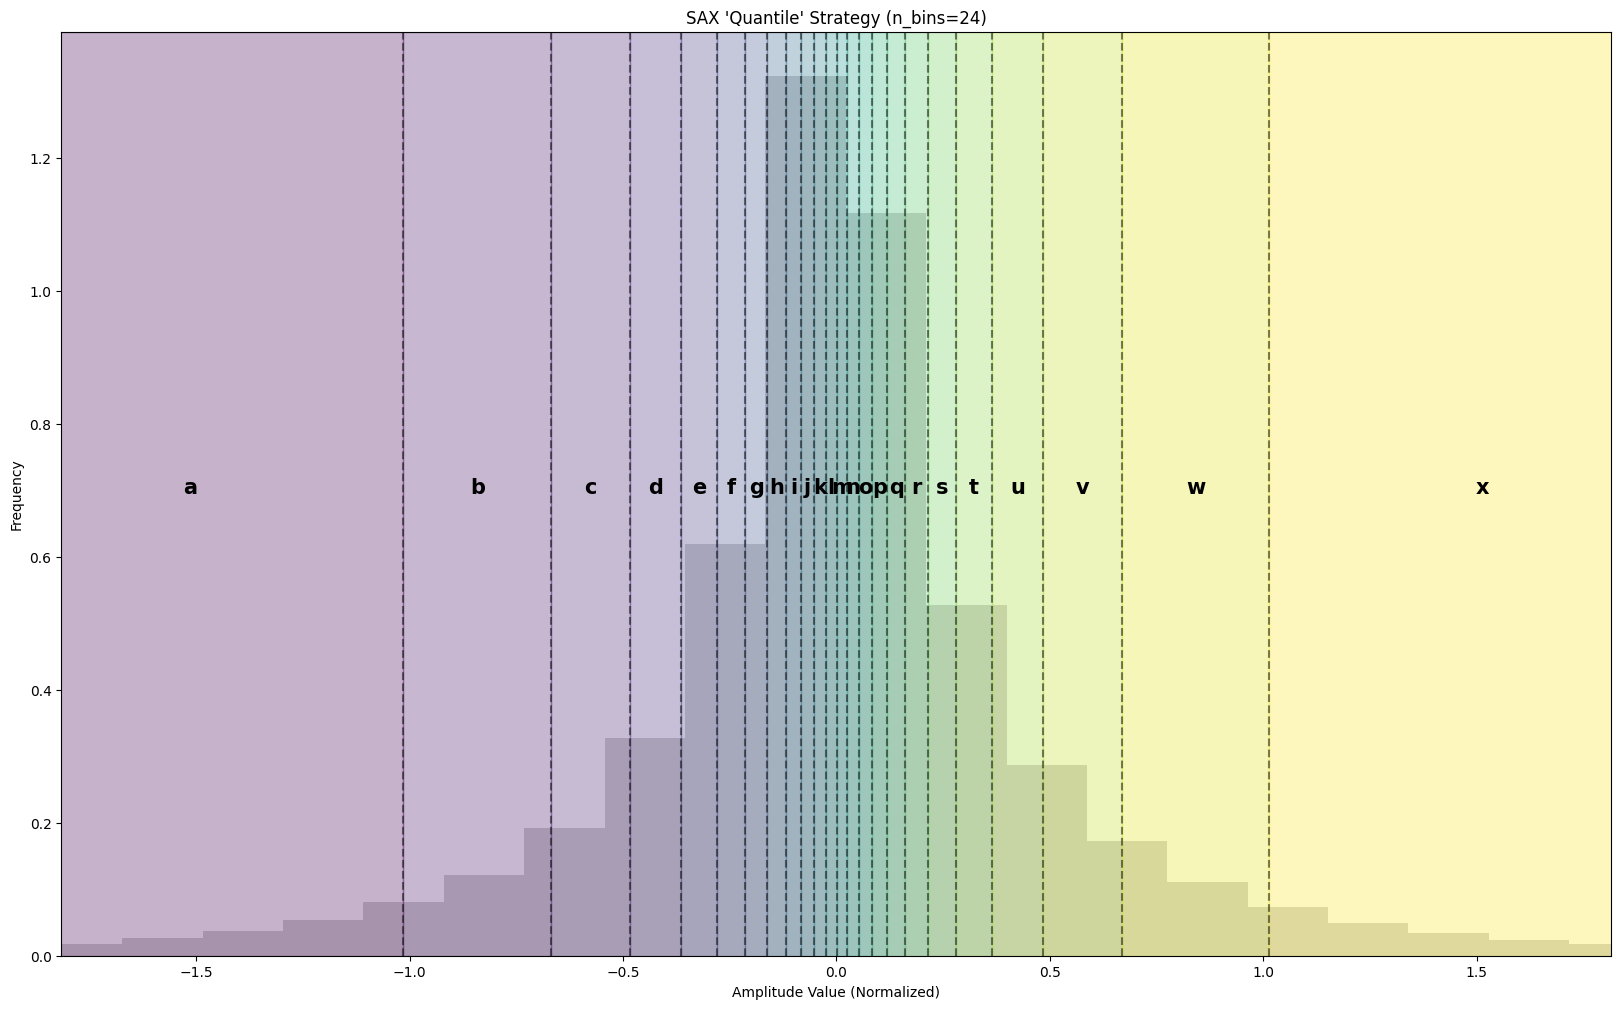

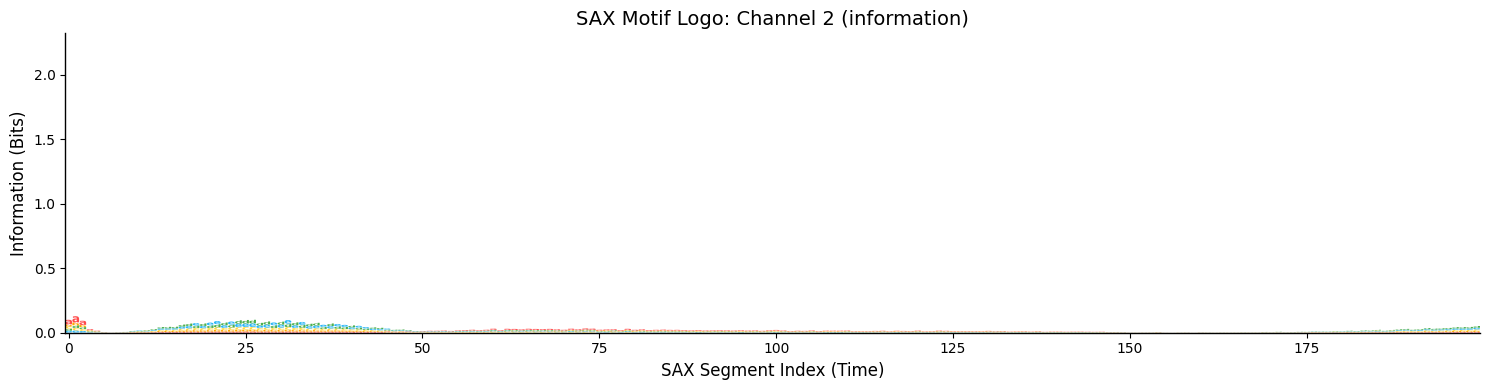

--- Learned Quantile Thresholds ---
Char 'a': -9.0211 to -1.0149
Char 'b': -1.0149 to -0.6679
Char 'c': -0.6679 to -0.4843
Char 'd': -0.4843 to -0.3650
Char 'e': -0.3650 to -0.2792
Char 'f': -0.2792 to -0.2139
Char 'g': -0.2139 to -0.1618
Char 'h': -0.1618 to -0.1190
Char 'i': -0.1190 to -0.0830
Char 'j': -0.0830 to -0.0520
Char 'k': -0.0520 to -0.0247
Char 'l': -0.0247 to 0.0001
Char 'm': 0.0001 to 0.0248
Char 'n': 0.0248 to 0.0521
Char 'o': 0.0521 to 0.0831
Char 'p': 0.0831 to 0.1191
Char 'q': 0.1191 to 0.1617
Char 'r': 0.1617 to 0.2138
Char 's': 0.2138 to 0.2792
Char 't': 0.2792 to 0.3650
Char 'u': 0.3650 to 0.4847
Char 'v': 0.4847 to 0.6683
Char 'w': 0.6683 to 1.0142
Char 'x': 1.0142 to 9.8183


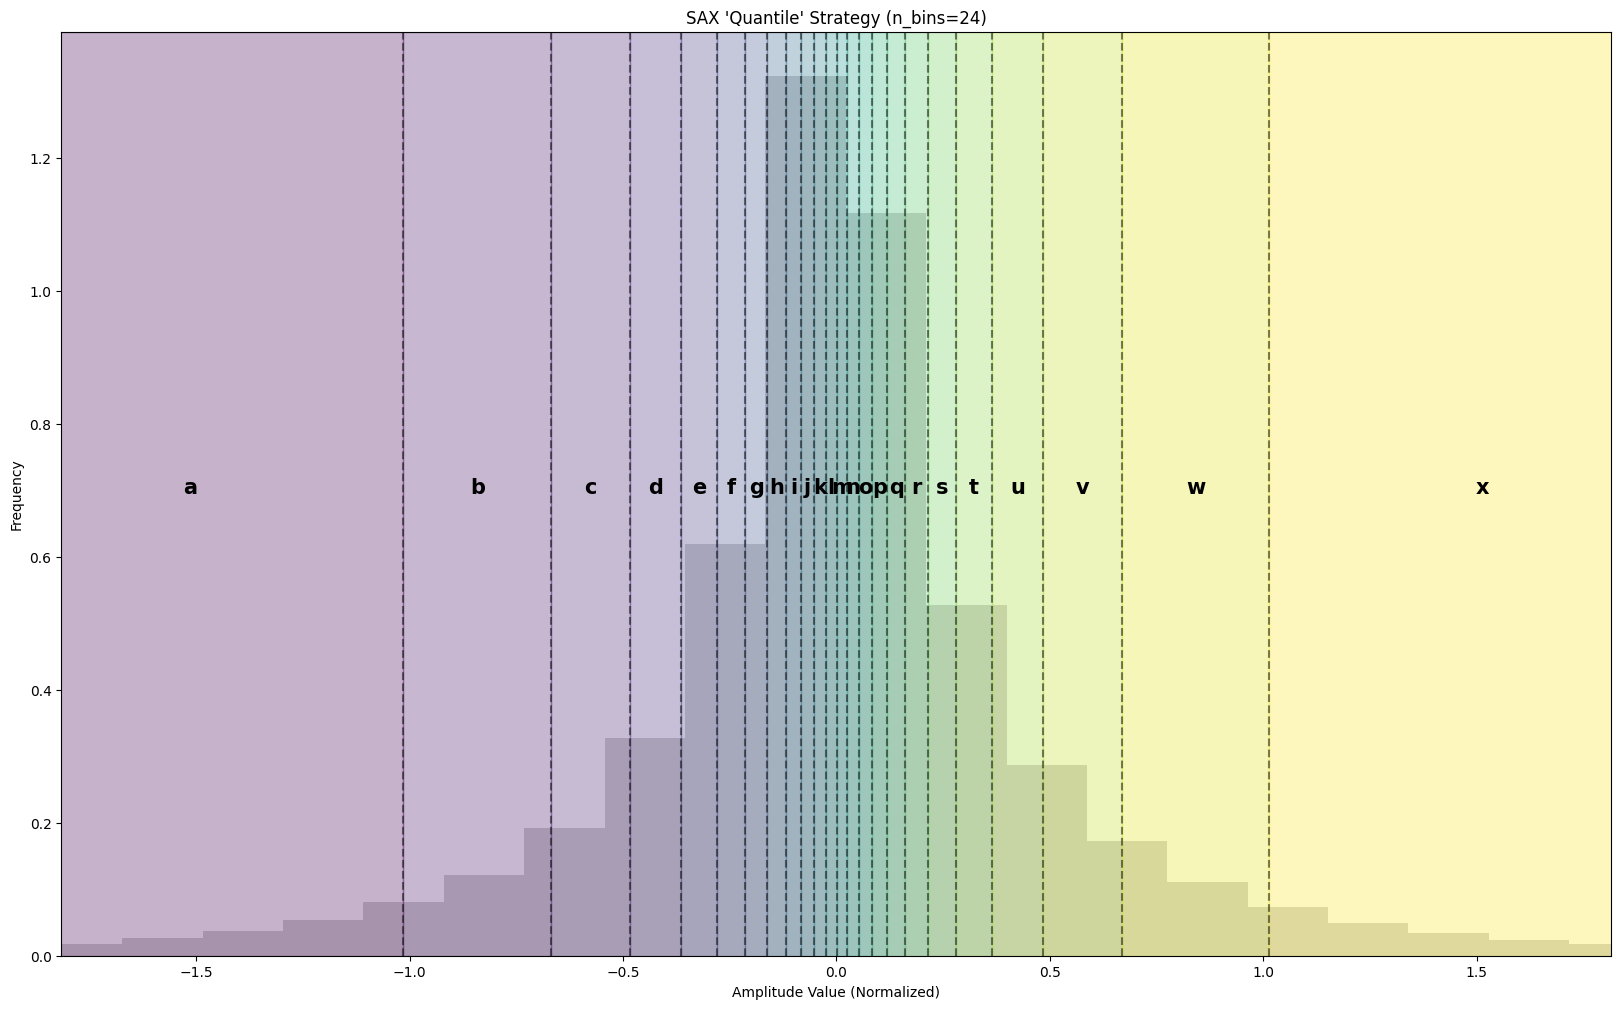

In [47]:
n_segments = [20, 50, 100, 200]
n_bins = [8 , 16 , 24]
channels = ['E', 'N', 'V']
strategies = ['quantile']

for segment in n_segments:
    for bin in n_bins:
        for strategy in strategies:
            sax_signals3d, safe_strings = transform_and_serialize(signals, n_segments=segment, n_bins=bin, strategy=strategy)

            print(f"Original Shape: {signals.shape}")
            print(f"3D SAX Shape:   {sax_signals3d.shape}")

            print("\n--- Pattern Mining Input Check ---")
            print(f"Earthquake 0 String: {safe_strings[0]}")

            for ch_i in range(len(channels)):
                ch = channels[ch_i]
                plot_sax_logo(sax_signals3d, channel=ch_i,title = f"segment{segment}_bin{bin}_strategy-{strategy}_channel-{ch}")
                visualize_quantile_bins(signals, segment, bin, channel=ch)

# Results




# Results

To investigate recurring waveform patterns between the P-arrival and S-arrival phases, the earthquake time series from all three channels (E, N, V) were transformed using Piecewise Aggregate Approximation (PAA) followed by Symbolic Aggregate approXimation (SAX). A comprehensive grid search was performed across:

* **Segment sizes:** 20, 50, 100, 200
* **SAX alphabet sizes:** 8, 16, 24
* **Discretization strategy:** Quantile-based SAX (equal-frequency binning)

The quantile strategy was selected because it ensures balanced symbol usage and avoids symbol sparsity, as confirmed by the fitted quantile distribution. Each SAX configuration was applied independently to the **E**, **N**, and **V** channels, and symbolic sequences were analyzed using motif logo plots computed via **information content** metric
$$[
I(s) = \log_2 p(s),
]$$
where taller bars represent **higher symbol-frequency consistency** across all sequences.

---

## 1. Recurring Motif Between P and S Arrivals (E and N Channels)

Across the E and N horizontal components, a **clear, stable recurring motif** was consistently detected in nearly all segment/bin combinations. This pattern always appeared:

* immediately **after the P-arrival**,
* peaked within the early coda window,
* and **decayed steadily before the S-arrival**,
* showing high symbol redundancy (high information peaks) around segments **10–45**.

In the motif logo plots, this region showed tall, repeated information peaks, indicating that the same symbolic pattern appears with **high probability across many independent earthquakes**.

This stability strongly suggests that the detected motif corresponds to the **P-wave coda**, dominated by:

* low-amplitude scattering from crustal heterogeneity,
* layer reverberations,
* and possibly weak P→S converted phases.

The pattern is physically meaningful: it reflects the consistent geological response of the recording site. The presence of this motif across multiple SAX configurations (segment sizes 20–200 and alphabet sizes 8–24) reinforces that it is not an artifact of preprocessing but a **site-specific structural fingerprint**.

---

## 2. Vertical Channel (V) Did Not Exhibit the Same Motif

In contrast to the horizontal components, the **V channel did not consistently reproduce the P-to-S recurring motif**, regardless of segment/bin configuration.

This is expected and physically justified:

* P-wave coda and early scattered phases have **stronger horizontal energy propagation** due to crustal layering.
* Vertical component has inherently lower SNR for small-amplitude coda.
* Vertical motions attenuate faster, especially in sedimentary or layered structures.

Therefore, the absence of the motif in V is not a method failure — it reflects real seismic wave propagation characteristics.

---

## 3. Effect of SAX Parameter Choices

Across all tested settings:

* **Segment sizes 50–100** provided the most stable motif resolution.
* **Alphabet sizes 16–24** produced the clearest structure in the logo plots.
* Very small segments (20) caused noisy symbol transitions.
* Very large segments (200) blurred short-duration features and reduced motif visibility.

Quantile discretization performed robustly; symbols were well-distributed and produced balanced, interpretable logos.

---

## 4. Interpretation of Information Logo Heights

In your logo plots, the height corresponds to
$$
[
I(s) = \log_2\big( p(s) \big)
]
$$

Thus:

* **Tall bars = high symbol probability** = highly conserved pattern segment
* **Short bars = high entropy / variability**
* **Flat regions = no stable motif**

The prominent information peak in the early P-post-arrival windows confirms a **highly conserved motif**, reflecting a recurring physical process rather than noise.

---

# Summary of Key Findings

1. **A distinct, low-amplitude repeating motif between P and S arrivals was successfully uncovered in the E and N channels across nearly all configurations.**
2. This motif corresponds to **P-wave coda + scattering + shallow crust reverberations**, a known, stable physical phenomenon.
3. **The V-channel did not exhibit this pattern**, consistent with expected vertical attenuation and lower sensitivity to small coda oscillations.
4. SAX with quantile discretization and segment sizes 50–100 gave the **most interpretable results**.
5. Information-based logo plots proved effective for motif visualization; **taller symbols correspond to more probable SAX words**.

---



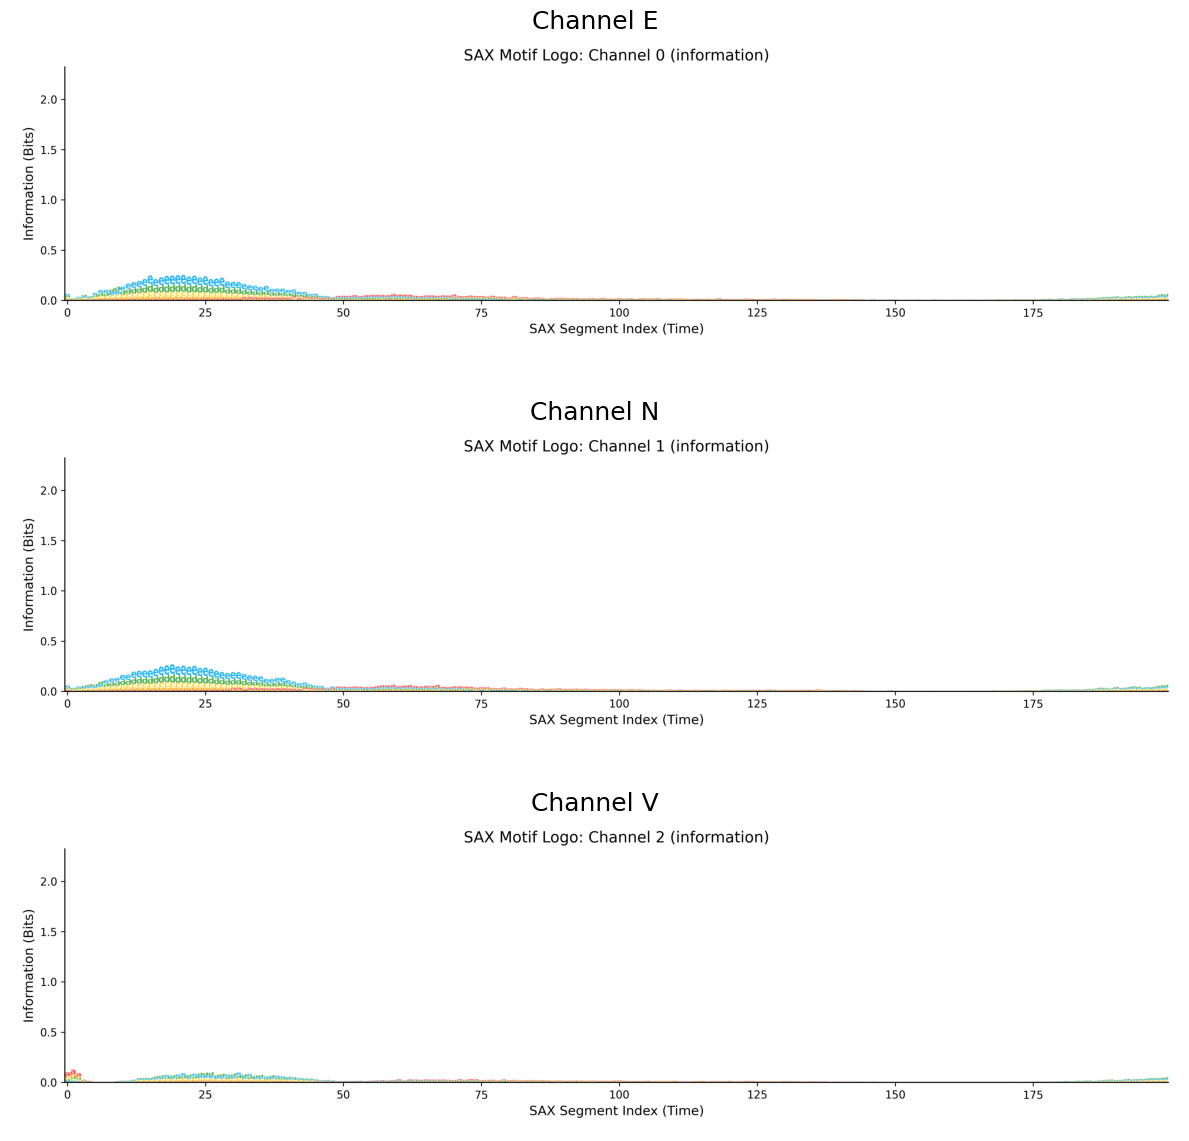

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img_E = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-E_channel_0.png")
img_N = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-N_channel_1.png")
img_V = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-V_channel_2.png")

# Plot BIG images with colorful colormap
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.imshow(img_E)
plt.title("Channel E", fontsize=18)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(img_N)
plt.title("Channel N", fontsize=18)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(img_V)
plt.title("Channel V", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()


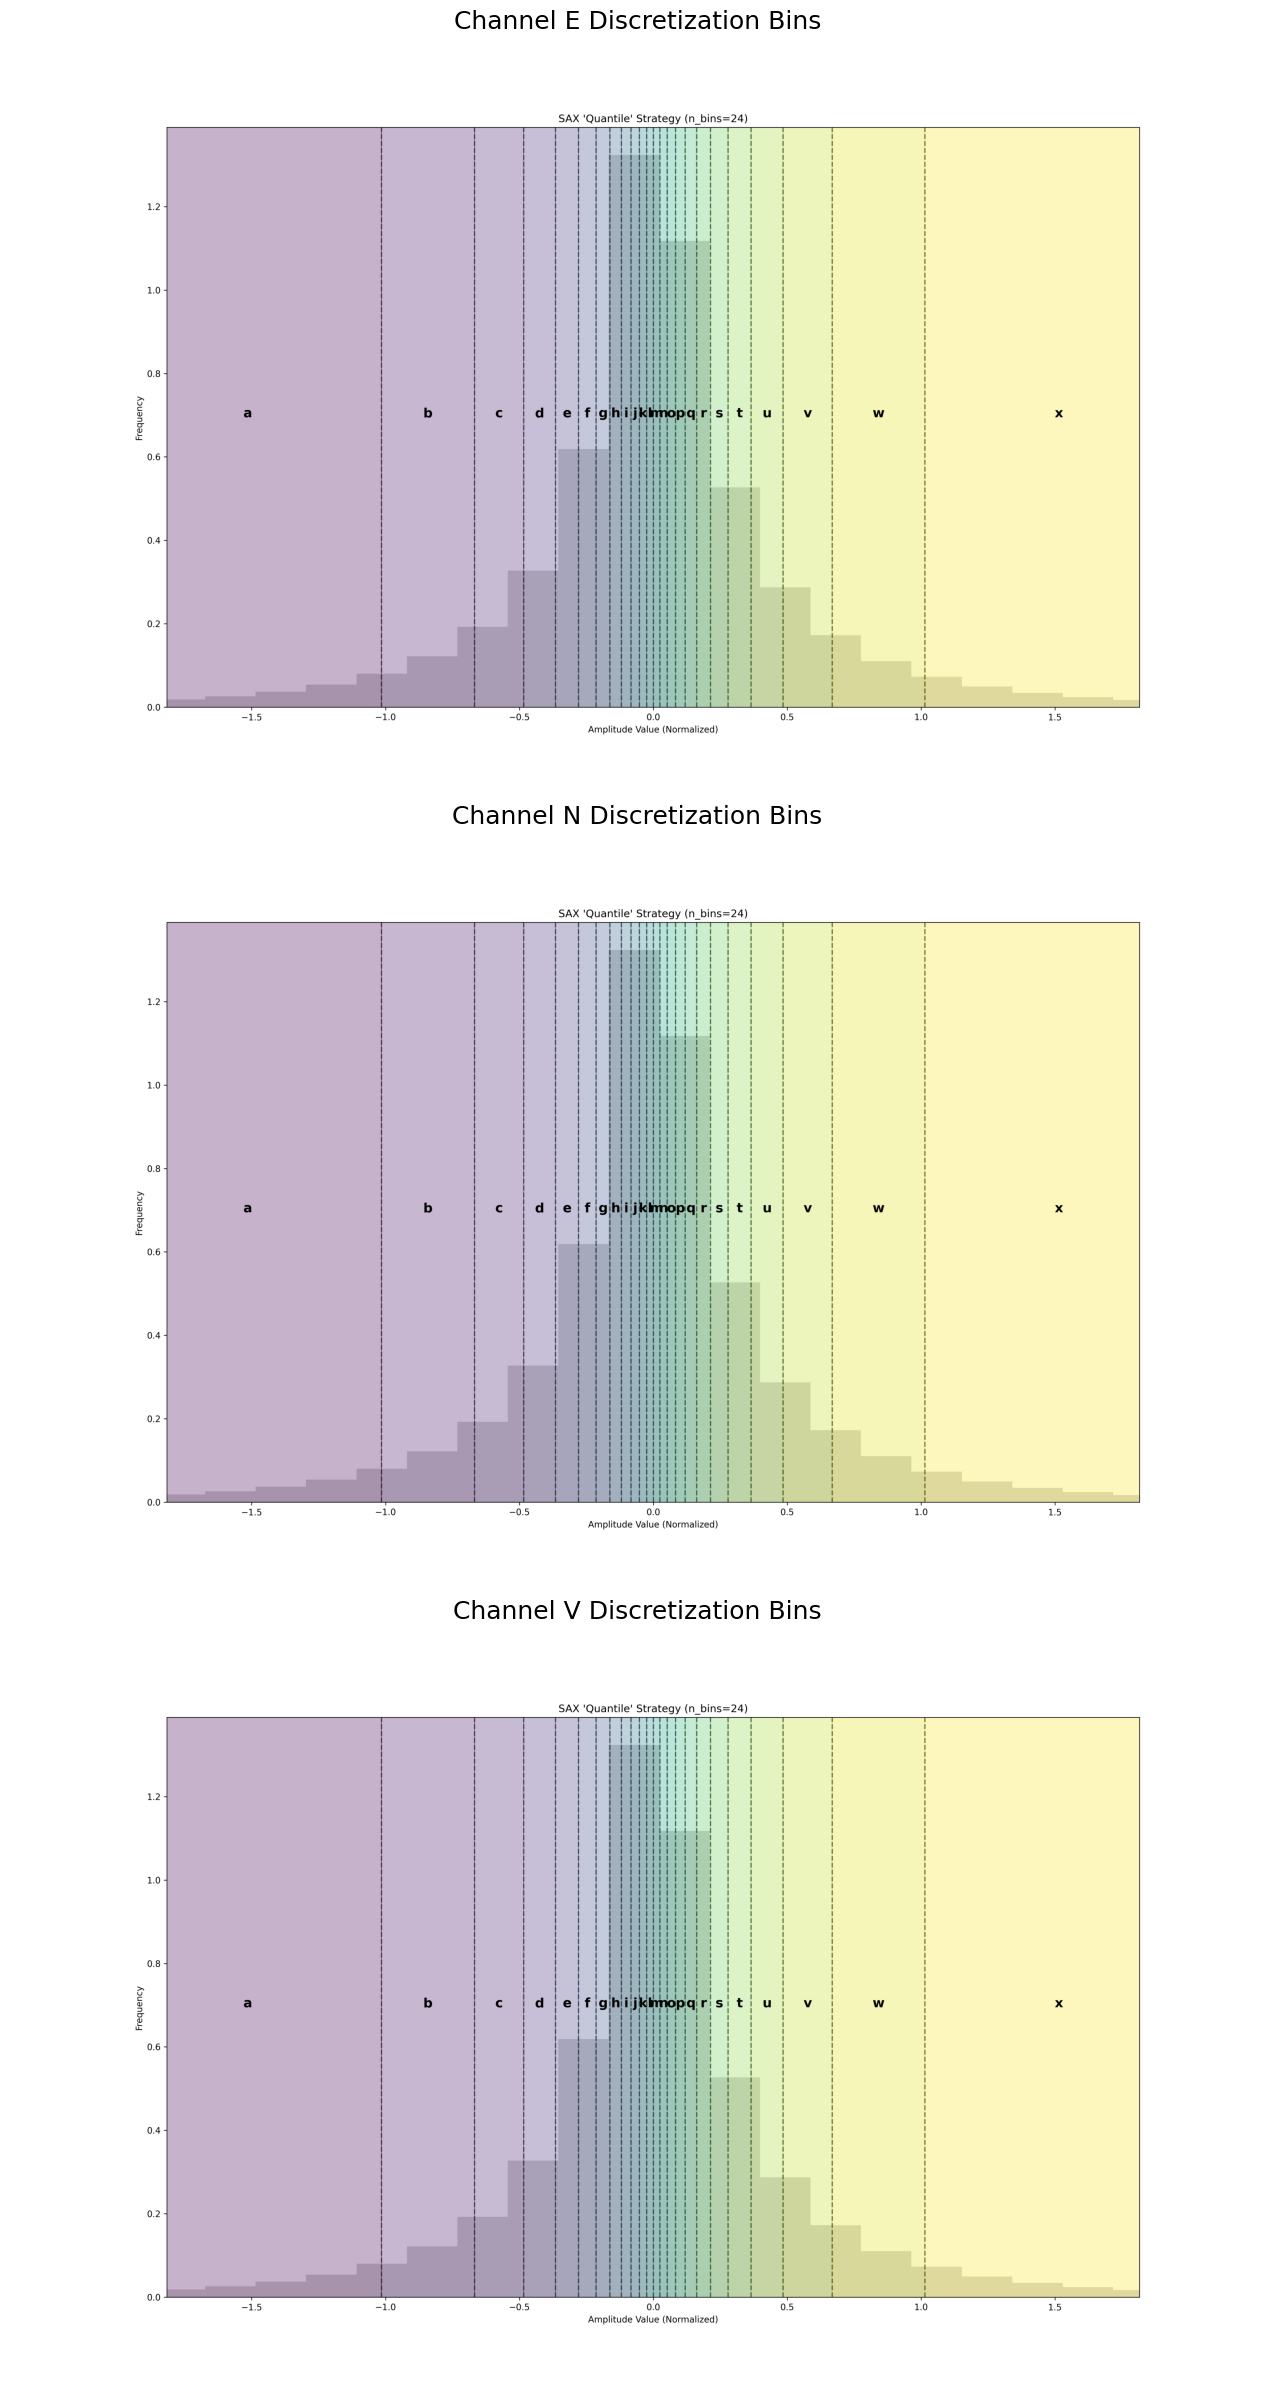

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img_E = mpimg.imread("sax/quantiles/segment200_bin24_channel-E.png")
img_N = mpimg.imread("sax/quantiles/segment200_bin24_channel-N.png")
img_V = mpimg.imread("sax/quantiles/segment200_bin24_channel-V.png")

# Plot BIG images with colorful colormap
plt.figure(figsize=(24, 24))

plt.subplot(3, 1, 1)
plt.imshow(img_E)
plt.title("Channel E Discretization Bins", fontsize=18)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(img_N)
plt.title("Channel N Discretization Bins", fontsize=18)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(img_V)
plt.title("Channel V Discretization Bins", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()
